
#Description:

* In this project, I will work with a dataset taken from Kaggle, where I will perform a credit risk analysis. The data provided comes from LendingClub, a financial services company based in San Francisco, California. LendingClub was the first peer-to-peer lending platform to register its offerings as securities with the Securities and Exchange Commission (SEC) and to offer loan trading on a secondary market. The company offers personal loans of up to $40,000, with terms ranging from 24 to 60 months, and operates entirely online, with no physical branches.

* In this project, I will apply the CRISP-DM method, which follows the following steps:

  * 1-**Business understanding**:

    What does the business need?

  * 2-**Data understanding**:

    What data do we have/need? Is it clean?

  * 3-**Data preparation**:

    How do we organize the data for modeling?

  * 4-**Modeling**:

    Which modeling techniques should we apply?

  * 5-**Evaluation**:

    What best meets the business objectives?

  * 6-**Deployment**:

    How do stakeholders access the results?

* **Categorical Variables**: 
  
  * For ordinal categorical variables, I will use the Ordinal Encoder. For nominal variables, the Target Encoder will be applied, with the aim of not increasing the dimensionality of our data, and also considering that this approach brings us more information for our training data because the variables are encoded according to their distributions in relation to the target variable, which in this case will be the **loan_status**.

* **Numerical Variables**: 
  
  * For numerical data, we will apply the normalization technique using MinMaxScaler. This choice aims to preserve the distribution of the data, considering that our distributions are almost all asymmetric, so opting for MinMaxScaler makes more sense in this context.

  * The decision to use MinMaxScaler also takes into account the fact that our data has a significant amount of outliers. However, these outliers are part of the natural distribution of the institution's data. Therefore, the objective of this choice is to allow the model to learn from this data.

* **Machine learning algorithms that will be used in this project**:

  * The basis of this project is a model with PyTorch, but first, to compare and verify the most suitable models for our data, a model will be created in each of the algorithms below:

  * Random Forest Classifier

  * KNN

  * Logistic Regression

  * XGBoost

  * Next, a network will be created in PyTorch. This network will undergo an initial training, in which we will evaluate the metrics and the results obtained.

* **How will the metrics for the evaluation stage be chosen?**:

  * The metrics that will be considered as a parameter to determine the best model and its effectiveness will be **AUC-ROC** together with **Accuracy**. Since we are dealing with binary classes and we have a minority class, which are the loans classified as unpaid, the accuracy of the model would not be enough to determine whether the model converged adequately with its classifications.

  * Therefore, I will be using the **AUC-ROC** metric as the first criterion as a main parameter to determine the effectiveness of the model. This metric takes into account the correct classification of the positive and negative classes, since in a dataset where we have an imbalance in the classes, it is common and natural to expect that the model has a tendency to classify most of the training and testing data with the majority class. Therefore, we will use this metric as a fundamental parameter for the evaluation and analysis of our models, so that we have a good control over false positives and false negatives, in order to reduce them as much as possible.

  * In the background, I will use the accuracy of the model to consider whether there is good predictability of the model with training, validation and testing data.

* **Hypertune | Finetune**:

  * After this initial training, we will **hypertune** the model, adjusting the hyperparameters and the number of neurons in the hidden layers.

  * Later, we will **finetune**, adjusting the learning level per epoch of the model.

* **Test data**

  * Finally, we will move on to the model evaluation stage, in which we will check its performance on the test data.

# Installs:

In [0]:
# install in the cluster > Libraries > Install new > PyPI  insert: >>>:

# threadpoolctl==3.5.0

# scikit-learn==1.5.2

# category_encoders==2.6.3

# torch==2.5.1

# torchmetrics==1.4.2

# xgboost==2.1.0

# ray[tune]==2.38.0

# Imports:

In [0]:
# Data modeling
# Pyspark.Api Pandas
from pyspark import pandas as ps

# Pandas
import pandas as pd

# Sklearning
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Target Encoder
from category_encoders import TargetEncoder


# Machine Learning

# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# XGboost
import xgboost  as xgb

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset as Dataset
from torch.utils.data import WeightedRandomSampler

# Torch Metrics
import torchmetrics
from torchmetrics.classification import BinaryConfusionMatrix, BinaryAccuracy, BinaryF1Score, BinaryRecall, BinaryAUROC
from torchmetrics import MetricCollection
from torchmetrics import Accuracy, AUROC

# Graphics
# Matplotlib
import matplotlib.pyplot as plt # Graphics for metrics

import seaborn as sns

# Numpy
import numpy as np

# Python
import random
from functools import partial
import os
import tempfile
from pathlib import Path

# Ray tunner
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

# Warnings
import warnings

# Options:

In [0]:
ps.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore', category = FutureWarning)
#warnings.filterwarnings('ignore', category = UserWarning, module = 'threadpoolctl')

# 4-Modeling

## Loading data train and data test

In [0]:
# File location and file type
file_location = 'dbfs:/FileStore/Data_Science_Credit_Risk_Analysis-Lending_Club/Datasets/Gold/train'
train_data = ps.read_parquet(file_location)

# File location and file type
file_location = 'dbfs:/FileStore/Data_Science_Credit_Risk_Analysis-Lending_Club/Datasets/Gold/test'
test_data = ps.read_parquet(file_location)

The train set

In [0]:
train_data.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mo_earliest_cr_line,real_income,ability_to_pay,expen_cr_inc,score_cr
0,5000.0,36 months,10.65,B2,10,RENT,Fully Paid,credit_card,27.65,A,B,3,A,83.7,9,f,A,79803.0,22100.0,323,17364.00,11.26,D,716.67
1,2500.0,60 months,15.27,C4,0,RENT,Charged Off,car,1.00,A,B,3,A,9.4,4,f,A,79803.0,22100.0,152,29700.00,2.42,B,875.00
2,2400.0,36 months,15.96,C5,10,RENT,Fully Paid,small_business,8.72,A,B,2,A,98.5,10,f,A,79803.0,22100.0,121,11183.63,9.05,C,708.33
3,10000.0,36 months,13.49,C1,10,RENT,Fully Paid,other,20.00,A,B,10,A,21.0,37,f,A,79803.0,22100.0,190,39360.00,10.34,C,858.33
4,5000.0,36 months,7.90,A4,3,RENT,Fully Paid,wedding,11.20,A,B,9,A,28.3,12,f,A,79803.0,22100.0,85,31968.00,5.87,C,733.33


Size trainset

In [0]:
train_data.shape

(195422, 24)

Info trainset

In [0]:
train_data.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 195422 entries, 0 to 195421
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            195422 non-null  float64
 1   term                 195422 non-null  object 
 2   int_rate             195422 non-null  float64
 3   sub_grade            195422 non-null  object 
 4   emp_length           195422 non-null  object 
 5   home_ownership       195422 non-null  object 
 6   loan_status          195422 non-null  object 
 7   purpose              195422 non-null  object 
 8   dti                  195422 non-null  float64
 9   delinq_2yrs          195422 non-null  object 
 10  inq_last_6mths       195422 non-null  object 
 11  open_acc             195422 non-null  int32  
 12  pub_rec              195422 non-null  object 
 13  revol_util           195422 non-null  float64
 14  total_acc            195422 non-null  int32  
 15  initial_list_s

The test set

In [0]:
test_data.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mo_earliest_cr_line,real_income,ability_to_pay,expen_cr_inc,score_cr
0,9600.0,36 months,13.66,C3,10,RENT,Fully Paid,debt_consolidation,25.81,A,A,12,A,59.4,44,f,A,38566.0,27600.0,265,51191.10,7.65,C,791.67
1,7650.0,36 months,13.66,C3,0,RENT,Charged Off,debt_consolidation,34.81,A,B,11,A,91.9,20,f,A,64426.0,18300.0,148,32595.00,9.58,D,600.00
2,5250.0,36 months,11.44,B4,2,RENT,Fully Paid,debt_consolidation,14.36,A,A,8,A,20.2,13,f,A,10133.0,22000.0,67,22266.40,9.32,C,758.33
3,2500.0,36 months,11.99,B5,0,MORTGAGE,Fully Paid,home_improvement,13.77,A,B,9,A,94.3,32,f,A,397223.0,24300.0,158,76744.70,1.30,D,775.00
4,2000.0,36 months,14.99,C5,8,RENT,Fully Paid,credit_card,22.14,A,A,10,B,62.4,21,f,A,20539.0,15300.0,219,25070.92,3.32,D,733.33


Size test set

In [0]:
test_data.shape

(57509, 24)

Info test set

In [0]:
test_data.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 57509 entries, 0 to 57508
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            57509 non-null  float64
 1   term                 57509 non-null  object 
 2   int_rate             57509 non-null  float64
 3   sub_grade            57509 non-null  object 
 4   emp_length           57509 non-null  object 
 5   home_ownership       57509 non-null  object 
 6   loan_status          57509 non-null  object 
 7   purpose              57509 non-null  object 
 8   dti                  57509 non-null  float64
 9   delinq_2yrs          57509 non-null  object 
 10  inq_last_6mths       57509 non-null  object 
 11  open_acc             57509 non-null  int32  
 12  pub_rec              57509 non-null  object 
 13  revol_util           57509 non-null  float64
 14  total_acc            57509 non-null  int32  
 15  initial_list_status  57509 non-nu

## Separating features and labels

#### Encoding the training and test data labels

In [0]:
train_data['loan_status'] = train_data['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1}).astype(int)
test_data['loan_status'] = test_data['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1}).astype(int)

In [0]:
train_data['loan_status'].head(10)

0    0
1    1
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
Name: loan_status, dtype: int64

In [0]:
test_data['loan_status'].head(10)

0    0
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: loan_status, dtype: int64

### Separating Features from Labels

In [0]:
# Train
X_train = train_data.drop(columns = ['loan_status']) 
y_train =  train_data['loan_status'].copy()

# Test
X_test = test_data.drop(columns = ['loan_status']) 
y_test =  test_data['loan_status'].copy()

In [0]:
print(f'The Train Features dataset shape: {X_train.shape}')
print(f'The Train Labels dataset shape: {y_train.shape}')
print(f'The Test Features dataset shape: {X_test.shape}')
print(f'The Test Labels dataset shape: {y_test.shape}')

The Train Features dataset shape: (195422, 23)
The Train Labels dataset shape: (195422,)
The Test Features dataset shape: (57509, 23)
The Test Labels dataset shape: (57509,)


Adjusting the datasets to pd.dataframe type

In [0]:
X_train = X_train.to_pandas()
y_train = y_train.to_pandas()
X_test = X_test.to_pandas()
y_test = y_test.to_pandas()

### Checking numeric columns

In [0]:
numerical_continuos = X_train.select_dtypes('float64').columns.to_list()
numerical_discrete = X_train.select_dtypes('int32').columns.to_list()
numerical_features = numerical_continuos
numerical_features.extend(numerical_discrete)
print(f'There are {len(numerical_features)} numerical features.')
print('\nThere are:')
numerical_features

There are 12 numerical features.

There are:


['loan_amnt',
 'int_rate',
 'dti',
 'revol_util',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'real_income',
 'ability_to_pay',
 'score_cr',
 'open_acc',
 'total_acc',
 'mo_earliest_cr_line']

### Checking categorical columns

In [0]:
categorical_features = X_train.select_dtypes('object').columns.to_list()
print(f'There are {len(categorical_features)} categorical features.')
print('\nThere are:')
categorical_features

There are 11 categorical features.

There are:


['term',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'purpose',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'initial_list_status',
 'tot_coll_amt',
 'expen_cr_inc']

In [0]:
for feature in categorical_features:
  print(feature)
  print('-' * 40)
  print(f'There are {X_train[feature].nunique()} unique values there are: ')
  print(X_train[feature].value_counts(normalize = True))
  print()

term
----------------------------------------
There are 2 unique values there are: 
 36 months    0.794957
 60 months    0.205043
Name: term, dtype: float64

sub_grade
----------------------------------------
There are 35 unique values there are: 
B3    0.078645
B4    0.071282
B2    0.062163
C1    0.059077
B5    0.057522
C2    0.055690
B1    0.050593
A5    0.049104
C3    0.048342
A4    0.046960
C4    0.044928
C5    0.042165
D1    0.038005
D2    0.034986
A3    0.030769
D3    0.029792
D4    0.027366
A2    0.025662
A1    0.024004
D5    0.022500
E2    0.016170
E1    0.015674
E3    0.013131
E4    0.011682
E5    0.009738
F1    0.007921
F2    0.006427
F3    0.005593
F4    0.004319
F5    0.003352
G1    0.002374
G2    0.001637
G3    0.001095
G4    0.000737
G5    0.000594
Name: sub_grade, dtype: float64

emp_length
----------------------------------------
There are 11 unique values there are: 
10    0.294583
0     0.119951
2     0.094089
3     0.081726
5     0.076255
1     0.066799
4     0.06569

### Checking labels

In [0]:
  print('loan_status')
  print('-' * 40)
  print(f'There are {y_train.nunique()} unique values there are: ')
  print(y_train.value_counts(normalize = True))
  print()

loan_status
----------------------------------------
There are 2 unique values there are: 
0    0.814698
1    0.185302
Name: loan_status, dtype: float64



## Preprocessing

### Categorical Features

In [0]:
# Ordinal features
ordinal_features = [
     'term', 'sub_grade', 'expen_cr_inc'  
]
# Manual adjustment
ordinal_emp_length = ['emp_length']

# Nominal Features

nominal_features = ['home_ownership', 'purpose', 'initial_list_status', 'tot_coll_amt', 'delinq_2yrs', 'pub_rec', 'inq_last_6mths',]


### Numerical Features

In [0]:

num_features = [
  'loan_amnt', 'int_rate', 'dti', 'open_acc', 'revol_util', 'total_acc','tot_cur_bal', 'total_rev_hi_lim', 'real_income', 'ability_to_pay', 'score_cr', 'mo_earliest_cr_line',
]

In [0]:
# Categorical ordinal
categorical_ordinal = Pipeline(
    steps = [
        ('ordinal_encoder', OrdinalEncoder()),
        ('min_max_scaler', MinMaxScaler()),
    ]
)
# emp_length
emp_length_ordinal = Pipeline(
    steps = [
        ('ordinal_encoder', OrdinalEncoder(categories = [['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])),
        ('min_max_scaler', MinMaxScaler()),
    ]
)


# Categorical Nominal
categorical_nominal = Pipeline(
    steps = [
        ('target_encoder', TargetEncoder(cols = nominal_features)),
        ('min_max_scaler', MinMaxScaler()),
    ]
)


# Column Transformer
preprocessor = ColumnTransformer(
    transformers = [
        ('ordinal', categorical_ordinal, ordinal_features),
        ('ord_emp_length', emp_length_ordinal, ordinal_emp_length),
        ('target', categorical_nominal, nominal_features),
        ('numerical_features', MinMaxScaler(), num_features),
    ],
    remainder = 'passthrough'
)


In [0]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

In [0]:
X_train_preprocessed[0]

array([0.        , 0.17647059, 1.        , 1.        , 1.        ,
       0.21474779, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.13043478, 0.25339147, 0.79022578, 0.05769231,
       0.54705882, 0.07216495, 0.01672125, 0.03137867, 0.01486159,
       0.33412817, 0.46875293, 0.37912814])

### Separating data for training and validation

In [0]:
X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(X_train_preprocessed, y_train, test_size = 0.2, random_state = 33)

## Training models

#### Random Forest Classifier

In [0]:
RFC_model = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 10,
    min_samples_split = 2,
    class_weight = 'balanced',
    random_state = 33
)

In [0]:
# Train
RFC_model.fit(X_train_p, y_train_p)
RFC_pred_train = RFC_model.predict(X_train_p)
RFC_prob_train = RFC_model.predict_proba(X_train_p)[:, 1]

# Metrics training
RFC_acc_train = accuracy_score(y_train_p, RFC_pred_train)
RFC_roc_train = roc_auc_score(y_train_p, RFC_prob_train)

# Validation
RFC_pred_val = RFC_model.predict(X_val_p)
RFC_prob_val = RFC_model.predict_proba(X_val_p)[:, 1]

# Metrics validation
RFC_acc_val = accuracy_score(y_val_p, RFC_pred_val)
RFC_roc_val = roc_auc_score(y_val_p, RFC_prob_val)

# Metrics printing
print(f'The Train Accuracy: {RFC_acc_train:.2f}')
print(f'The Validation Accuracy: {RFC_acc_val:.2f}')
print(f'\nThe Train AUC ROC: {RFC_roc_train:.2f}')
print(f'The Validation AUC ROC: {RFC_roc_val:.2f}')

The Train Accuracy: 0.69
The Validation Accuracy: 0.67

The Train AUC ROC: 0.76
The Validation AUC ROC: 0.70


#### Confusion matrix of validation data

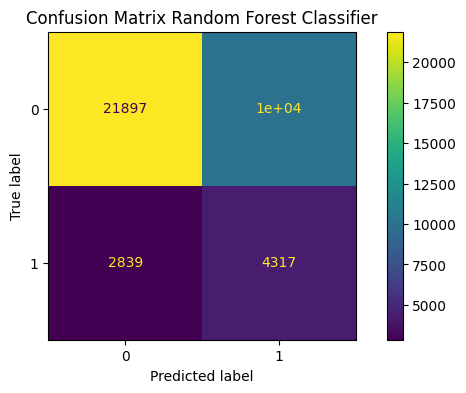

In [0]:
plt.rc('font', size = 10) # Font size
cm = confusion_matrix(y_val_p, RFC_pred_val) # Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 4)) # Fig size

fig = ConfusionMatrixDisplay(confusion_matrix = cm)
fig.plot(cmap = plt.cm.viridis, ax = ax)
ax.set_title('Confusion Matrix Random Forest Classifier')
plt.show()

#### KNN

In [0]:
# Model
KNN_model = KNeighborsClassifier(
    n_neighbors = 7,
    weights = 'distance',
    metric = 'minkowski',
)

In [0]:
# Train
KNN_model.fit(X_train_p, y_train_p)
KNN_pred_train = KNN_model.predict(X_train_p)
KNN_prob_train = KNN_model.predict_proba(X_train_p)[:, 1]

# Metrics training
KNN_acc_train = accuracy_score(y_train_p, KNN_pred_train)
KNN_roc_train = roc_auc_score(y_train_p, KNN_prob_train)

# Validation
KNN_pred_val = KNN_model.predict(X_val_p)
KNN_prob_val = KNN_model.predict_proba(X_val_p)[:, 1]

# Metrics validation
KNN_acc_val = accuracy_score(y_val_p, KNN_pred_val)
KNN_roc_val = roc_auc_score(y_val_p, KNN_prob_val)

# Metrics printing
print(f'The Train Accuracy: {KNN_acc_train:.2f}')
print(f'The Validation Accuracy: {KNN_acc_val:.2f}')
print(f'\nThe Train AUC ROC: {KNN_roc_train:.2f}')
print(f'The Validation AUC ROC: {KNN_roc_val:.2f}')

The Train Accuracy: 1.00
The Validation Accuracy: 0.80

The Train AUC ROC: 1.00
The Validation AUC ROC: 0.63


#### Confusion matrix of validation data

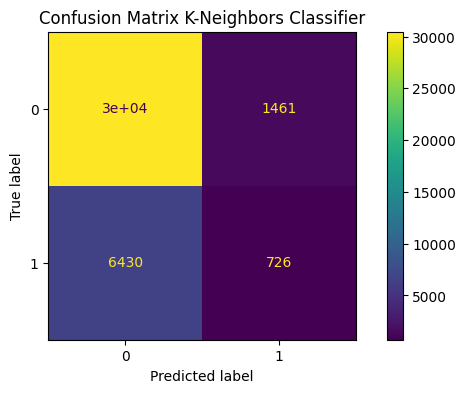

In [0]:
plt.rc('font', size = 10) # Font size
cm = confusion_matrix(y_val_p, KNN_pred_val) # Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 4)) # Fig size

fig = ConfusionMatrixDisplay(confusion_matrix = cm)
fig.plot(cmap = plt.cm.viridis, ax = ax)
ax.set_title('Confusion Matrix K-Neighbors Classifier')
plt.show()

#### Logistic Regression

In [0]:
# Model
LR_model = LogisticRegression(
    class_weight = 'balanced',
    random_state = 33,
)

In [0]:
# Train
LR_model.fit(X_train_p, y_train_p)
LR_pred_train = LR_model.predict(X_train_p)
LR_prob_train = LR_model.predict_proba(X_train_p)[:, 1]

# Metrics training
LR_acc_train = accuracy_score(y_train_p, LR_pred_train)
LR_roc_train = roc_auc_score(y_train_p, LR_prob_train)

# Validation
LR_pred_val = LR_model.predict(X_val_p)
LR_prob_val = LR_model.predict_proba(X_val_p)[:, 1]

# Metrics validation
LR_acc_val = accuracy_score(y_val_p, LR_pred_val)
LR_roc_val = roc_auc_score(y_val_p, LR_prob_val)

# Metrics printing
print(f'The Train Accuracy: {LR_acc_train:.2f}')
print(f'The Validation Accuracy: {LR_acc_val:.2f}')
print(f'\nThe Train AUC ROC: {LR_roc_train:.2f}')
print(f'The Validation AUC ROC: {LR_roc_val:.2f}')

The Train Accuracy: 0.66
The Validation Accuracy: 0.66

The Train AUC ROC: 0.70
The Validation AUC ROC: 0.70


#### Confusion matrix of validation data

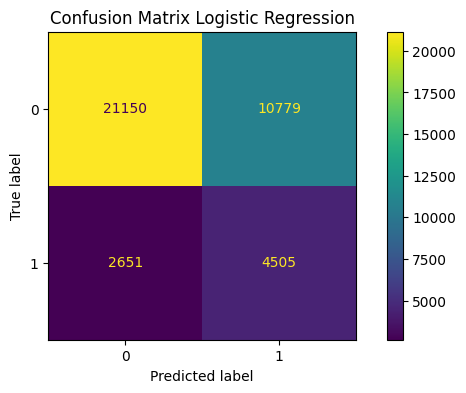

In [0]:
plt.rc('font', size = 10) # Font size
cm = confusion_matrix(y_val_p, LR_pred_val) # Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 4)) # Fig size

fig = ConfusionMatrixDisplay(confusion_matrix = cm)
fig.plot(cmap = plt.cm.viridis, ax = ax)
ax.set_title('Confusion Matrix Logistic Regression')
plt.show()

#### XGBoost

In [0]:
# Calculating the pos_weight
negative_class = sum(y_train_p == 0)
positive_class = sum(y_train_p == 1)
scale_pos_weight = negative_class / positive_class


In [0]:
# Model
XGB_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    scale_pos_weight = scale_pos_weight,
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 33,
)

In [0]:
# Train
XGB_model.fit(X_train_p, y_train_p)
XGB_pred_train = XGB_model.predict(X_train_p)
XGB_prob_train = XGB_model.predict_proba(X_train_p)[:, 1]

# Metrics training
XGB_acc_train = accuracy_score(y_train_p, XGB_pred_train)
XGB_roc_train = roc_auc_score(y_train_p, XGB_prob_train)

# Validation
XGB_pred_val = XGB_model.predict(X_val_p)
XGB_prob_val = XGB_model.predict_proba(X_val_p)[:, 1]

# Metrics validation
XGB_acc_val = accuracy_score(y_val_p, XGB_pred_val)
XGB_roc_val = roc_auc_score(y_val_p, XGB_prob_val)

# Metrics printing
print(f'The Train Accuracy: {XGB_acc_train:.2f}')
print(f'The Validation Accuracy: {XGB_acc_val:.2f}')
print(f'\nThe Train AUC ROC: {XGB_roc_train:.2f}')
print(f'The Validation AUC ROC: {XGB_roc_val:.2f}')

The Train Accuracy: 0.68
The Validation Accuracy: 0.66

The Train AUC ROC: 0.75
The Validation AUC ROC: 0.71


#### Confusion matrix of validation data

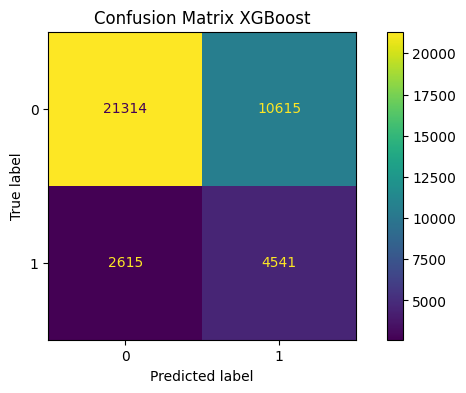

In [0]:
plt.rc('font', size = 10) # Font size
cm = confusion_matrix(y_val_p, XGB_pred_val) # Confusion Matrix
fig, ax = plt.subplots(figsize = (8, 4)) # Fig size

fig = ConfusionMatrixDisplay(confusion_matrix = cm)
fig.plot(cmap = plt.cm.viridis, ax = ax)
ax.set_title('Confusion Matrix XGBoost')
plt.show()

### Pytorch

#### Dataset Class Pytoch

In [0]:
class Dataset(Dataset):

    # Initializing with separate data and labels
    def __init__(self, X_data, y_data):

        # Data and Labels
        self.X_data = X_data
        self.y_data = y_data
    
    # Get item
    def __getitem__(self, idx):

        # Getting the feature and labels
        sample = self.X_data[idx]
        label = self.y_data[idx]

        # Transforming to tensor
        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        return sample, label
    
    # length od dataset
    def __len__(self):
        return len(self.X_data)

#### Adjusting dimensions of training data

In [0]:
# Train

# Transforming labels to a dataset in numpy
y_train_numpy = y_train.to_numpy() 

# Adjusting label dimensions to 2D
y_train_numpy = y_train_numpy[:, np.newaxis]

train_set = Dataset(X_data = X_train_preprocessed, y_data = y_train_numpy)


Checking the data converted to tensors

In [0]:
data, label = train_set[0]
data, label

(tensor([0.0000, 0.1765, 1.0000, 1.0000, 1.0000, 0.2147, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.1304, 0.2534, 0.7902, 0.0577, 0.5471, 0.0722, 0.0167,
         0.0314, 0.0149, 0.3341, 0.4688, 0.3791]),
 tensor([0.]))

#### Checking the size of input and output data

In [0]:
for X, y in train_set:
    print(f'Shape of X_train: {X.shape} {X.dtype}')
    print(f'Shape of y_train: {y.shape} {y.dtype}')
    break

Shape of X_train: torch.Size([23]) torch.float32
Shape of y_train: torch.Size([1]) torch.float32


#### Creating neural network

In [0]:
class Net(nn.Module):

  # Initialize weights
  def initialize_weights(self):

    for layer in self.features:

      if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity = 'relu')
        torch.nn.init.constant_(layer.bias, 0)

    for layer in self.classifier:
      
      if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity = 'relu')
        torch.nn.init.constant_(layer.bias, 0)

  # Net Layers
  def __init__(self, input_layer = 0, output_layer = 0, l1 = 0, l2 = 0 , l3 = 0, drop_p = 0):
    super(Net, self).__init__()
    
    # Features
    self.features = nn.Sequential(

      # Input | Layer 1
      nn.Linear(input_layer, l1),
      nn.BatchNorm1d(l1),
      nn.ReLU(),
      nn.Dropout(p = drop_p),

      # Layer 2
      nn.Linear(l1, l2),
      nn.BatchNorm1d(l2),
      nn.ReLU(),
      nn.Dropout(p = drop_p),

      # Layer 3
      nn.Linear(l2, l3),
      nn.BatchNorm1d(l3),
      nn.ReLU(),
      #nn.Dropout(p = drop_p),
      
    )

    # Classifier
    self.classifier = nn.Sequential(
      # Output Layer
      nn.Linear(l3, output_layer)
    )

    # Initialize weights
    self.initialize_weights()

  # Forward
  def forward(self, X):
    
    X = self.features(X)
    logits = self.classifier(X)
    return logits

In [0]:
# Loading NET

# Input Layer
input_layer = len(train_set[0][0])

# Output Layer
output_layer = 1

# Net
model = Net(input_layer = input_layer, output_layer = output_layer, l1 = 128, l2 = 128, l3 = 128, drop_p = 0.1)
model

Net(
  (features): Sequential(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

#### The train function

In [0]:
def training_net(net, args = {}, f_tuning = 0):

    # Loading Trainset
    trainset = Dataset(X_data = X_train_preprocessed, y_data = y_train_numpy)

    # Spliting trainset and validationset
    train_size = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [train_size, len(trainset) - train_size], 
    )#generator = torch.Generator().manual_seed(33)

    # Distributing the targets
    targets = torch.cat([labels for _, labels in train_subset])
    targets = targets.to(torch.int64)
    class_counts = torch.bincount(targets)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[targets]
    sampler =  WeightedRandomSampler(weights = sample_weights, num_samples = len(sample_weights), replacement = True)
    #sampler = sampler

    # Train Loader 
    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size = args['batch_size'], sampler = sampler, num_workers = args['num_workers'], drop_last = True,
    )
    # Val Loader
    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size = args['batch_size'], shuffle = True, num_workers = args['num_workers'], drop_last = False,
    )

    
    # Device
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    # Possible solution for minority classes
    # Calculate pos_weight
    #all_labels = torch.cat([labels for _, labels in trainloader])
    #num_pos = (all_labels == 1).sum().item()
    #num_neg = (all_labels == 0).sum().item()
    #pos_weight = num_neg / num_pos
    
    # Pos weight tensor
    #pos_weight_tensor = torch.tensor([pos_weight]).to(device)
    #pos_weight = pos_weight_tensor
    
    # Criterion and Optimizer with Fine Tunning
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    # Info training
    print(f'\nThe training parameters and hyperparameters will be: \n{args}')
    print(f'\nThe network will be trained with resources from: ### {device.upper()} ###')
    print(f'\nThis will be the structure of the network to be trained: \n{net}')
    
    if f_tuning <= 0:
        optimizer = optim.Adam(net.parameters(), lr = args['lr'], weight_decay = args['weight_decay'],)
        print(f'\nFine Tunning is OFF: \n{optimizer}')
    else:
        optimizer = optim.Adam([
            {'params': net.features.parameters(), 'lr':args['lr'] * f_tuning, 'weight_decay': args['weight_decay'] * f_tuning},
            {'params': net.classifier.parameters(), 'lr':args['lr'], 'weight_decay': args['weight_decay']},
            ], lr = 0)
        print(f'\nFine Tunning is ON: \n{optimizer}')

    # Metrics for epochs
    avg_loss_train, avg_accuracy_train, avg_auc_train = [], [], []
    avg_loss_val, avg_accuracy_val, avg_auc_val = [], [], []


    # Initialize AUROC and Accuracy for binary classification
    accuracy_train = Accuracy(task = 'binary').to(device)
    accuracy_val = Accuracy(task = 'binary').to(device)
    auc_train = torchmetrics.AUROC(task = 'binary').to(device)
    auc_val = torchmetrics.AUROC(task = 'binary').to(device)

    for epoch in range(0, args['num_epochs']): # Epochs

        print(f'\nEpoch {epoch + 1}\n----------------------------------------------------')

        # Training
        net.train()
        
        # Metrics Training
        train_loss = 0.0
        epoch_steps = 0

        all_preds_train = []
        all_labels_train = []

        for i, data in enumerate(trainloader, 0):

            # Get the inputs; data is a list of [inputs, labels]
            inputs_train, labels_train = data # X and y
            inputs_train, labels_train = inputs_train.to(device), labels_train.to(device)
            
            # Foward Pass
            outputs_train = net(inputs_train)
            loss_train = criterion(outputs_train, labels_train)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward + optimize
            loss_train.backward()
            optimizer.step()

            # Accumulating Predictions 
            all_preds_train.append(torch.sigmoid(outputs_train).detach().cpu())
            all_labels_train.append(labels_train.detach().cpu())

            # Accumulating Loss
            train_loss += loss_train.item()
            epoch_steps += 1

            # Generating an output to follow the batch training
            if i % 100 == 0:
                loss_now, current = loss_train.item(), i * len(inputs_train)
                print(f'Loss: {loss_now:.3f} [{current:>6d} | {len(trainloader.dataset):>6d}]')


        # Calculate AUC-ROC and Accuracy for training
        # Pred x Labels
        all_preds_train = torch.cat(all_preds_train)
        all_labels_train = torch.cat(all_labels_train)

        # Accuracy
        avg_accuracy_train.append(accuracy_train(all_preds_train, all_labels_train.int()).item())

        # AUC
        avg_auc_train.append(auc_train(all_preds_train, all_labels_train.int()).item())

        # Loss
        avg_loss_train.append(train_loss / epoch_steps)

    

        # Metrics validation
        val_loss = 0.0
        val_steps = 0

        all_preds_val = []
        all_labels_val = []

        net.eval()
        for i, data in enumerate(valloader, 0):


            with torch.no_grad():

                # Get the inputs; data is a list of [inputs, labels]
                inputs_val, labels_val = data
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

                # Eval net
                outputs_val = net(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                
                # Accumulating Predictions
                all_preds_val.append(torch.sigmoid(outputs_val).cpu())
                all_labels_val.append(labels_val.cpu())

                # Accumulating Loss
                val_loss += loss_val.item()
                val_steps += 1

        # Calculate AUC-ROC and Accuracy for validation
        # Pred x Labels
        all_preds_val = torch.cat(all_preds_val)
        all_labels_val = torch.cat(all_labels_val)

        # Accuracy
        avg_accuracy_val.append(accuracy_val(all_preds_val, all_labels_val.int()).item())

        # AUC
        avg_auc_val.append(auc_val(all_preds_val, all_labels_val.int()).item())

        # Loss
        avg_loss_val.append(val_loss / val_steps)

      

        print(f'\nTrain Metrics: \nLoss: {avg_loss_train[-1]:.3f} | Accuracy: {avg_accuracy_train[-1]*100:> 0.1f}%  | AUC-ROC: {avg_auc_train[-1]*100:> 0.1f}%')
        
        print(f'\nValidation Metrics: \nLoss: {avg_loss_val[-1]:.3f} | Accuracy: {avg_accuracy_val[-1]*100:> 0.1f}%  | AUC-ROC: {avg_auc_val[-1]*100:> 0.1f}%')


    print('\nFinished Training\nTraining graphics: ')

    # Graphics for Training and Validation
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 4))
    grid_style = dict(alpha = 0.9, linestyle = 'dotted')

    # Loss Convergence
    ax1.plot(avg_loss_train, label = 'Training loss')
    ax1.plot(avg_loss_val, label = 'Validation Loss')
    ax1.set_title('Model convergence - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy Convergence
    ax2.plot(avg_accuracy_train, label = 'Training Accuracy')
    ax2.plot(avg_accuracy_val, label = 'Validation Accuracy')
    ax2.set_title('Model Convergence - Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # AUC-ROC Convergence
    ax3.plot(avg_auc_train, label = 'Training AUC-ROC')
    ax3.plot(avg_auc_val, label = 'Validation AUC-ROC')
    ax3.set_title('Model Convergence - AUC-ROC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC-ROC')
    ax3.legend()
    ax3.grid(True)

    plt.show()

    return all_preds_val, all_labels_val

#### Training ---

#### Parameters and Hyperparamenters

In [0]:
# Parameters and Hyperparamenters
args = {
    'num_workers': 2,
    'batch_size': 256,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 33, 
}


The training parameters and hyperparameters will be: 
{'num_workers': 2, 'batch_size': 256, 'lr': 0.0001, 'weight_decay': 0.0005, 'num_epochs': 33}

The network will be trained with resources from: ### CPU ###

This will be the structure of the network to be trained: 
Net(
  (features): Sequential(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

Fine Tunning is OF

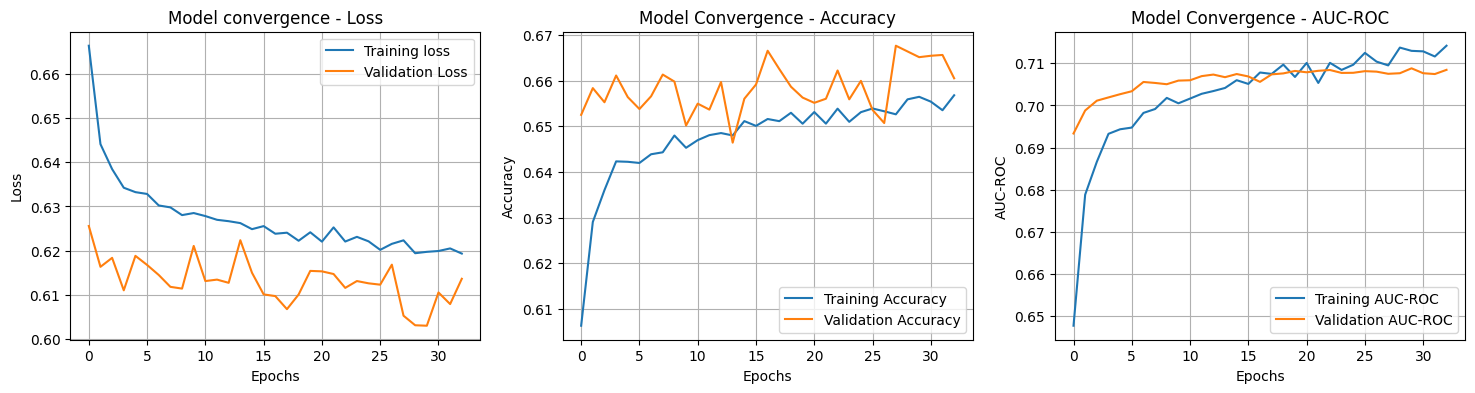

In [0]:
predicted, labels = training_net(model, args)

#### Training scores with validation data

In [0]:
target = labels
preds = predicted
metric_collection = MetricCollection([
    BinaryAUROC(), 
    BinaryAccuracy(),
    BinaryRecall(), 
    BinaryF1Score(),
])

print(metric_collection(preds, target))

{'BinaryAUROC': tensor(0.7085), 'BinaryAccuracy': tensor(0.6605), 'BinaryRecall': tensor(0.6270), 'BinaryF1Score': tensor(0.4040)}


#### Confusion matrix

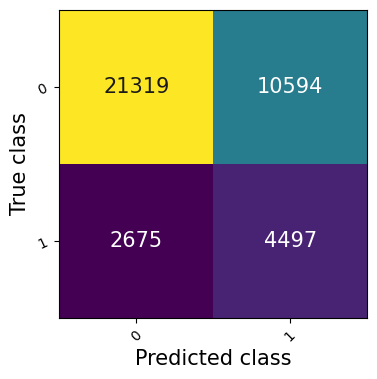

In [0]:
plt.rc('font', size = 10)
fig, ax= plt.subplots(figsize = (8, 4))
ax.grid(False)
metric = BinaryConfusionMatrix()
metric(predicted, labels)
fig_, ax_ = metric.plot(cmap = 'viridis', ax = ax)

# 5-Evaluation

In [0]:
data_scores = {
    'model': ['RFC', 'KNN', 'LR', 'XGB', 'PyTorch'],
    'roc_train': [0.76, 1.00, 0.70, 0.75, 0.71], 
    'roc_val': [0.70, 0.63, 0.70, 0.71, 0.71], 
    'acc_train': [0.69, 1.00, 0.66, 0.68, 0.66], 
    'acc_val': [0.67, 0.80, 0.66, 0.66, 0.66], 
}
df_scores = pd.DataFrame(data_scores)

In [0]:
df_scores

,model,roc_train,roc_val,acc_train,acc_val
0,RFC,0.76,0.70,0.69,0.67
1,KNN,1.00,0.63,1.00,0.80
2,LR,0.70,0.70,0.66,0.66
3,XGB,0.75,0.71,0.68,0.66
4,PyTorch,0.71,0.71,0.66,0.66


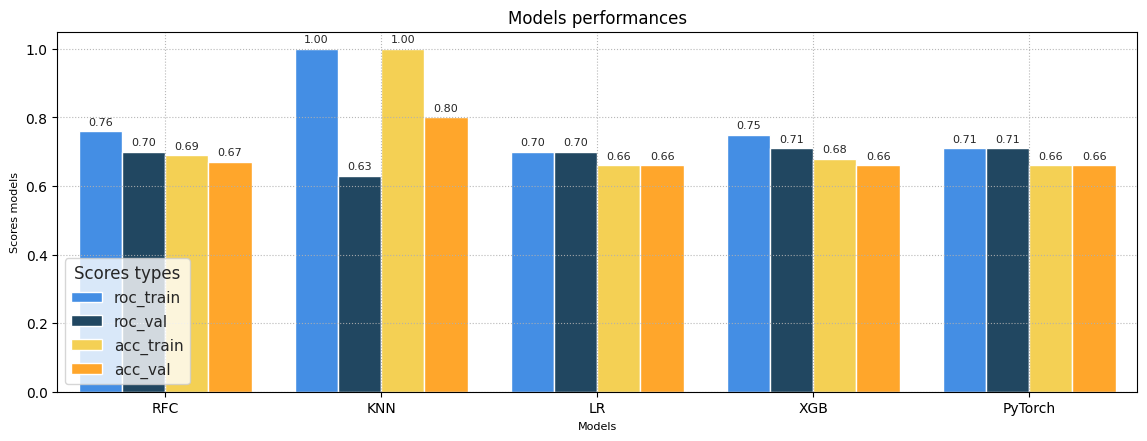

In [0]:
# Data colect
data_ax = pd.melt(
    df_scores, 
    id_vars = ['model'], 
    value_vars = ['roc_train', 'roc_val', 'acc_train', 'acc_val'],
    var_name = 'type_score', value_name = 'score',
)

# Figure

# Color

palette = ['#448ee4', '#214761', '#f4d054', '#ffa62b']

# Size fonts
plt.rc('font', size = 8)
plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 8)
plt.rc('legend', fontsize = 8)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

# Subplots
fig, ax = plt.subplots(figsize = (12, 4))
grid_style = dict(alpha = 0.9, linestyle = 'dotted')

# Barplot

barplot = sns.barplot(
    data = data_ax, 
    x = 'model', 
    y = 'score',
    hue = 'type_score',
    dodge = True,
    palette = palette,
    edgecolor = 'white',
    saturation = 1,
    ax = ax,
)

# Config figure
sns.set(style = 'whitegrid')
ax.grid(axis = 'y', which = 'major', **grid_style)
ax.grid(axis = 'x', which = 'major', **grid_style)
ax.set_title('Models performances')
ax.set_xlabel('Models')
ax.set_ylabel('Scores models')
ax.legend(title = 'Scores types', loc = 'lower left', )

# Adding values ​​to the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 8)

# Adjusting the margins
plt.subplots_adjust(left = 0.05, right = 0.95, top = 0.95, bottom = 0.05)

# Show
plt.show()


### Considerations on initial training:

At this stage of the project, some models were tested to verify the performance of the data in different algorithms.

* I used the following models:

  * Random Forest Classifier - RFC

  * K-Nearest Neighbors - KNN

  * Logistic Regression – LR

  * XGBoost

  * PyTorch

* From the beginning, the project was based on building a model in **PyTorch** for credit risk classifications, but it makes a lot of sense to test different algorithms to compare them and understand the main characteristics of our data.

* The metric that best fits the resolution of our problem will be **ROC-AUC**, because as it is a dataset with minority classes and binary classification, this metric takes into account the true classifications. In datasets with minority classes, it is natural for the models to present a greater number of false positives and false negatives.

* Still talking about the metric that will be used to evaluate the performance of the models, we can also consider the context of the problem to be solved. Since this is a credit risk analysis model, it is important that both classifications, both the **negative classes: 0 - (loans classified as paid)** and the **positive classes: 1 - (loans classified as unpaid)**, are classified using the same criteria, taking into account that an incorrect classification on both sides can reflect a significant loss for the institution. In the background, the **Accuracy** of each model will also be analyzed, aiming to have a satisfactory and adequate forecast for the loans.

* An initial training was carried out on all the models above to compare and analyze the results. In these initial trainings, I considered the imbalance of the classes in the data set and understood that it would be more appropriate to use the resources of each algorithm to deal with this imbalanced data.

##### Random Forest Classifier - RFC: 
  
* The parameter *class_weight='balanced'* was used to balance the imbalance of classes. 

* The model performed well in both **AUC-ROC** and **Accuracy** metrics, both in the *training and validation data*, with a well-balanced confusion matrix.


##### K-Nearest Neighbors - KNN: 
  
* The parameter *weights='distance'* was used to balance the class imbalance. 

* The model performed well in both **AUC-ROC** and **Accuracy** metrics, *but only in the training data*. 

* The performance in the *validation data* did not produce the same result, indicating a slight **Overfitting**. As a result, the *confusion matrix became unbalanced*, with a very good classification for the positive classes, but poor for the negative classes. 

* In our confusion matrix, we can see that we have a very large number of **false negatives**, which is not good for a model, and an *Accuracy of the negative classes close to 11%*, **which indicates that the model is not capable of making predictions in this class**.

##### Logistic Regression: 

* The parameter *class_weight='balanced'* was used to balance the class imbalance. 

* The model performed well in both **AUC-ROC** and **Accuracy metrics**, both in *training and validation data*, with a well-balanced confusion matrix. However, **Accuracy**, although satisfactory, *was slightly lower compared to the other models*.

##### XGBoost: 

* The *scale_pos_weight* parameter was used to balance class imbalance. 

* The model performed well in both **AUC-ROC** and **Accuracy** metrics, both in *training and validation data*, with a well-balanced confusion matrix.

##### PyTorch: 

* I chose a different approach, using the **DataLoader** feature, a tool responsible for organizing the data into training batches. 

* In the *training data*, the **sampler** function was used, which generates a *specific weight for each class according to its distribution*. In other words, minority classes will have higher weights and majority classes, lower weights. Thus, the **DataLoader** will select the data according to the weights, generating a balance in the assembly of batches for training. For example, a batch of size 32 will have 16 negative classes and 16 positive classes. 

* In the *validation data*, the default configuration was used to assemble the batches, with the parameter *shuffle=True*, where the data is shuffled **randomly**, regardless of the classes. This ensures unbiased validation, allowing an assertive and real analysis of the model's performance on the validation data.

* I also considered using **pos_weight** to generate a balance in the minority classes. The pos_weight is a parameter of **BCEWithLogitsLoss** that adjusts the error penalty according to the weight of the minority classes. However, compared to the two methods, using the sampler in DataLoader demonstrated, in the initial training, *better performance and compatibility with the training and validation data*.

* The model performed well in both **AUC-ROC** and **Accuracy metrics**, both in training and validation data, with a well-balanced confusion matrix.

* Of the trained models, I will be choosing PyTorch, as it obtained a satisfactory AUC-ROC and Accuracy score. I believe that, since it is a neural network, it provides us with several tools so that the model can **generalize** all the data in this training set, facilitating predictions of both test data and future data that may be received by the institution.

* I chose to include the **weight decay** (L2 Regularization) and **dropout** parameters to have a more robust network that is more likely to deal well with the *variation of new data and records*.

* The **weight decay** helps prevent very large weight adjustments, regularizing the values ​​directly. *This prevents overfitting and also makes the model have a more stable adjustment with the training data*.

* The **dropout** adds uncertainty to the training, making the model more robust to data variability, as it randomly turns off a portion of the neurons during the training epochs, forcing the network to not depend specifically on just one neuron,*promoting more distributed learning*.

* To better adjust this model, I will be performing **HyperTuning** to adjust the number of neurons in each layer and the other hyperparameters present in this network, aiming to maintain good generalization of the data and good performance of the metrics mentioned above.

### HyperTunning

### Data loaders

* We wrap the data loaders in their own function and pass a global data directory. This way we can share a data directory between different trials.

In [0]:
def load_data(data_dir = './'):

    # Loading Train set
    trainset = Dataset(X_data = X_train_preprocessed, y_data = y_train_numpy)

    # Spliting trainset and validationset
    train_size = int(len(trainset) * 0.8)
    val_size = int(len(trainset) - train_size)


    train_subset, val_subset = random_split(
        trainset, [train_size, val_size]
    )
    
    return train_subset, val_subset

### Configurable neural network

In [0]:
class Net_Hyper(nn.Module):

  # Initialize weights
  def initialize_weights(self):

    for layer in self.features:

      if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity = 'relu')
        torch.nn.init.constant_(layer.bias, 0)

    for layer in self.classifier:
      
      if isinstance(layer, nn.Linear):
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity = 'relu')
        torch.nn.init.constant_(layer.bias, 0)

  # Net Layers
  def __init__(self, l1 = 64, l2 = 64 , l3 = 64, drop_p = 0.10, input_layer = len(train_set[0][0]), output_layer = 1, ):
    super(Net_Hyper, self).__init__()
    
    # Features
    self.features = nn.Sequential(

      # Input | Layer 1
      nn.Linear(input_layer, l1),
      nn.BatchNorm1d(l1),
      nn.ReLU(),
      nn.Dropout(p = drop_p),

      # Layer 2
      nn.Linear(l1, l2),
      nn.BatchNorm1d(l2),
      nn.ReLU(),
      nn.Dropout(p = drop_p),

      # Layer 3
      nn.Linear(l2, l3),
      nn.BatchNorm1d(l3),
      nn.ReLU(),
      #nn.Dropout(p = drop_p),

    )

    # Classifier
    self.classifier = nn.Sequential(
      # Output Layer
      nn.Linear(l3, output_layer)
    )

    # Initialize weights
    self.initialize_weights()

  # Forward
  def forward(self, X):
    
    X = self.features(X)
    logits = self.classifier(X)
    return logits
  

In [0]:
net = Net_Hyper()
print(net)

Net_Hyper(
  (features): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)


### The train function

In [0]:
def train_hyper(config, data_dir = None):
    
    # Net 
    net = Net_Hyper(config['l1'], config['l2'], config['l3'])

    # Cheking device
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    # Criterion | Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr = config['lr'], weight_decay = 5e-4)


    # Check Point
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / 'data.pkl'
            with open(data_path, 'rb') as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state['epoch']
            net.load_state_dict(checkpoint_state['net_state_dict'])
            optimizer.load_state_dict(checkpoint_state['optimizer_state_dict'])
    else:
        start_epoch = 0

    # Load train_set and val_set
    trainset, valset = load_data(data_dir)

    # Applying the sampler function to the training data for class balancing
    # Distributing the targets
    targets = torch.cat([labels for _, labels in trainset])
    targets = targets.to(torch.int64)
    class_counts = torch.bincount(targets)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[targets]
    sampler =  WeightedRandomSampler(weights = sample_weights, num_samples = len(sample_weights), replacement = True)

    # DataLoader
    # Train loader
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size = int(config['batch_size']), sampler = sampler, num_workers = 2, drop_last= True,
    )
    # Val loader
    valloader = torch.utils.data.DataLoader(
        valset, batch_size = int(config['batch_size']), shuffle = True, num_workers = 2, drop_last= False,
    )

    # Loop over the dataset multiple times
    for epoch in range(start_epoch, 50):

        # Training
        net.train()

        # Metrics training
        running_loss = 0.0 
        epoch_steps = 0

        for i, data in enumerate(trainloader, 0):

            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data # X and y
            inputs, labels = inputs.to(device), labels.to(device)

            # Foward Pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999: #print every 2000 mini-batches
                print(
                    '[%d, %5d] loss: %.3f'
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0
        
        # Validation
        # Metrics for epochs
        avg_loss, avg_accuracy, avg_auc = [], [], []


        # Initialize AUROC and Accuracy for binary classification
        accuracy_val = Accuracy(task = 'binary').to(device)
        auc_val = torchmetrics.AUROC(task = 'binary').to(device)

        # Metrics validation
        val_loss = 0.0
        val_steps = 0

        all_preds = []
        all_labels = []

        # Net eval
        net.eval()
        for i, data in enumerate(valloader, 0):

            with torch.no_grad():
                
                # Get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels =  inputs.to(device), labels.to(device)

                # Eval net
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # Accumulating Predictions
                all_preds.append(torch.sigmoid(outputs).cpu())
                all_labels.append(labels.cpu())
                
                # Accumulating Loss
                val_loss += loss.item()
                val_steps += 1

        # Calculate AUC-ROC and Accuracy for validation
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Accuracy
        avg_accuracy.append(accuracy_val(all_preds, all_labels.int()).item()) 

        # AUC
        avg_auc.append(auc_val(all_preds, all_labels.int()).item())

        # Loss
        avg_loss.append(val_loss / val_steps)

        # Checkpoint
        checkpoint_data = {
            'epoch': epoch,
            'net_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / 'data.pkl'
            with open(data_path, 'wb') as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {'loss': avg_loss[-1], 'accuracy': avg_accuracy[-1], 'auc_roc': avg_auc[-1]},
                checkpoint = checkpoint,
            )
    
    print('Finished Training')

### Test set accuracy

In [0]:
def test_hyper(net, device = 'cpu'):

    # Loading Dataset
    train_set, valset = load_data()

    # DataLoader
    testloader = torch.utils.data.DataLoader(
        valset, batch_size = 4, shuffle = False, num_workers = 2
    )

    # Criterion
    criterion = nn.BCEWithLogitsLoss()

    # Test
    # Metrics for epochs
    avg_loss, avg_accuracy, avg_auc = [], [], []


    # Initialize AUROC and Accuracy for binary classification
    accuracy_test = Accuracy(task = 'binary').to(device)
    auc_test = torchmetrics.AUROC(task = 'binary').to(device)

    # Metrics validation
    test_loss = 0.0
    test_steps = 0

    all_preds = []
    all_labels = []

    # Net eval
    net.eval()
    for i, data in enumerate(testloader, 0):

        with torch.no_grad():

            inputs, labels = data
            inputs, labels =  inputs.to(device), labels.to(device)

            # Eval net
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Accumulating Predictions
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

            # Accumulating Loss
            test_loss += loss.item()
            test_steps += 1

    # Calculate AUC-ROC and Accuracy for validation
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Accuracy
    avg_accuracy.append(accuracy_test(all_preds, all_labels.int()).item()) 

    # AUC
    avg_auc.append(auc_test(all_preds, all_labels.int()).item())

    # Loss
    avg_loss.append(test_loss / test_steps)

    return avg_loss, avg_accuracy, avg_auc

### Configuring the search space

In [0]:
def main(num_samples = 50, max_num_epochs = 50, gpus_per_trial = 2):
    
    # Setting directory
    data_dir = os.path.abspath('./')
    load_data(data_dir)

    # Config hyperparameters
    config = {
        'l1': tune.choice([2 ** i for i in range(9)]), 
        'l2': tune.choice([2 ** i for i in range(9)]),
        'l3': tune.choice([2 ** i for i in range(9)]),
        'lr': tune.loguniform(1e-5, 1e-3),
        'batch_size': tune.choice([128, 256, 512]),
    }


    # Adjusting metric to be minimized
    scheduler = ASHAScheduler(
        metric = 'auc_roc',
        mode = 'max', 
        max_t = max_num_epochs, 
        grace_period = 5,
        reduction_factor = 2,
    )

    # Result
    result = tune.run(
        partial(train_hyper, data_dir = data_dir),
        resources_per_trial = {'cpu': 2, 'gpu': gpus_per_trial},
        config = config,
        num_samples =  num_samples, 
        scheduler = scheduler,
    )


    # Printing results
    best_trial = result.get_best_trial('loss', 'min', 'last')
    print(f"Best trial config: {best_trial.config}")
    print(f"\nBest trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")
    print(f"Best trial final validation auc_roc: {best_trial.last_result['auc_roc']}")

    best_trained_model = Net_Hyper(best_trial.config['l1'], best_trial.config['l2'], best_trial.config['l3'])
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda:0'
        if gpus_per_trial > 1:
            best_trained_model == nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    # BestCheckpoint
    best_checkpoint = result.get_best_checkpoint(trial = best_trial, metric = 'loss', mode = 'min')
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / 'data.pkl'
        with open(data_path, 'rb') as fp:
            best_checkpoint_data = pickle.load(fp)
    
    best_trained_model.load_state_dict(best_checkpoint_data['net_state_dict'])
    test_loss, test_acc, test_roc = test_hyper(best_trained_model, device)
    print(f'\nBest trial test set loss: {test_loss}')
    print(f'Best trial test set accuracy: {test_acc}')
    print(f'Best trial test set auc_roc:{test_roc}')

# Main

if __name__  == '__main__':
    main(num_samples = 30, max_num_epochs = 50, gpus_per_trial = 0)

2024-11-28 08:19:31,465	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-28 08:19:33,378	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     train_hyper_2024-11-28_08-19-33   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 30                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_hyper_2024-11-28_08-19-33
To visualize your results with TensorBoard, run: `tensorboard --logdir /local_disk0/tmp/ray/session_2024-11-28_08-19-28_875118_6646/artifacts/2024-11-28_08-19-33/train_hyper_2024-11-28_08-19-33/driver_artifacts`
(raylet) Warning: The actor ImplicitFunc is very large (71 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray ob

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000000)



Trial train_hyper_7fd20_00000 finished iteration 2 at 2024-11-28 08:20:22. Total running time: 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.26976 |
| time_total_s                                      15.12947 |
| training_iteration                                       2 |
| accuracy                                           0.44828 |
| auc_roc                                            0.52236 |
| loss                                               0.68967 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-1

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000001)



Trial train_hyper_7fd20_00000 finished iteration 3 at 2024-11-28 08:20:29. Total running time: 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.34258 |
| time_total_s                                      21.47205 |
| training_iteration                                       3 |
| accuracy                                           0.44708 |
| auc_roc                                            0.52915 |
| loss                                               0.69563 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-1

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000002)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:20:30. Total running time: 55s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256        3            21.4721   0.695628     0.447077    0.529148 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128       

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000003)



Trial train_hyper_7fd20_00000 finished iteration 5 at 2024-11-28 08:20:41. Total running time: 1min 6s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.35288 |
| time_total_s                                      34.18019 |
| training_iteration                                       5 |
| accuracy                                           0.45271 |
| auc_roc                                             0.5376 |
| loss                                               0.69658 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000004)



Trial train_hyper_7fd20_00000 finished iteration 6 at 2024-11-28 08:20:48. Total running time: 1min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.21221 |
| time_total_s                                       40.3924 |
| training_iteration                                       6 |
| accuracy                                           0.44974 |
| auc_roc                                            0.54234 |
| loss                                                0.6987 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000005)



Trial train_hyper_7fd20_00000 finished iteration 7 at 2024-11-28 08:20:54. Total running time: 1min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   6.44681 |
| time_total_s                                      46.83922 |
| training_iteration                                       7 |
| accuracy                                           0.45148 |
| auc_roc                                            0.54613 |
| loss                                               0.69639 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000006)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:21:00. Total running time: 1min 25s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256        7            46.8392   0.696393     0.451478    0.546126 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000007)



Trial train_hyper_7fd20_00000 finished iteration 9 at 2024-11-28 08:21:08. Total running time: 1min 33s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   7.03813 |
| time_total_s                                      60.41535 |
| training_iteration                                       9 |
| accuracy                                           0.45304 |
| auc_roc                                            0.55265 |
| loss                                               0.69853 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000008)



Trial train_hyper_7fd20_00000 finished iteration 10 at 2024-11-28 08:21:15. Total running time: 1min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.88851 |
| time_total_s                                      67.30386 |
| training_iteration                                      10 |
| accuracy                                           0.45798 |
| auc_roc                                            0.55598 |
| loss                                               0.69829 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000009)



Trial train_hyper_7fd20_00000 finished iteration 11 at 2024-11-28 08:21:21. Total running time: 1min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                    6.5278 |
| time_total_s                                      73.83166 |
| training_iteration                                      11 |
| accuracy                                           0.45199 |
| auc_roc                                            0.56042 |
| loss                                               0.70045 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000010)



Trial train_hyper_7fd20_00000 finished iteration 12 at 2024-11-28 08:21:28. Total running time: 1min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   6.64634 |
| time_total_s                                        80.478 |
| training_iteration                                      12 |
| accuracy                                           0.45954 |
| auc_roc                                            0.56306 |
| loss                                               0.69865 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000011)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:21:30. Total running time: 1min 55s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       12             80.478   0.698654     0.459537    0.563056 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000012)



Trial train_hyper_7fd20_00000 finished iteration 14 at 2024-11-28 08:21:41. Total running time: 2min 6s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   7.12892 |
| time_total_s                                      94.05445 |
| training_iteration                                      14 |
| accuracy                                           0.46852 |
| auc_roc                                            0.57081 |
| loss                                               0.69521 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-2

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000013)



Trial train_hyper_7fd20_00000 finished iteration 15 at 2024-11-28 08:21:48. Total running time: 2min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   6.39037 |
| time_total_s                                     100.44483 |
| training_iteration                                      15 |
| accuracy                                           0.47456 |
| auc_roc                                            0.57282 |
| loss                                               0.69259 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000014)



Trial train_hyper_7fd20_00000 finished iteration 16 at 2024-11-28 08:21:54. Total running time: 2min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                   6.24075 |
| time_total_s                                     106.68557 |
| training_iteration                                      16 |
| accuracy                                           0.69264 |
| auc_roc                                            0.57741 |
| loss                                               0.69371 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000015)



Trial train_hyper_7fd20_00000 finished iteration 17 at 2024-11-28 08:22:00. Total running time: 2min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   6.33353 |
| time_total_s                                      113.0191 |
| training_iteration                                      17 |
| accuracy                                           0.69702 |
| auc_roc                                            0.58224 |
| loss                                               0.69083 |
+------------------------------------------------------------+

Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:22:00. Total running time: 2min 25s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000016)



Trial train_hyper_7fd20_00000 finished iteration 18 at 2024-11-28 08:22:07. Total running time: 2min 32s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                   6.66426 |
| time_total_s                                     119.68335 |
| training_iteration                                      18 |
| accuracy                                           0.70966 |
| auc_roc                                            0.58708 |
| loss                                               0.68831 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000017)



Trial train_hyper_7fd20_00000 finished iteration 19 at 2024-11-28 08:22:13. Total running time: 2min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   6.46734 |
| time_total_s                                     126.15069 |
| training_iteration                                      19 |
| accuracy                                           0.70986 |
| auc_roc                                            0.59151 |
| loss                                               0.68699 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000018)



Trial train_hyper_7fd20_00000 finished iteration 20 at 2024-11-28 08:22:20. Total running time: 2min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   6.56466 |
| time_total_s                                     132.71535 |
| training_iteration                                      20 |
| accuracy                                           0.70426 |
| auc_roc                                            0.59751 |
| loss                                               0.68718 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000019)



Trial train_hyper_7fd20_00000 finished iteration 21 at 2024-11-28 08:22:26. Total running time: 2min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                    6.3045 |
| time_total_s                                     139.01985 |
| training_iteration                                      21 |
| accuracy                                           0.70229 |
| auc_roc                                             0.6011 |
| loss                                               0.68865 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000020)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:22:30. Total running time: 2min 55s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       21             139.02   0.688647      0.70229    0.601099 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000021)



Trial train_hyper_7fd20_00000 finished iteration 23 at 2024-11-28 08:22:39. Total running time: 3min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                   6.56325 |
| time_total_s                                     151.98536 |
| training_iteration                                      23 |
| accuracy                                           0.70802 |
| auc_roc                                            0.60664 |
| loss                                               0.68209 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-2

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000022)



Trial train_hyper_7fd20_00000 finished iteration 24 at 2024-11-28 08:22:46. Total running time: 3min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   6.34341 |
| time_total_s                                     158.32877 |
| training_iteration                                      24 |
| accuracy                                           0.70232 |
| auc_roc                                            0.61106 |
| loss                                               0.68284 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000023)



Trial train_hyper_7fd20_00000 finished iteration 25 at 2024-11-28 08:22:52. Total running time: 3min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                   6.31273 |
| time_total_s                                     164.64149 |
| training_iteration                                      25 |
| accuracy                                           0.70234 |
| auc_roc                                            0.61467 |
| loss                                               0.68197 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000024)



Trial train_hyper_7fd20_00000 finished iteration 26 at 2024-11-28 08:22:58. Total running time: 3min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   6.25147 |
| time_total_s                                     170.89296 |
| training_iteration                                      26 |
| accuracy                                           0.70643 |
| auc_roc                                             0.6165 |
| loss                                               0.67756 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000025)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:23:00. Total running time: 3min 25s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       26            170.893   0.677563     0.706435    0.616496 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000026)



Trial train_hyper_7fd20_00000 finished iteration 28 at 2024-11-28 08:23:11. Total running time: 3min 36s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   6.66803 |
| time_total_s                                     184.12737 |
| training_iteration                                      28 |
| accuracy                                           0.70145 |
| auc_roc                                            0.62425 |
| loss                                               0.67338 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000027)



Trial train_hyper_7fd20_00000 finished iteration 29 at 2024-11-28 08:23:18. Total running time: 3min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   6.63801 |
| time_total_s                                     190.76539 |
| training_iteration                                      29 |
| accuracy                                             0.704 |
| auc_roc                                            0.62597 |
| loss                                               0.67292 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000028)



Trial train_hyper_7fd20_00000 finished iteration 30 at 2024-11-28 08:23:24. Total running time: 3min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                   6.33831 |
| time_total_s                                      197.1037 |
| training_iteration                                      30 |
| accuracy                                           0.70661 |
| auc_roc                                            0.62847 |
| loss                                               0.66778 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000029)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:23:31. Total running time: 3min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)      loss     accuracy     auc_roc |
+-----------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       30            197.104   0.66778     0.706614     0.62847 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128       

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000030)



Trial train_hyper_7fd20_00000 finished iteration 32 at 2024-11-28 08:23:37. Total running time: 4min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                    6.2177 |
| time_total_s                                     209.71133 |
| training_iteration                                      32 |
| accuracy                                             0.704 |
| auc_roc                                            0.63431 |
| loss                                               0.66755 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-2

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000031)



Trial train_hyper_7fd20_00000 finished iteration 33 at 2024-11-28 08:23:44. Total running time: 4min 9s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   6.67905 |
| time_total_s                                     216.39038 |
| training_iteration                                      33 |
| accuracy                                           0.70232 |
| auc_roc                                            0.63682 |
| loss                                               0.66484 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-2

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000032)



Trial train_hyper_7fd20_00000 finished iteration 34 at 2024-11-28 08:23:50. Total running time: 4min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   6.33539 |
| time_total_s                                     222.72576 |
| training_iteration                                      34 |
| accuracy                                           0.70569 |
| auc_roc                                            0.63738 |
| loss                                               0.66512 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000033)



Trial train_hyper_7fd20_00000 finished iteration 35 at 2024-11-28 08:23:57. Total running time: 4min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   6.53096 |
| time_total_s                                     229.25672 |
| training_iteration                                      35 |
| accuracy                                           0.70429 |
| auc_roc                                            0.63962 |
| loss                                               0.66628 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000034)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:24:01. Total running time: 4min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       35            229.257   0.666276     0.704286    0.639618 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000035)



Trial train_hyper_7fd20_00000 finished iteration 37 at 2024-11-28 08:24:10. Total running time: 4min 35s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   6.99614 |
| time_total_s                                     242.68422 |
| training_iteration                                      37 |
| accuracy                                           0.70516 |
| auc_roc                                            0.64304 |
| loss                                                0.6614 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000036)



Trial train_hyper_7fd20_00000 finished iteration 38 at 2024-11-28 08:24:17. Total running time: 4min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   6.49534 |
| time_total_s                                     249.17956 |
| training_iteration                                      38 |
| accuracy                                           0.70493 |
| auc_roc                                            0.64429 |
| loss                                               0.66086 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000037)



Trial train_hyper_7fd20_00000 finished iteration 39 at 2024-11-28 08:24:23. Total running time: 4min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   6.27768 |
| time_total_s                                     255.45724 |
| training_iteration                                      39 |
| accuracy                                           0.69873 |
| auc_roc                                            0.64638 |
| loss                                               0.66351 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000038)



Trial train_hyper_7fd20_00000 finished iteration 40 at 2024-11-28 08:24:29. Total running time: 4min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                   6.50565 |
| time_total_s                                     261.96289 |
| training_iteration                                      40 |
| accuracy                                           0.70388 |
| auc_roc                                            0.64616 |
| loss                                               0.66035 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000039)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:24:31. Total running time: 4min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       40            261.963   0.660352     0.703876     0.64616 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000040)



Trial train_hyper_7fd20_00000 finished iteration 42 at 2024-11-28 08:24:43. Total running time: 5min 8s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                   6.51039 |
| time_total_s                                     275.08827 |
| training_iteration                                      42 |
| accuracy                                           0.70198 |
| auc_roc                                            0.64901 |
| loss                                                0.6599 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-2

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000041)



Trial train_hyper_7fd20_00000 finished iteration 43 at 2024-11-28 08:24:49. Total running time: 5min 14s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   6.37216 |
| time_total_s                                     281.46043 |
| training_iteration                                      43 |
| accuracy                                            0.7058 |
| auc_roc                                            0.64912 |
| loss                                               0.65318 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000042)



Trial train_hyper_7fd20_00000 finished iteration 44 at 2024-11-28 08:24:55. Total running time: 5min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   6.44209 |
| time_total_s                                     287.90252 |
| training_iteration                                      44 |
| accuracy                                           0.70206 |
| auc_roc                                            0.65071 |
| loss                                               0.65838 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000043)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:25:01. Total running time: 5min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       44            287.903   0.658381      0.70206    0.650709 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000044)



Trial train_hyper_7fd20_00000 finished iteration 46 at 2024-11-28 08:25:10. Total running time: 5min 35s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   7.23158 |
| time_total_s                                     302.21012 |
| training_iteration                                      46 |
| accuracy                                            0.6973 |
| auc_roc                                            0.65366 |
| loss                                               0.65921 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000045)



Trial train_hyper_7fd20_00000 finished iteration 47 at 2024-11-28 08:25:16. Total running time: 5min 41s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   6.54594 |
| time_total_s                                     308.75607 |
| training_iteration                                      47 |
| accuracy                                           0.70147 |
| auc_roc                                            0.65343 |
| loss                                               0.65432 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000046)



Trial train_hyper_7fd20_00000 finished iteration 48 at 2024-11-28 08:25:23. Total running time: 5min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   6.91749 |
| time_total_s                                     315.67356 |
| training_iteration                                      48 |
| accuracy                                            0.6984 |
| auc_roc                                            0.65424 |
| loss                                               0.65423 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000047)



Trial train_hyper_7fd20_00000 finished iteration 49 at 2024-11-28 08:25:30. Total running time: 5min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   6.40685 |
| time_total_s                                     322.08041 |
| training_iteration                                      49 |
| accuracy                                           0.69684 |
| auc_roc                                             0.6555 |
| loss                                               0.65462 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00000 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000048)



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-11-28 08:25:31. Total running time: 5min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   RUNNING       2      4      2   1.95684e-05            256       49             322.08   0.654621      0.69684    0.655503 |
| train_hyper_7fd20_00001   PENDING       4    256      8   2.1644e-05             256                                                                 |
| train_hyper_7fd20_00002   PENDING      16     64    128   0.000534068            128  

(func pid=7839) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00000_0_batch_size=256,l1=2,l2=4,l3=2,lr=0.0000_2024-11-28_08-19-49/checkpoint_000049)



Trial train_hyper_7fd20_00001 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00001 config           |
+------------------------------------------------+
| batch_size                                 256 |
| l1                                           4 |
| l2                                         256 |
| l3                                           8 |
| lr                                       2e-05 |
+------------------------------------------------+

Trial train_hyper_7fd20_00001 finished iteration 1 at 2024-11-28 08:25:55. Total running time: 6min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   9.89768 |
| time_total_s                                       9.89768 |

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000000)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:26:01. Total running time: 6min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256        1            9.89768   0.652908     0.562006    0.55588  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50          328.572     0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000001)



Trial train_hyper_7fd20_00001 finished iteration 2 at 2024-11-28 08:26:02. Total running time: 6min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.67693 |
| time_total_s                                      16.57461 |
| training_iteration                                       2 |
| accuracy                                           0.59442 |
| auc_roc                                            0.58147 |
| loss                                               0.65125 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000002)



Trial train_hyper_7fd20_00001 finished iteration 4 at 2024-11-28 08:26:17. Total running time: 6min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.97792 |
| time_total_s                                      31.32356 |
| training_iteration                                       4 |
| accuracy                                           0.60857 |
| auc_roc                                            0.61394 |
| loss                                               0.64863 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000003)



Trial train_hyper_7fd20_00001 finished iteration 5 at 2024-11-28 08:26:24. Total running time: 6min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   7.05383 |
| time_total_s                                      38.37739 |
| training_iteration                                       5 |
| accuracy                                           0.60709 |
| auc_roc                                            0.62123 |
| loss                                               0.65068 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000004)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:26:31. Total running time: 6min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256        5            38.3774   0.650678     0.607087    0.621233 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000005)



Trial train_hyper_7fd20_00001 finished iteration 7 at 2024-11-28 08:26:39. Total running time: 7min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   7.31399 |
| time_total_s                                      53.25879 |
| training_iteration                                       7 |
| accuracy                                           0.60154 |
| auc_roc                                            0.63266 |
| loss                                               0.65283 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-2

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000006)



Trial train_hyper_7fd20_00001 finished iteration 8 at 2024-11-28 08:26:47. Total running time: 7min 12s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   7.91774 |
| time_total_s                                      61.17653 |
| training_iteration                                       8 |
| accuracy                                           0.60988 |
| auc_roc                                            0.63756 |
| loss                                               0.64706 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000007)



Trial train_hyper_7fd20_00001 finished iteration 9 at 2024-11-28 08:26:54. Total running time: 7min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   7.26208 |
| time_total_s                                      68.43861 |
| training_iteration                                       9 |
| accuracy                                           0.61525 |
| auc_roc                                            0.64206 |
| loss                                                0.6443 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000008)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:27:01. Total running time: 7min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256        9            68.4386   0.644295     0.615249    0.64206  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000009)



Trial train_hyper_7fd20_00001 finished iteration 11 at 2024-11-28 08:27:09. Total running time: 7min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   7.82016 |
| time_total_s                                      83.40105 |
| training_iteration                                      11 |
| accuracy                                           0.60865 |
| auc_roc                                            0.64945 |
| loss                                               0.64726 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000010)



Trial train_hyper_7fd20_00001 finished iteration 12 at 2024-11-28 08:27:16. Total running time: 7min 41s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                    7.4833 |
| time_total_s                                      90.88435 |
| training_iteration                                      12 |
| accuracy                                           0.60949 |
| auc_roc                                            0.65267 |
| loss                                               0.64685 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000011)



Trial train_hyper_7fd20_00001 finished iteration 13 at 2024-11-28 08:27:23. Total running time: 7min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                   6.78004 |
| time_total_s                                      97.66439 |
| training_iteration                                      13 |
| accuracy                                           0.61476 |
| auc_roc                                            0.65553 |
| loss                                               0.64231 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000012)



Trial train_hyper_7fd20_00001 finished iteration 14 at 2024-11-28 08:27:30. Total running time: 7min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   6.85481 |
| time_total_s                                     104.51921 |
| training_iteration                                      14 |
| accuracy                                           0.61182 |
| auc_roc                                            0.65813 |
| loss                                               0.64274 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000013)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:27:31. Total running time: 7min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       14            104.519   0.642743     0.61182     0.658127 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000014)



Trial train_hyper_7fd20_00001 finished iteration 16 at 2024-11-28 08:27:44. Total running time: 8min 9s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                   6.87269 |
| time_total_s                                     118.20202 |
| training_iteration                                      16 |
| accuracy                                           0.60849 |
| auc_roc                                            0.66282 |
| loss                                               0.64275 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000015)



Trial train_hyper_7fd20_00001 finished iteration 17 at 2024-11-28 08:27:51. Total running time: 8min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   6.99841 |
| time_total_s                                     125.20043 |
| training_iteration                                      17 |
| accuracy                                           0.59698 |
| auc_roc                                            0.66469 |
| loss                                               0.64861 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000016)



Trial train_hyper_7fd20_00001 finished iteration 18 at 2024-11-28 08:27:57. Total running time: 8min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                   6.72654 |
| time_total_s                                     131.92697 |
| training_iteration                                      18 |
| accuracy                                           0.61008 |
| auc_roc                                            0.66704 |
| loss                                               0.64123 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000017)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:28:01. Total running time: 8min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       18            131.927   0.64123      0.610081    0.667042 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000018)



Trial train_hyper_7fd20_00001 finished iteration 20 at 2024-11-28 08:28:11. Total running time: 8min 36s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   6.97312 |
| time_total_s                                      145.8647 |
| training_iteration                                      20 |
| accuracy                                           0.61064 |
| auc_roc                                            0.67033 |
| loss                                                0.6458 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000019)



Trial train_hyper_7fd20_00001 finished iteration 21 at 2024-11-28 08:28:18. Total running time: 8min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                   6.80283 |
| time_total_s                                     152.66753 |
| training_iteration                                      21 |
| accuracy                                           0.60391 |
| auc_roc                                            0.67195 |
| loss                                               0.65092 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000020)



Trial train_hyper_7fd20_00001 finished iteration 22 at 2024-11-28 08:28:25. Total running time: 8min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   6.86529 |
| time_total_s                                     159.53282 |
| training_iteration                                      22 |
| accuracy                                           0.61259 |
| auc_roc                                            0.67378 |
| loss                                               0.64312 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000021)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:28:31. Total running time: 8min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       22            159.533   0.643118     0.612588    0.673783 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000022)



Trial train_hyper_7fd20_00001 finished iteration 24 at 2024-11-28 08:28:39. Total running time: 9min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   6.96911 |
| time_total_s                                     173.33955 |
| training_iteration                                      24 |
| accuracy                                           0.62234 |
| auc_roc                                            0.67663 |
| loss                                               0.63734 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000023)



Trial train_hyper_7fd20_00001 finished iteration 25 at 2024-11-28 08:28:46. Total running time: 9min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                   6.84492 |
| time_total_s                                     180.18446 |
| training_iteration                                      25 |
| accuracy                                           0.61827 |
| auc_roc                                            0.67772 |
| loss                                               0.64019 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000024)



Trial train_hyper_7fd20_00001 finished iteration 26 at 2024-11-28 08:28:53. Total running time: 9min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                    7.0159 |
| time_total_s                                     187.20037 |
| training_iteration                                      26 |
| accuracy                                           0.61254 |
| auc_roc                                            0.67881 |
| loss                                               0.64331 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000025)



Trial train_hyper_7fd20_00001 finished iteration 27 at 2024-11-28 08:28:59. Total running time: 9min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000026 |
| time_this_iter_s                                    6.6693 |
| time_total_s                                     193.86967 |
| training_iteration                                      27 |
| accuracy                                            0.6086 |
| auc_roc                                            0.67992 |
| loss                                               0.64682 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 27 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000026)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:29:01. Total running time: 9min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       27            193.87    0.64682      0.608597    0.67992  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000027)



Trial train_hyper_7fd20_00001 finished iteration 29 at 2024-11-28 08:29:14. Total running time: 9min 39s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   7.13548 |
| time_total_s                                      208.1722 |
| training_iteration                                      29 |
| accuracy                                            0.6155 |
| auc_roc                                            0.68162 |
| loss                                               0.64054 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000028)



Trial train_hyper_7fd20_00001 finished iteration 30 at 2024-11-28 08:29:20. Total running time: 9min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                    6.7186 |
| time_total_s                                      214.8908 |
| training_iteration                                      30 |
| accuracy                                           0.61701 |
| auc_roc                                             0.6822 |
| loss                                               0.64036 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000029)



Trial train_hyper_7fd20_00001 finished iteration 31 at 2024-11-28 08:29:27. Total running time: 9min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                   6.86977 |
| time_total_s                                     221.76057 |
| training_iteration                                      31 |
| accuracy                                           0.62065 |
| auc_roc                                            0.68327 |
| loss                                                0.6372 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000030)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:29:31. Total running time: 9min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       31            221.761   0.637202     0.620647    0.683271 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   0

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000031)



Trial train_hyper_7fd20_00001 finished iteration 33 at 2024-11-28 08:29:41. Total running time: 10min 6s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   6.96189 |
| time_total_s                                     235.46694 |
| training_iteration                                      33 |
| accuracy                                           0.61735 |
| auc_roc                                            0.68379 |
| loss                                               0.64136 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000032)



Trial train_hyper_7fd20_00001 finished iteration 34 at 2024-11-28 08:29:48. Total running time: 10min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   6.70526 |
| time_total_s                                      242.1722 |
| training_iteration                                      34 |
| accuracy                                           0.61827 |
| auc_roc                                             0.6845 |
| loss                                               0.64054 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000033)



Trial train_hyper_7fd20_00001 finished iteration 35 at 2024-11-28 08:29:55. Total running time: 10min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   7.16424 |
| time_total_s                                     249.33644 |
| training_iteration                                      35 |
| accuracy                                           0.61783 |
| auc_roc                                            0.68496 |
| loss                                               0.64008 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000034)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:30:01. Total running time: 10min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       35            249.336   0.640083     0.617833    0.684956 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000035)



Trial train_hyper_7fd20_00001 finished iteration 37 at 2024-11-28 08:30:09. Total running time: 10min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   7.37932 |
| time_total_s                                     263.68344 |
| training_iteration                                      37 |
| accuracy                                           0.62259 |
| auc_roc                                             0.6859 |
| loss                                               0.63754 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000036)



Trial train_hyper_7fd20_00001 finished iteration 38 at 2024-11-28 08:30:16. Total running time: 10min 41s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                    6.8434 |
| time_total_s                                     270.52685 |
| training_iteration                                      38 |
| accuracy                                            0.6132 |
| auc_roc                                            0.68602 |
| loss                                               0.64388 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000037)



Trial train_hyper_7fd20_00001 finished iteration 39 at 2024-11-28 08:30:23. Total running time: 10min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   6.65145 |
| time_total_s                                     277.17829 |
| training_iteration                                      39 |
| accuracy                                           0.62323 |
| auc_roc                                             0.6867 |
| loss                                                 0.637 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000038)



Trial train_hyper_7fd20_00001 finished iteration 40 at 2024-11-28 08:30:30. Total running time: 10min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                   6.87041 |
| time_total_s                                      284.0487 |
| training_iteration                                      40 |
| accuracy                                           0.61594 |
| auc_roc                                            0.68685 |
| loss                                               0.64156 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000039)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:30:31. Total running time: 10min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       40            284.049   0.641557     0.61594     0.68685  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000040)



Trial train_hyper_7fd20_00001 finished iteration 42 at 2024-11-28 08:30:43. Total running time: 11min 8s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                   6.65985 |
| time_total_s                                     297.73349 |
| training_iteration                                      42 |
| accuracy                                           0.62451 |
| auc_roc                                            0.68738 |
| loss                                               0.63785 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000041)



Trial train_hyper_7fd20_00001 finished iteration 43 at 2024-11-28 08:30:51. Total running time: 11min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   7.09084 |
| time_total_s                                     304.82433 |
| training_iteration                                      43 |
| accuracy                                           0.62157 |
| auc_roc                                            0.68763 |
| loss                                               0.64015 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000042)



Trial train_hyper_7fd20_00001 finished iteration 44 at 2024-11-28 08:30:57. Total running time: 11min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   6.55387 |
| time_total_s                                      311.3782 |
| training_iteration                                      44 |
| accuracy                                           0.61857 |
| auc_roc                                            0.68776 |
| loss                                               0.64033 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000043)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:31:01. Total running time: 11min 26s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       44            311.378   0.640333     0.618575    0.687764 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000044)



Trial train_hyper_7fd20_00001 finished iteration 46 at 2024-11-28 08:31:11. Total running time: 11min 36s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                    7.0019 |
| time_total_s                                     325.50351 |
| training_iteration                                      46 |
| accuracy                                           0.62305 |
| auc_roc                                            0.68842 |
| loss                                               0.63833 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000045)



Trial train_hyper_7fd20_00001 finished iteration 47 at 2024-11-28 08:31:18. Total running time: 11min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   6.89277 |
| time_total_s                                     332.39627 |
| training_iteration                                      47 |
| accuracy                                           0.62622 |
| auc_roc                                            0.68873 |
| loss                                               0.63619 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000046)



Trial train_hyper_7fd20_00001 finished iteration 48 at 2024-11-28 08:31:25. Total running time: 11min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   6.66528 |
| time_total_s                                     339.06156 |
| training_iteration                                      48 |
| accuracy                                           0.62008 |
| auc_roc                                            0.68883 |
| loss                                               0.63998 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000047)



Trial status: 1 TERMINATED | 1 RUNNING | 28 PENDING
Current time: 2024-11-28 08:31:31. Total running time: 11min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00001   RUNNING         4    256      8   2.1644e-05             256       48            339.062   0.639977     0.620084    0.688825 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00002   PENDING        16     64    128   

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000048)



Trial train_hyper_7fd20_00001 finished iteration 50 at 2024-11-28 08:31:40. Total running time: 12min 5s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   7.79139 |
| time_total_s                                     354.04043 |
| training_iteration                                      50 |
| accuracy                                           0.61691 |
| auc_roc                                              0.689 |
| loss                                                0.6426 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00001 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-1

(func pid=10907) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00001_1_batch_size=256,l1=4,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-49/checkpoint_000049)



Trial train_hyper_7fd20_00002 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00002 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| l1                                            16 |
| l2                                            64 |
| l3                                           128 |
| lr                                       0.00053 |
+--------------------------------------------------+

Trial train_hyper_7fd20_00002 finished iteration 1 at 2024-11-28 08:32:00. Total running time: 12min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                  12.07738 |
| time_total_s                             

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000000)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:32:02. Total running time: 12min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128        1            12.0774   0.633433     0.636689    0.690038 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000001)



Trial train_hyper_7fd20_00002 finished iteration 3 at 2024-11-28 08:32:19. Total running time: 12min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   9.47959 |
| time_total_s                                      31.37433 |
| training_iteration                                       3 |
| accuracy                                           0.62715 |
| auc_roc                                             0.6986 |
| loss                                               0.63846 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000002)



Trial train_hyper_7fd20_00002 finished iteration 4 at 2024-11-28 08:32:29. Total running time: 12min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   9.51449 |
| time_total_s                                      40.88882 |
| training_iteration                                       4 |
| accuracy                                            0.6416 |
| auc_roc                                            0.69915 |
| loss                                               0.61546 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000003)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:32:32. Total running time: 12min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128        4            40.8888   0.615455     0.641602    0.699149 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000004)



Trial train_hyper_7fd20_00002 finished iteration 6 at 2024-11-28 08:32:48. Total running time: 13min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   9.36499 |
| time_total_s                                      59.83847 |
| training_iteration                                       6 |
| accuracy                                           0.64257 |
| auc_roc                                            0.70286 |
| loss                                                0.6315 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000005)



Trial train_hyper_7fd20_00002 finished iteration 7 at 2024-11-28 08:32:57. Total running time: 13min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   9.42813 |
| time_total_s                                       69.2666 |
| training_iteration                                       7 |
| accuracy                                           0.63127 |
| auc_roc                                             0.7032 |
| loss                                               0.63438 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000006)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:33:02. Total running time: 13min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128        7            69.2666   0.634377     0.631265    0.703204 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000007)



Trial train_hyper_7fd20_00002 finished iteration 9 at 2024-11-28 08:33:20. Total running time: 13min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                  11.78109 |
| time_total_s                                      92.31113 |
| training_iteration                                       9 |
| accuracy                                           0.64521 |
| auc_roc                                            0.70289 |
| loss                                                0.6243 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000008)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:33:32. Total running time: 13min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128        9            92.3111   0.624299     0.645209    0.702886 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000009)



Trial train_hyper_7fd20_00002 finished iteration 11 at 2024-11-28 08:33:46. Total running time: 14min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                  13.51869 |
| time_total_s                                     118.21713 |
| training_iteration                                      11 |
| accuracy                                            0.6348 |
| auc_roc                                            0.70431 |
| loss                                               0.62345 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000010)



Trial train_hyper_7fd20_00002 finished iteration 12 at 2024-11-28 08:34:00. Total running time: 14min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                  13.67059 |
| time_total_s                                     131.88772 |
| training_iteration                                      12 |
| accuracy                                            0.6253 |
| auc_roc                                            0.70589 |
| loss                                               0.63763 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000011)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:34:02. Total running time: 14min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       12            131.888   0.637632     0.625304    0.705891 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000012)



Trial train_hyper_7fd20_00002 finished iteration 14 at 2024-11-28 08:34:28. Total running time: 14min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                  14.12169 |
| time_total_s                                     160.41497 |
| training_iteration                                      14 |
| accuracy                                           0.64764 |
| auc_roc                                            0.70355 |
| loss                                               0.62191 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000013)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:34:32. Total running time: 14min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       14            160.415   0.621906     0.64764     0.703545 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000014)



Trial train_hyper_7fd20_00002 finished iteration 16 at 2024-11-28 08:34:58. Total running time: 15min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                  14.74199 |
| time_total_s                                     189.94578 |
| training_iteration                                      16 |
| accuracy                                           0.64733 |
| auc_roc                                            0.70414 |
| loss                                               0.63499 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000015)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:35:02. Total running time: 15min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       16            189.946   0.634995     0.647333    0.704143 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000016)



Trial train_hyper_7fd20_00002 finished iteration 18 at 2024-11-28 08:35:28. Total running time: 15min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                  14.48974 |
| time_total_s                                     219.72647 |
| training_iteration                                      18 |
| accuracy                                           0.65519 |
| auc_roc                                            0.70597 |
| loss                                               0.61625 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000017)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:35:32. Total running time: 15min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       18            219.726   0.616253     0.655187    0.705971 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000018)



Trial train_hyper_7fd20_00002 finished iteration 20 at 2024-11-28 08:35:58. Total running time: 16min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                  15.12282 |
| time_total_s                                     249.54561 |
| training_iteration                                      20 |
| accuracy                                           0.64119 |
| auc_roc                                            0.70639 |
| loss                                               0.62354 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000019)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:36:02. Total running time: 16min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       20            249.546   0.623541     0.641192    0.706389 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000020)



Trial train_hyper_7fd20_00002 finished iteration 22 at 2024-11-28 08:36:29. Total running time: 16min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                  15.38954 |
| time_total_s                                     280.58353 |
| training_iteration                                      22 |
| accuracy                                           0.63439 |
| auc_roc                                            0.70536 |
| loss                                               0.62376 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000021)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:36:32. Total running time: 16min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       22            280.584   0.623761     0.634387    0.705361 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000022)



Trial train_hyper_7fd20_00002 finished iteration 24 at 2024-11-28 08:36:59. Total running time: 17min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                  14.64285 |
| time_total_s                                      311.2222 |
| training_iteration                                      24 |
| accuracy                                           0.64373 |
| auc_roc                                            0.70662 |
| loss                                               0.62785 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000023)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:37:02. Total running time: 17min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       24            311.222   0.627847     0.643725    0.706622 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000024)



Trial train_hyper_7fd20_00002 finished iteration 26 at 2024-11-28 08:37:30. Total running time: 17min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                  14.88786 |
| time_total_s                                     341.44947 |
| training_iteration                                      26 |
| accuracy                                           0.63267 |
| auc_roc                                            0.70551 |
| loss                                               0.63301 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000025)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:37:32. Total running time: 17min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       26            341.449   0.633006     0.632672    0.705513 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000026)



Trial train_hyper_7fd20_00002 finished iteration 28 at 2024-11-28 08:38:00. Total running time: 18min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   15.0498 |
| time_total_s                                     371.59899 |
| training_iteration                                      28 |
| accuracy                                            0.6579 |
| auc_roc                                            0.70644 |
| loss                                               0.62317 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000027)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:38:02. Total running time: 18min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       28            371.599   0.623166     0.657899    0.70644  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000028)



Trial train_hyper_7fd20_00002 finished iteration 30 at 2024-11-28 08:38:31. Total running time: 18min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                  15.53191 |
| time_total_s                                      402.7661 |
| training_iteration                                      30 |
| accuracy                                           0.65304 |
| auc_roc                                            0.70659 |
| loss                                               0.62569 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000029)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:38:32. Total running time: 18min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       30            402.766   0.625687     0.653038    0.706594 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000030)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:39:02. Total running time: 19min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       31            418.776   0.615997     0.659       0.707519 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000031)



Trial train_hyper_7fd20_00002 finished iteration 33 at 2024-11-28 08:39:19. Total running time: 19min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                  16.14218 |
| time_total_s                                     450.73656 |
| training_iteration                                      33 |
| accuracy                                           0.65619 |
| auc_roc                                            0.70683 |
| loss                                               0.60977 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000032)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:39:32. Total running time: 19min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       33            450.737   0.609769     0.656185    0.706826 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000033)



Trial train_hyper_7fd20_00002 finished iteration 35 at 2024-11-28 08:39:51. Total running time: 20min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                  16.02201 |
| time_total_s                                     482.46896 |
| training_iteration                                      35 |
| accuracy                                           0.65833 |
| auc_roc                                            0.70643 |
| loss                                               0.62129 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000034)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:40:02. Total running time: 20min 27s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       35            482.469   0.621292     0.658334    0.706433 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000035)



Trial train_hyper_7fd20_00002 finished iteration 37 at 2024-11-28 08:40:23. Total running time: 20min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                  16.21847 |
| time_total_s                                     515.10599 |
| training_iteration                                      37 |
| accuracy                                            0.6504 |
| auc_roc                                            0.70675 |
| loss                                               0.61744 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000036)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:40:32. Total running time: 20min 57s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       37            515.106   0.617444     0.650403    0.706746 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000037)



Trial train_hyper_7fd20_00002 finished iteration 39 at 2024-11-28 08:40:56. Total running time: 21min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                  15.99957 |
| time_total_s                                     547.60754 |
| training_iteration                                      39 |
| accuracy                                            0.6295 |
| auc_roc                                            0.70662 |
| loss                                               0.61869 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000038)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:41:02. Total running time: 21min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       39            547.608   0.618693     0.6295      0.706615 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000039)



Trial train_hyper_7fd20_00002 finished iteration 41 at 2024-11-28 08:41:28. Total running time: 21min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                  16.17167 |
| time_total_s                                     580.11601 |
| training_iteration                                      41 |
| accuracy                                           0.63758 |
| auc_roc                                            0.70665 |
| loss                                                0.6169 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000040)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:41:33. Total running time: 21min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       41            580.116   0.616896     0.637585    0.706652 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000041)



Trial train_hyper_7fd20_00002 finished iteration 43 at 2024-11-28 08:42:01. Total running time: 22min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                  16.26389 |
| time_total_s                                     612.67097 |
| training_iteration                                      43 |
| accuracy                                           0.63784 |
| auc_roc                                            0.70607 |
| loss                                               0.62588 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000042)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:42:03. Total running time: 22min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       43            612.671   0.625882     0.637841    0.706074 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000043)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:42:33. Total running time: 22min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       44            629.759   0.624672     0.659639    0.707438 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000044)



Trial train_hyper_7fd20_00002 finished iteration 46 at 2024-11-28 08:42:51. Total running time: 23min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                  16.29111 |
| time_total_s                                     662.35082 |
| training_iteration                                      46 |
| accuracy                                           0.65109 |
| auc_roc                                            0.70698 |
| loss                                               0.61657 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000045)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:43:03. Total running time: 23min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       46            662.351   0.61657      0.651094    0.706985 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000046)



Trial train_hyper_7fd20_00002 finished iteration 48 at 2024-11-28 08:43:23. Total running time: 23min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                  16.60169 |
| time_total_s                                     695.18351 |
| training_iteration                                      48 |
| accuracy                                           0.64063 |
| auc_roc                                            0.70645 |
| loss                                               0.62699 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000047)



Trial status: 2 TERMINATED | 1 RUNNING | 27 PENDING
Current time: 2024-11-28 08:43:33. Total running time: 23min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00002   RUNNING        16     64    128   0.000534068            128       48            695.184   0.62699      0.640629    0.706454 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000048)



Trial train_hyper_7fd20_00002 finished iteration 50 at 2024-11-28 08:43:56. Total running time: 24min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                  15.82957 |
| time_total_s                                     727.57531 |
| training_iteration                                      50 |
| accuracy                                           0.64802 |
| auc_roc                                            0.70709 |
| loss                                               0.62476 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00002 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_202

(func pid=14058) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00002_2_batch_size=128,l1=16,l2=64,l3=128,lr=0.0005_2024-11-28_08-19-50/checkpoint_000049)



Trial status: 3 TERMINATED | 27 PENDING
Current time: 2024-11-28 08:44:03. Total running time: 24min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.000534068 

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000000)



Trial train_hyper_7fd20_00003 finished iteration 2 at 2024-11-28 08:44:17. Total running time: 24min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   5.52167 |
| time_total_s                                      13.51158 |
| training_iteration                                       2 |
| accuracy                                           0.53376 |
| auc_roc                                            0.64636 |
| loss                                                0.6657 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000001)



Trial train_hyper_7fd20_00003 finished iteration 3 at 2024-11-28 08:44:23. Total running time: 24min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   5.27365 |
| time_total_s                                      18.78523 |
| training_iteration                                       3 |
| accuracy                                           0.56702 |
| auc_roc                                            0.66587 |
| loss                                                0.6521 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000002)



Trial train_hyper_7fd20_00003 finished iteration 4 at 2024-11-28 08:44:28. Total running time: 24min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   5.29653 |
| time_total_s                                      24.08176 |
| training_iteration                                       4 |
| accuracy                                            0.5705 |
| auc_roc                                            0.67477 |
| loss                                               0.65117 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000003)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:44:33. Total running time: 24min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512        4            24.0818   0.651169     0.5705      0.674765 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000004)



Trial train_hyper_7fd20_00003 finished iteration 6 at 2024-11-28 08:44:39. Total running time: 25min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   5.41808 |
| time_total_s                                        34.794 |
| training_iteration                                       6 |
| accuracy                                           0.58073 |
| auc_roc                                            0.68459 |
| loss                                               0.64894 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-1

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000005)



Trial train_hyper_7fd20_00003 finished iteration 7 at 2024-11-28 08:44:44. Total running time: 25min 9s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   5.17833 |
| time_total_s                                      39.97233 |
| training_iteration                                       7 |
| accuracy                                           0.59281 |
| auc_roc                                            0.68753 |
| loss                                               0.64191 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-1

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000006)



Trial train_hyper_7fd20_00003 finished iteration 8 at 2024-11-28 08:44:49. Total running time: 25min 14s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   5.41964 |
| time_total_s                                      45.39198 |
| training_iteration                                       8 |
| accuracy                                           0.60287 |
| auc_roc                                            0.68962 |
| loss                                               0.63694 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000007)



Trial train_hyper_7fd20_00003 finished iteration 9 at 2024-11-28 08:44:54. Total running time: 25min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   5.24888 |
| time_total_s                                      50.64086 |
| training_iteration                                       9 |
| accuracy                                           0.60105 |
| auc_roc                                            0.69084 |
| loss                                               0.63761 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000008)



Trial train_hyper_7fd20_00003 finished iteration 10 at 2024-11-28 08:45:00. Total running time: 25min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   5.14861 |
| time_total_s                                      55.78946 |
| training_iteration                                      10 |
| accuracy                                           0.60422 |
| auc_roc                                            0.69214 |
| loss                                               0.63793 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000009)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:45:03. Total running time: 25min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       10            55.7895   0.63793      0.604222    0.692143 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000010)



Trial train_hyper_7fd20_00003 finished iteration 12 at 2024-11-28 08:45:13. Total running time: 25min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   5.81099 |
| time_total_s                                      68.78503 |
| training_iteration                                      12 |
| accuracy                                           0.61499 |
| auc_roc                                            0.69422 |
| loss                                               0.63287 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000011)
(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000012)



Trial train_hyper_7fd20_00003 finished iteration 13 at 2024-11-28 08:45:18. Total running time: 25min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                    5.2961 |
| time_total_s                                      74.08113 |
| training_iteration                                      13 |
| accuracy                                           0.62341 |
| auc_roc                                            0.69477 |
| loss                                               0.62698 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000013)



Trial train_hyper_7fd20_00003 finished iteration 15 at 2024-11-28 08:45:29. Total running time: 25min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   5.56191 |
| time_total_s                                       84.9916 |
| training_iteration                                      15 |
| accuracy                                           0.61589 |
| auc_roc                                            0.69613 |
| loss                                                0.6348 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000014)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:45:33. Total running time: 25min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       15            84.9916   0.6348       0.615888    0.696132 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000015)



Trial train_hyper_7fd20_00003 finished iteration 17 at 2024-11-28 08:45:40. Total running time: 26min 5s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   5.55783 |
| time_total_s                                      95.71469 |
| training_iteration                                      17 |
| accuracy                                           0.62218 |
| auc_roc                                            0.69732 |
| loss                                               0.62856 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000016)



Trial train_hyper_7fd20_00003 finished iteration 18 at 2024-11-28 08:45:45. Total running time: 26min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                    5.2422 |
| time_total_s                                     100.95689 |
| training_iteration                                      18 |
| accuracy                                           0.61082 |
| auc_roc                                            0.69773 |
| loss                                               0.63945 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000017)



Trial train_hyper_7fd20_00003 finished iteration 19 at 2024-11-28 08:45:50. Total running time: 26min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   5.60682 |
| time_total_s                                     106.56371 |
| training_iteration                                      19 |
| accuracy                                           0.62067 |
| auc_roc                                            0.69807 |
| loss                                               0.63478 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000018)



Trial train_hyper_7fd20_00003 finished iteration 20 at 2024-11-28 08:45:56. Total running time: 26min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   5.11088 |
| time_total_s                                     111.67458 |
| training_iteration                                      20 |
| accuracy                                           0.62315 |
| auc_roc                                             0.6984 |
| loss                                               0.63241 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000019)



Trial train_hyper_7fd20_00003 finished iteration 21 at 2024-11-28 08:46:02. Total running time: 26min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                   6.45277 |
| time_total_s                                     118.12735 |
| training_iteration                                      21 |
| accuracy                                           0.62978 |
| auc_roc                                             0.6986 |
| loss                                               0.63001 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000020)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:46:03. Total running time: 26min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       21            118.127   0.630007     0.629781    0.698604 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000021)



Trial train_hyper_7fd20_00003 finished iteration 23 at 2024-11-28 08:46:13. Total running time: 26min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                    5.6056 |
| time_total_s                                     129.27462 |
| training_iteration                                      23 |
| accuracy                                           0.62221 |
| auc_roc                                            0.69913 |
| loss                                               0.63495 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000022)



Trial train_hyper_7fd20_00003 finished iteration 24 at 2024-11-28 08:46:19. Total running time: 26min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   5.99098 |
| time_total_s                                      135.2656 |
| training_iteration                                      24 |
| accuracy                                           0.63416 |
| auc_roc                                            0.69932 |
| loss                                               0.62658 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000023)



Trial train_hyper_7fd20_00003 finished iteration 25 at 2024-11-28 08:46:24. Total running time: 26min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                   5.19544 |
| time_total_s                                     140.46105 |
| training_iteration                                      25 |
| accuracy                                           0.63114 |
| auc_roc                                            0.69971 |
| loss                                               0.62671 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000024)



Trial train_hyper_7fd20_00003 finished iteration 26 at 2024-11-28 08:46:30. Total running time: 26min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   5.55635 |
| time_total_s                                     146.01739 |
| training_iteration                                      26 |
| accuracy                                           0.63055 |
| auc_roc                                            0.69977 |
| loss                                               0.63036 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000025)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:46:33. Total running time: 26min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       26            146.017   0.630364     0.630549    0.699769 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000026)



Trial train_hyper_7fd20_00003 finished iteration 28 at 2024-11-28 08:46:42. Total running time: 27min 7s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   6.00192 |
| time_total_s                                      157.6667 |
| training_iteration                                      28 |
| accuracy                                           0.63196 |
| auc_roc                                            0.70014 |
| loss                                               0.62882 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000027)



Trial train_hyper_7fd20_00003 finished iteration 29 at 2024-11-28 08:46:47. Total running time: 27min 12s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   5.42598 |
| time_total_s                                     163.09268 |
| training_iteration                                      29 |
| accuracy                                           0.63347 |
| auc_roc                                            0.70031 |
| loss                                                0.6285 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000028)
(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000029)



Trial train_hyper_7fd20_00003 finished iteration 30 at 2024-11-28 08:46:53. Total running time: 27min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                   5.46804 |
| time_total_s                                     168.56072 |
| training_iteration                                      30 |
| accuracy                                           0.63544 |
| auc_roc                                            0.70051 |
| loss                                               0.62804 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000030)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:47:03. Total running time: 27min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       31            173.747   0.62819      0.634949    0.700742 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000031)



Trial train_hyper_7fd20_00003 finished iteration 33 at 2024-11-28 08:47:09. Total running time: 27min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   6.10362 |
| time_total_s                                     185.37001 |
| training_iteration                                      33 |
| accuracy                                           0.63326 |
| auc_roc                                            0.70094 |
| loss                                               0.63415 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000032)



Trial train_hyper_7fd20_00003 finished iteration 34 at 2024-11-28 08:47:15. Total running time: 27min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                    5.5948 |
| time_total_s                                     190.96481 |
| training_iteration                                      34 |
| accuracy                                           0.63129 |
| auc_roc                                            0.70101 |
| loss                                               0.63591 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000033)



Trial train_hyper_7fd20_00003 finished iteration 35 at 2024-11-28 08:47:21. Total running time: 27min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   5.77841 |
| time_total_s                                     196.74322 |
| training_iteration                                      35 |
| accuracy                                            0.6348 |
| auc_roc                                            0.70127 |
| loss                                               0.63289 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000034)



Trial train_hyper_7fd20_00003 finished iteration 36 at 2024-11-28 08:47:26. Total running time: 27min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000035 |
| time_this_iter_s                                   5.34745 |
| time_total_s                                     202.09067 |
| training_iteration                                      36 |
| accuracy                                           0.63188 |
| auc_roc                                            0.70133 |
| loss                                               0.63285 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 36 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000035)



Trial train_hyper_7fd20_00003 finished iteration 37 at 2024-11-28 08:47:32. Total running time: 27min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   5.40837 |
| time_total_s                                     207.49904 |
| training_iteration                                      37 |
| accuracy                                           0.63073 |
| auc_roc                                            0.70144 |
| loss                                               0.63359 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000036)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:47:33. Total running time: 27min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       37            207.499   0.633587     0.630728    0.701441 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000037)



Trial train_hyper_7fd20_00003 finished iteration 39 at 2024-11-28 08:47:42. Total running time: 28min 7s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   5.50553 |
| time_total_s                                     218.39409 |
| training_iteration                                      39 |
| accuracy                                           0.63221 |
| auc_roc                                            0.70172 |
| loss                                               0.63131 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000038)



Trial train_hyper_7fd20_00003 finished iteration 40 at 2024-11-28 08:47:48. Total running time: 28min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                   5.48165 |
| time_total_s                                     223.87574 |
| training_iteration                                      40 |
| accuracy                                           0.64002 |
| auc_roc                                            0.70196 |
| loss                                               0.62757 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000039)



Trial train_hyper_7fd20_00003 finished iteration 41 at 2024-11-28 08:47:53. Total running time: 28min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   5.36285 |
| time_total_s                                     229.23859 |
| training_iteration                                      41 |
| accuracy                                           0.64288 |
| auc_roc                                            0.70192 |
| loss                                               0.62571 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000040)



Trial train_hyper_7fd20_00003 finished iteration 42 at 2024-11-28 08:47:59. Total running time: 28min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                   5.22651 |
| time_total_s                                      234.4651 |
| training_iteration                                      42 |
| accuracy                                           0.63441 |
| auc_roc                                            0.70205 |
| loss                                               0.63358 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000041)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:48:03. Total running time: 28min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       42            234.465   0.633581     0.634412    0.702054 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000042)



Trial train_hyper_7fd20_00003 finished iteration 44 at 2024-11-28 08:48:10. Total running time: 28min 35s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   5.47368 |
| time_total_s                                     245.55438 |
| training_iteration                                      44 |
| accuracy                                           0.63454 |
| auc_roc                                            0.70213 |
| loss                                               0.63421 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000043)



Trial train_hyper_7fd20_00003 finished iteration 45 at 2024-11-28 08:48:16. Total running time: 28min 41s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000044 |
| time_this_iter_s                                   6.07852 |
| time_total_s                                      251.6329 |
| training_iteration                                      45 |
| accuracy                                           0.66447 |
| auc_roc                                            0.70214 |
| loss                                                0.6294 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 45 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000044)



Trial train_hyper_7fd20_00003 finished iteration 46 at 2024-11-28 08:48:21. Total running time: 28min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   5.44795 |
| time_total_s                                     257.08085 |
| training_iteration                                      46 |
| accuracy                                           0.63316 |
| auc_roc                                            0.70219 |
| loss                                               0.63073 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000045)



Trial train_hyper_7fd20_00003 finished iteration 47 at 2024-11-28 08:48:27. Total running time: 28min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   5.33905 |
| time_total_s                                      262.4199 |
| training_iteration                                      47 |
| accuracy                                           0.64439 |
| auc_roc                                            0.70232 |
| loss                                               0.62618 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000046)



Trial train_hyper_7fd20_00003 finished iteration 48 at 2024-11-28 08:48:32. Total running time: 28min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   5.39962 |
| time_total_s                                     267.81952 |
| training_iteration                                      48 |
| accuracy                                           0.66642 |
| auc_roc                                            0.70243 |
| loss                                               0.62642 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_202

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000047)



Trial status: 3 TERMINATED | 1 RUNNING | 26 PENDING
Current time: 2024-11-28 08:48:33. Total running time: 28min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00003   RUNNING       256      2    256   2.90215e-05            512       48            267.82    0.626418     0.666419    0.70243  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000048)



Trial train_hyper_7fd20_00003 finished iteration 50 at 2024-11-28 08:48:43. Total running time: 29min 8s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                    5.4868 |
| time_total_s                                     278.87689 |
| training_iteration                                      50 |
| accuracy                                           0.64421 |
| auc_roc                                            0.70296 |
| loss                                               0.62458 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00003 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024

(func pid=19279) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00003_3_batch_size=512,l1=256,l2=2,l3=256,lr=0.0000_2024-11-28_08-19-50/checkpoint_000049)



Trial train_hyper_7fd20_00004 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00004 config           |
+------------------------------------------------+
| batch_size                                 256 |
| l1                                           2 |
| l2                                           1 |
| l3                                           4 |
| lr                                       1e-05 |
+------------------------------------------------+

Trial train_hyper_7fd20_00004 finished iteration 1 at 2024-11-28 08:48:58. Total running time: 29min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   8.52974 |
| time_total_s                                       8.52974 

(func pid=22009) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-28_08-19-50/checkpoint_000000)



Trial status: 4 TERMINATED | 1 RUNNING | 25 PENDING
Current time: 2024-11-28 08:49:03. Total running time: 29min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00004   RUNNING         2      1      4   1.11693e-05            256        1            8.52974   0.597235     0.805091    0.459378 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50          328.572     0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22009) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-28_08-19-50/checkpoint_000001)



Trial train_hyper_7fd20_00004 finished iteration 3 at 2024-11-28 08:49:12. Total running time: 29min 37s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.71566 |
| time_total_s                                      21.74199 |
| training_iteration                                       3 |
| accuracy                                           0.78603 |
| auc_roc                                            0.46333 |
| loss                                               0.59587 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00004 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-2

(func pid=22009) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-28_08-19-50/checkpoint_000002)



Trial train_hyper_7fd20_00004 finished iteration 4 at 2024-11-28 08:49:18. Total running time: 29min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.29188 |
| time_total_s                                      28.03388 |
| training_iteration                                       4 |
| accuracy                                            0.7782 |
| auc_roc                                            0.46512 |
| loss                                               0.59922 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00004 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-2

(func pid=22009) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-28_08-19-50/checkpoint_000003)



Trial train_hyper_7fd20_00004 finished iteration 5 at 2024-11-28 08:49:24. Total running time: 29min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.31409 |
| time_total_s                                      34.34796 |
| training_iteration                                       5 |
| accuracy                                           0.77296 |
| auc_roc                                            0.46886 |
| loss                                               0.59869 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00004 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-2

(func pid=22009) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00004_4_batch_size=256,l1=2,l2=1,l3=4,lr=0.0000_2024-11-28_08-19-50/checkpoint_000004)



Trial train_hyper_7fd20_00005 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00005 config             |
+--------------------------------------------------+
| batch_size                                   256 |
| l1                                            16 |
| l2                                            16 |
| l3                                            32 |
| lr                                       0.00031 |
+--------------------------------------------------+

Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:49:33. Total running time: 29min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     a

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000000)



Trial train_hyper_7fd20_00005 finished iteration 2 at 2024-11-28 08:49:47. Total running time: 30min 12s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.40451 |
| time_total_s                                      15.56946 |
| training_iteration                                       2 |
| accuracy                                           0.62464 |
| auc_roc                                            0.68499 |
| loss                                               0.63914 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-1

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000001)



Trial train_hyper_7fd20_00005 finished iteration 3 at 2024-11-28 08:49:54. Total running time: 30min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.41657 |
| time_total_s                                      21.98603 |
| training_iteration                                       3 |
| accuracy                                           0.63032 |
| auc_roc                                            0.69303 |
| loss                                               0.62882 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-1

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000002)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:50:03. Total running time: 30min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256        3             21.986   0.628819     0.630319    0.69303  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000003)



Trial train_hyper_7fd20_00005 finished iteration 5 at 2024-11-28 08:50:12. Total running time: 30min 37s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.66506 |
| time_total_s                                      40.22181 |
| training_iteration                                       5 |
| accuracy                                           0.63357 |
| auc_roc                                             0.6996 |
| loss                                               0.62547 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-1

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000004)



Trial train_hyper_7fd20_00005 finished iteration 6 at 2024-11-28 08:50:19. Total running time: 30min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                    6.9335 |
| time_total_s                                      47.15531 |
| training_iteration                                       6 |
| accuracy                                           0.64286 |
| auc_roc                                            0.70119 |
| loss                                               0.61889 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-1

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000005)



Trial train_hyper_7fd20_00005 finished iteration 7 at 2024-11-28 08:50:25. Total running time: 30min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   6.50757 |
| time_total_s                                      53.66288 |
| training_iteration                                       7 |
| accuracy                                           0.64155 |
| auc_roc                                            0.70279 |
| loss                                               0.62075 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-1

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000006)



Trial train_hyper_7fd20_00005 finished iteration 8 at 2024-11-28 08:50:32. Total running time: 30min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   6.58167 |
| time_total_s                                      60.24455 |
| training_iteration                                       8 |
| accuracy                                           0.64756 |
| auc_roc                                            0.70427 |
| loss                                               0.62047 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-1

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000007)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:50:33. Total running time: 30min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256        8            60.2446   0.620468     0.647563    0.704271 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000008)



Trial train_hyper_7fd20_00005 finished iteration 10 at 2024-11-28 08:50:45. Total running time: 31min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.54478 |
| time_total_s                                      73.27432 |
| training_iteration                                      10 |
| accuracy                                           0.63802 |
| auc_roc                                            0.70535 |
| loss                                               0.62543 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000009)



Trial train_hyper_7fd20_00005 finished iteration 11 at 2024-11-28 08:50:52. Total running time: 31min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   6.83913 |
| time_total_s                                      80.11346 |
| training_iteration                                      11 |
| accuracy                                           0.63664 |
| auc_roc                                             0.7061 |
| loss                                               0.62798 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000010)



Trial train_hyper_7fd20_00005 finished iteration 12 at 2024-11-28 08:50:58. Total running time: 31min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   6.34725 |
| time_total_s                                      86.46071 |
| training_iteration                                      12 |
| accuracy                                            0.6461 |
| auc_roc                                            0.70687 |
| loss                                               0.62025 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000011)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:51:03. Total running time: 31min 28s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       12            86.4607   0.620247     0.646105    0.706875 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000012)



Trial train_hyper_7fd20_00005 finished iteration 14 at 2024-11-28 08:51:12. Total running time: 31min 37s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   6.90162 |
| time_total_s                                     100.05303 |
| training_iteration                                      14 |
| accuracy                                           0.66007 |
| auc_roc                                            0.70793 |
| loss                                               0.61163 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000013)



Trial train_hyper_7fd20_00005 finished iteration 15 at 2024-11-28 08:51:19. Total running time: 31min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   6.78237 |
| time_total_s                                      106.8354 |
| training_iteration                                      15 |
| accuracy                                           0.65391 |
| auc_roc                                            0.70801 |
| loss                                               0.61691 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000014)



Trial train_hyper_7fd20_00005 finished iteration 16 at 2024-11-28 08:51:26. Total running time: 31min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                   7.05991 |
| time_total_s                                     113.89531 |
| training_iteration                                      16 |
| accuracy                                           0.64966 |
| auc_roc                                            0.70865 |
| loss                                               0.61739 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000015)



Trial train_hyper_7fd20_00005 finished iteration 17 at 2024-11-28 08:51:32. Total running time: 31min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   6.37909 |
| time_total_s                                      120.2744 |
| training_iteration                                      17 |
| accuracy                                           0.65734 |
| auc_roc                                             0.7085 |
| loss                                               0.61443 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000016)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:51:33. Total running time: 31min 58s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       17            120.274   0.614427     0.657337    0.7085   |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000017)



Trial train_hyper_7fd20_00005 finished iteration 19 at 2024-11-28 08:51:46. Total running time: 32min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                    6.5904 |
| time_total_s                                      133.6235 |
| training_iteration                                      19 |
| accuracy                                            0.6405 |
| auc_roc                                            0.70871 |
| loss                                               0.62405 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000018)



Trial train_hyper_7fd20_00005 finished iteration 20 at 2024-11-28 08:51:52. Total running time: 32min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   6.86417 |
| time_total_s                                     140.48767 |
| training_iteration                                      20 |
| accuracy                                           0.65033 |
| auc_roc                                            0.70925 |
| loss                                               0.61687 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000019)



Trial train_hyper_7fd20_00005 finished iteration 21 at 2024-11-28 08:51:59. Total running time: 32min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                   6.41975 |
| time_total_s                                     146.90742 |
| training_iteration                                      21 |
| accuracy                                           0.64961 |
| auc_roc                                            0.70986 |
| loss                                               0.61795 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000020)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:52:03. Total running time: 32min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       21            146.907   0.617949     0.64961     0.709864 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000021)



Trial train_hyper_7fd20_00005 finished iteration 23 at 2024-11-28 08:52:12. Total running time: 32min 37s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                   6.46391 |
| time_total_s                                     160.15238 |
| training_iteration                                      23 |
| accuracy                                           0.64795 |
| auc_roc                                            0.70978 |
| loss                                                0.6234 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000022)



Trial train_hyper_7fd20_00005 finished iteration 24 at 2024-11-28 08:52:19. Total running time: 32min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   6.59918 |
| time_total_s                                     166.75156 |
| training_iteration                                      24 |
| accuracy                                           0.64989 |
| auc_roc                                            0.71022 |
| loss                                                0.6182 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000023)



Trial train_hyper_7fd20_00005 finished iteration 25 at 2024-11-28 08:52:25. Total running time: 32min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                    6.5857 |
| time_total_s                                     173.33725 |
| training_iteration                                      25 |
| accuracy                                           0.65168 |
| auc_roc                                            0.71021 |
| loss                                                0.6202 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000024)



Trial train_hyper_7fd20_00005 finished iteration 26 at 2024-11-28 08:52:32. Total running time: 32min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   7.06891 |
| time_total_s                                     180.40616 |
| training_iteration                                      26 |
| accuracy                                           0.64408 |
| auc_roc                                            0.71006 |
| loss                                               0.62525 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000025)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:52:34. Total running time: 32min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       26            180.406   0.625248     0.644083    0.710058 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000026)



Trial train_hyper_7fd20_00005 finished iteration 28 at 2024-11-28 08:52:46. Total running time: 33min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   6.74999 |
| time_total_s                                     193.81842 |
| training_iteration                                      28 |
| accuracy                                            0.6546 |
| auc_roc                                            0.71008 |
| loss                                               0.61331 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000027)



Trial train_hyper_7fd20_00005 finished iteration 29 at 2024-11-28 08:52:52. Total running time: 33min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   6.61744 |
| time_total_s                                     200.43586 |
| training_iteration                                      29 |
| accuracy                                           0.65109 |
| auc_roc                                            0.71046 |
| loss                                               0.61473 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000028)



Trial train_hyper_7fd20_00005 finished iteration 30 at 2024-11-28 08:52:59. Total running time: 33min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                   6.54935 |
| time_total_s                                     206.98521 |
| training_iteration                                      30 |
| accuracy                                           0.65752 |
| auc_roc                                            0.70957 |
| loss                                               0.61187 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000029)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:53:04. Total running time: 33min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       30            206.985   0.611871     0.657516    0.70957  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000030)



Trial train_hyper_7fd20_00005 finished iteration 32 at 2024-11-28 08:53:13. Total running time: 33min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                   7.13688 |
| time_total_s                                     221.01263 |
| training_iteration                                      32 |
| accuracy                                           0.64659 |
| auc_roc                                            0.71064 |
| loss                                                0.6236 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000031)



Trial train_hyper_7fd20_00005 finished iteration 33 at 2024-11-28 08:53:20. Total running time: 33min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   6.59628 |
| time_total_s                                     227.60892 |
| training_iteration                                      33 |
| accuracy                                           0.64695 |
| auc_roc                                            0.71123 |
| loss                                               0.62462 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000032)



Trial train_hyper_7fd20_00005 finished iteration 34 at 2024-11-28 08:53:26. Total running time: 33min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   6.54756 |
| time_total_s                                     234.15648 |
| training_iteration                                      34 |
| accuracy                                           0.64813 |
| auc_roc                                            0.71112 |
| loss                                               0.61949 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000033)



Trial train_hyper_7fd20_00005 finished iteration 35 at 2024-11-28 08:53:33. Total running time: 33min 58s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                    6.6078 |
| time_total_s                                     240.76428 |
| training_iteration                                      35 |
| accuracy                                           0.65345 |
| auc_roc                                            0.71127 |
| loss                                               0.61596 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000034)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:53:34. Total running time: 33min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       35            240.764   0.615962     0.653448    0.711273 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000035)



Trial train_hyper_7fd20_00005 finished iteration 37 at 2024-11-28 08:53:46. Total running time: 34min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   6.58147 |
| time_total_s                                     254.00098 |
| training_iteration                                      37 |
| accuracy                                           0.66094 |
| auc_roc                                            0.71124 |
| loss                                               0.61878 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000036)



Trial train_hyper_7fd20_00005 finished iteration 38 at 2024-11-28 08:53:53. Total running time: 34min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   6.48791 |
| time_total_s                                     260.48888 |
| training_iteration                                      38 |
| accuracy                                           0.65043 |
| auc_roc                                            0.71148 |
| loss                                               0.62692 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000037)



Trial train_hyper_7fd20_00005 finished iteration 39 at 2024-11-28 08:53:59. Total running time: 34min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   6.65455 |
| time_total_s                                     267.14344 |
| training_iteration                                      39 |
| accuracy                                           0.65265 |
| auc_roc                                            0.71137 |
| loss                                                0.6172 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000038)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:54:04. Total running time: 34min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       39            267.143   0.617198     0.652654    0.711367 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000039)



Trial train_hyper_7fd20_00005 finished iteration 41 at 2024-11-28 08:54:13. Total running time: 34min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   6.74546 |
| time_total_s                                     280.74555 |
| training_iteration                                      41 |
| accuracy                                           0.64777 |
| auc_roc                                            0.71146 |
| loss                                               0.61787 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000040)



Trial train_hyper_7fd20_00005 finished iteration 42 at 2024-11-28 08:54:20. Total running time: 34min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                   6.93033 |
| time_total_s                                     287.67588 |
| training_iteration                                      42 |
| accuracy                                           0.64802 |
| auc_roc                                            0.71168 |
| loss                                               0.62004 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000041)



Trial train_hyper_7fd20_00005 finished iteration 43 at 2024-11-28 08:54:27. Total running time: 34min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   6.85537 |
| time_total_s                                     294.53125 |
| training_iteration                                      43 |
| accuracy                                           0.65759 |
| auc_roc                                            0.71166 |
| loss                                               0.61574 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000042)



Trial train_hyper_7fd20_00005 finished iteration 44 at 2024-11-28 08:54:33. Total running time: 34min 58s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   6.78343 |
| time_total_s                                     301.31468 |
| training_iteration                                      44 |
| accuracy                                           0.65017 |
| auc_roc                                             0.7122 |
| loss                                                0.6204 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000043)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:54:34. Total running time: 34min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       44            301.315   0.620401     0.650173    0.712198 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000044)



Trial train_hyper_7fd20_00005 finished iteration 46 at 2024-11-28 08:54:47. Total running time: 35min 12s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                    6.6992 |
| time_total_s                                     314.92649 |
| training_iteration                                      46 |
| accuracy                                           0.65265 |
| auc_roc                                            0.71214 |
| loss                                               0.62115 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000045)



Trial train_hyper_7fd20_00005 finished iteration 47 at 2024-11-28 08:54:54. Total running time: 35min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   6.99233 |
| time_total_s                                     321.91882 |
| training_iteration                                      47 |
| accuracy                                           0.66074 |
| auc_roc                                            0.71177 |
| loss                                               0.61636 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000046)



Trial train_hyper_7fd20_00005 finished iteration 48 at 2024-11-28 08:55:01. Total running time: 35min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   6.88617 |
| time_total_s                                     328.80499 |
| training_iteration                                      48 |
| accuracy                                           0.64552 |
| auc_roc                                            0.71205 |
| loss                                               0.62085 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000047)



Trial status: 5 TERMINATED | 1 RUNNING | 24 PENDING
Current time: 2024-11-28 08:55:04. Total running time: 35min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00005   RUNNING        16     16     32   0.000310117            256       48            328.805   0.620851     0.645516    0.712047 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000048)



Trial train_hyper_7fd20_00005 finished iteration 50 at 2024-11-28 08:55:15. Total running time: 35min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   7.11706 |
| time_total_s                                     343.29688 |
| training_iteration                                      50 |
| accuracy                                           0.64626 |
| auc_roc                                            0.71216 |
| loss                                               0.62317 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00005 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024

(func pid=22450) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00005_5_batch_size=256,l1=16,l2=16,l3=32,lr=0.0003_2024-11-28_08-19-51/checkpoint_000049)



Trial train_hyper_7fd20_00006 started with configuration:
+-------------------------------------------------+
| Trial train_hyper_7fd20_00006 config            |
+-------------------------------------------------+
| batch_size                                  512 |
| l1                                            1 |
| l2                                           32 |
| l3                                           32 |
| lr                                       0.0006 |
+-------------------------------------------------+

Trial train_hyper_7fd20_00006 finished iteration 1 at 2024-11-28 08:55:31. Total running time: 35min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   7.43443 |
| time_total_s                                      

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000000)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:55:34. Total running time: 35min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512        1            7.43443   0.684068     0.698426    0.607514 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50          328.572     0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000001)



Trial train_hyper_7fd20_00006 finished iteration 3 at 2024-11-28 08:55:41. Total running time: 36min 7s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   5.40235 |
| time_total_s                                      17.82996 |
| training_iteration                                       3 |
| accuracy                                           0.64971 |
| auc_roc                                            0.66559 |
| loss                                               0.65449 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000002)



Trial train_hyper_7fd20_00006 finished iteration 4 at 2024-11-28 08:55:46. Total running time: 36min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                    4.9343 |
| time_total_s                                      22.76426 |
| training_iteration                                       4 |
| accuracy                                           0.64181 |
| auc_roc                                            0.68329 |
| loss                                               0.65958 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000003)



Trial train_hyper_7fd20_00006 finished iteration 5 at 2024-11-28 08:55:51. Total running time: 36min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   4.93904 |
| time_total_s                                       27.7033 |
| training_iteration                                       5 |
| accuracy                                           0.66322 |
| auc_roc                                            0.69034 |
| loss                                               0.65005 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000004)



Trial train_hyper_7fd20_00006 finished iteration 6 at 2024-11-28 08:55:56. Total running time: 36min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   4.66523 |
| time_total_s                                      32.36853 |
| training_iteration                                       6 |
| accuracy                                           0.66051 |
| auc_roc                                            0.69451 |
| loss                                               0.64138 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000005)



Trial train_hyper_7fd20_00006 finished iteration 7 at 2024-11-28 08:56:01. Total running time: 36min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   4.77094 |
| time_total_s                                      37.13947 |
| training_iteration                                       7 |
| accuracy                                           0.65713 |
| auc_roc                                            0.69679 |
| loss                                                0.6412 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000006)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:56:04. Total running time: 36min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512        7            37.1395   0.641195     0.657132    0.696791 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000007)



Trial train_hyper_7fd20_00006 finished iteration 9 at 2024-11-28 08:56:11. Total running time: 36min 36s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   4.77781 |
| time_total_s                                      46.80399 |
| training_iteration                                       9 |
| accuracy                                           0.67711 |
| auc_roc                                            0.70009 |
| loss                                               0.62744 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000008)



Trial train_hyper_7fd20_00006 finished iteration 10 at 2024-11-28 08:56:15. Total running time: 36min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   4.93701 |
| time_total_s                                      51.74099 |
| training_iteration                                      10 |
| accuracy                                           0.67729 |
| auc_roc                                            0.70065 |
| loss                                               0.63653 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000009)



Trial train_hyper_7fd20_00006 finished iteration 11 at 2024-11-28 08:56:20. Total running time: 36min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   4.83853 |
| time_total_s                                      56.57953 |
| training_iteration                                      11 |
| accuracy                                           0.67056 |
| auc_roc                                            0.70133 |
| loss                                               0.63366 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000010)



Trial train_hyper_7fd20_00006 finished iteration 12 at 2024-11-28 08:56:25. Total running time: 36min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   4.79817 |
| time_total_s                                       61.3777 |
| training_iteration                                      12 |
| accuracy                                           0.66161 |
| auc_roc                                            0.70141 |
| loss                                               0.64494 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000011)



Trial train_hyper_7fd20_00006 finished iteration 13 at 2024-11-28 08:56:30. Total running time: 36min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                   4.79481 |
| time_total_s                                      66.17252 |
| training_iteration                                      13 |
| accuracy                                           0.67988 |
| auc_roc                                            0.70199 |
| loss                                               0.63834 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000012)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:56:34. Total running time: 36min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512       13            66.1725   0.638336     0.679877    0.701987 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000013)



Trial train_hyper_7fd20_00006 finished iteration 15 at 2024-11-28 08:56:40. Total running time: 37min 5s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   5.09992 |
| time_total_s                                      75.95418 |
| training_iteration                                      15 |
| accuracy                                           0.68172 |
| auc_roc                                            0.70178 |
| loss                                               0.64486 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-1

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000014)



Trial train_hyper_7fd20_00006 finished iteration 16 at 2024-11-28 08:56:44. Total running time: 37min 9s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                   4.72987 |
| time_total_s                                      80.68405 |
| training_iteration                                      16 |
| accuracy                                           0.65675 |
| auc_roc                                            0.70237 |
| loss                                               0.63995 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-1

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000015)



Trial train_hyper_7fd20_00006 finished iteration 17 at 2024-11-28 08:56:49. Total running time: 37min 14s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   4.61427 |
| time_total_s                                      85.29832 |
| training_iteration                                      17 |
| accuracy                                           0.66885 |
| auc_roc                                            0.70233 |
| loss                                               0.63762 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000016)



Trial train_hyper_7fd20_00006 finished iteration 18 at 2024-11-28 08:56:54. Total running time: 37min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                    4.7143 |
| time_total_s                                      90.01262 |
| training_iteration                                      18 |
| accuracy                                           0.66414 |
| auc_roc                                            0.70244 |
| loss                                               0.63839 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000017)



Trial train_hyper_7fd20_00006 finished iteration 19 at 2024-11-28 08:56:59. Total running time: 37min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   4.76091 |
| time_total_s                                      94.77352 |
| training_iteration                                      19 |
| accuracy                                           0.68379 |
| auc_roc                                            0.70254 |
| loss                                               0.63299 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000018)



Trial train_hyper_7fd20_00006 finished iteration 20 at 2024-11-28 08:57:03. Total running time: 37min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   4.73926 |
| time_total_s                                      99.51278 |
| training_iteration                                      20 |
| accuracy                                           0.66051 |
| auc_roc                                            0.70235 |
| loss                                                0.6353 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000019)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:57:04. Total running time: 37min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512       20            99.5128   0.635299     0.660509    0.702352 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000020)



Trial train_hyper_7fd20_00006 finished iteration 22 at 2024-11-28 08:57:13. Total running time: 37min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   4.88492 |
| time_total_s                                     109.12935 |
| training_iteration                                      22 |
| accuracy                                            0.6591 |
| auc_roc                                            0.70288 |
| loss                                               0.63102 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000021)



Trial train_hyper_7fd20_00006 finished iteration 23 at 2024-11-28 08:57:18. Total running time: 37min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                   4.81354 |
| time_total_s                                     113.94289 |
| training_iteration                                      23 |
| accuracy                                           0.69073 |
| auc_roc                                            0.70211 |
| loss                                               0.62145 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000022)



Trial train_hyper_7fd20_00006 finished iteration 24 at 2024-11-28 08:57:22. Total running time: 37min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   4.70183 |
| time_total_s                                     118.64472 |
| training_iteration                                      24 |
| accuracy                                           0.68333 |
| auc_roc                                            0.70236 |
| loss                                               0.64141 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000023)



Trial train_hyper_7fd20_00006 finished iteration 25 at 2024-11-28 08:57:27. Total running time: 37min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                    4.8402 |
| time_total_s                                     123.48493 |
| training_iteration                                      25 |
| accuracy                                            0.6643 |
| auc_roc                                            0.70295 |
| loss                                               0.64781 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000024)



Trial train_hyper_7fd20_00006 finished iteration 26 at 2024-11-28 08:57:32. Total running time: 37min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   4.63526 |
| time_total_s                                     128.12019 |
| training_iteration                                      26 |
| accuracy                                           0.67197 |
| auc_roc                                            0.70266 |
| loss                                               0.64464 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000025)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:57:34. Total running time: 37min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512       26            128.12    0.644636     0.671971    0.702661 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000026)



Trial train_hyper_7fd20_00006 finished iteration 28 at 2024-11-28 08:57:42. Total running time: 38min 7s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   5.04307 |
| time_total_s                                     137.81474 |
| training_iteration                                      28 |
| accuracy                                           0.68121 |
| auc_roc                                            0.70299 |
| loss                                               0.63209 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-1

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000027)



Trial train_hyper_7fd20_00006 finished iteration 29 at 2024-11-28 08:57:46. Total running time: 38min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   4.70989 |
| time_total_s                                     142.52464 |
| training_iteration                                      29 |
| accuracy                                           0.67346 |
| auc_roc                                            0.70241 |
| loss                                               0.62997 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000028)



Trial train_hyper_7fd20_00006 finished iteration 30 at 2024-11-28 08:57:51. Total running time: 38min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                   4.97513 |
| time_total_s                                     147.49977 |
| training_iteration                                      30 |
| accuracy                                           0.64994 |
| auc_roc                                            0.70276 |
| loss                                               0.64897 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000029)



Trial train_hyper_7fd20_00006 finished iteration 31 at 2024-11-28 08:57:56. Total running time: 38min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                   5.05868 |
| time_total_s                                     152.55845 |
| training_iteration                                      31 |
| accuracy                                           0.68676 |
| auc_roc                                            0.70237 |
| loss                                               0.63231 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000030)



Trial train_hyper_7fd20_00006 finished iteration 32 at 2024-11-28 08:58:02. Total running time: 38min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                   5.11928 |
| time_total_s                                     157.67773 |
| training_iteration                                      32 |
| accuracy                                           0.65488 |
| auc_roc                                            0.70236 |
| loss                                               0.63725 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000031)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:58:04. Total running time: 38min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512       32            157.678   0.637255     0.65488     0.702365 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000032)



Trial train_hyper_7fd20_00006 finished iteration 34 at 2024-11-28 08:58:12. Total running time: 38min 37s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   5.06527 |
| time_total_s                                     167.92052 |
| training_iteration                                      34 |
| accuracy                                           0.69308 |
| auc_roc                                            0.70253 |
| loss                                               0.62655 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000033)



Trial train_hyper_7fd20_00006 finished iteration 35 at 2024-11-28 08:58:17. Total running time: 38min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   4.95572 |
| time_total_s                                     172.87624 |
| training_iteration                                      35 |
| accuracy                                           0.68182 |
| auc_roc                                            0.70281 |
| loss                                                0.6385 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000034)



Trial train_hyper_7fd20_00006 finished iteration 36 at 2024-11-28 08:58:22. Total running time: 38min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000035 |
| time_this_iter_s                                   5.21143 |
| time_total_s                                     178.08767 |
| training_iteration                                      36 |
| accuracy                                           0.66471 |
| auc_roc                                            0.70251 |
| loss                                               0.63556 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 36 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000035)



Trial train_hyper_7fd20_00006 finished iteration 37 at 2024-11-28 08:58:27. Total running time: 38min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   5.17029 |
| time_total_s                                     183.25795 |
| training_iteration                                      37 |
| accuracy                                           0.67844 |
| auc_roc                                             0.7027 |
| loss                                               0.63933 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000036)



Trial train_hyper_7fd20_00006 finished iteration 38 at 2024-11-28 08:58:32. Total running time: 38min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   4.94563 |
| time_total_s                                     188.20358 |
| training_iteration                                      38 |
| accuracy                                           0.66977 |
| auc_roc                                            0.70299 |
| loss                                               0.63782 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000037)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:58:34. Total running time: 38min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512       38            188.204   0.637825     0.669771    0.702993 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000038)



Trial train_hyper_7fd20_00006 finished iteration 40 at 2024-11-28 08:58:42. Total running time: 39min 7s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                   5.22937 |
| time_total_s                                     198.48213 |
| training_iteration                                      40 |
| accuracy                                           0.66601 |
| auc_roc                                            0.70289 |
| loss                                               0.63476 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-1

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000039)



Trial train_hyper_7fd20_00006 finished iteration 41 at 2024-11-28 08:58:47. Total running time: 39min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   5.05231 |
| time_total_s                                     203.53444 |
| training_iteration                                      41 |
| accuracy                                           0.68034 |
| auc_roc                                            0.70251 |
| loss                                               0.62307 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000040)



Trial train_hyper_7fd20_00006 finished iteration 42 at 2024-11-28 08:58:53. Total running time: 39min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                   5.10815 |
| time_total_s                                     208.64259 |
| training_iteration                                      42 |
| accuracy                                           0.67732 |
| auc_roc                                            0.70242 |
| loss                                               0.63146 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000041)



Trial train_hyper_7fd20_00006 finished iteration 43 at 2024-11-28 08:58:58. Total running time: 39min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   4.96911 |
| time_total_s                                     213.61169 |
| training_iteration                                      43 |
| accuracy                                           0.63843 |
| auc_roc                                            0.70281 |
| loss                                               0.63495 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000042)



Trial train_hyper_7fd20_00006 finished iteration 44 at 2024-11-28 08:59:03. Total running time: 39min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   5.27973 |
| time_total_s                                     218.89142 |
| training_iteration                                      44 |
| accuracy                                           0.67819 |
| auc_roc                                            0.70225 |
| loss                                               0.63556 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000043)



Trial status: 6 TERMINATED | 1 RUNNING | 23 PENDING
Current time: 2024-11-28 08:59:04. Total running time: 39min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00006   RUNNING         1     32     32   0.000596218            512       44            218.891   0.635555     0.678189    0.70225  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000044)



Trial train_hyper_7fd20_00006 finished iteration 46 at 2024-11-28 08:59:13. Total running time: 39min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   5.27896 |
| time_total_s                                     229.25793 |
| training_iteration                                      46 |
| accuracy                                           0.65225 |
| auc_roc                                            0.70193 |
| loss                                               0.63835 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000045)



Trial train_hyper_7fd20_00006 finished iteration 47 at 2024-11-28 08:59:18. Total running time: 39min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   5.22762 |
| time_total_s                                     234.48555 |
| training_iteration                                      47 |
| accuracy                                           0.67573 |
| auc_roc                                            0.70173 |
| loss                                               0.63265 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000046)



Trial train_hyper_7fd20_00006 finished iteration 48 at 2024-11-28 08:59:24. Total running time: 39min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   5.20841 |
| time_total_s                                     239.69396 |
| training_iteration                                      48 |
| accuracy                                           0.68469 |
| auc_roc                                            0.70237 |
| loss                                                0.6278 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000047)



Trial train_hyper_7fd20_00006 finished iteration 49 at 2024-11-28 08:59:29. Total running time: 39min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   5.00927 |
| time_total_s                                     244.70323 |
| training_iteration                                      49 |
| accuracy                                           0.68151 |
| auc_roc                                            0.70248 |
| loss                                                 0.634 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000048)



Trial train_hyper_7fd20_00006 finished iteration 50 at 2024-11-28 08:59:34. Total running time: 39min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   4.96874 |
| time_total_s                                     249.67197 |
| training_iteration                                      50 |
| accuracy                                             0.684 |
| auc_roc                                            0.70336 |
| loss                                               0.63456 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00006 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-

(func pid=25600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00006_6_batch_size=512,l1=1,l2=32,l3=32,lr=0.0006_2024-11-28_08-19-51/checkpoint_000049)



Trial status: 7 TERMINATED | 23 PENDING
Current time: 2024-11-28 08:59:34. Total running time: 39min 59s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.000534068   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000000)



Trial train_hyper_7fd20_00007 finished iteration 1 at 2024-11-28 08:59:50. Total running time: 40min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   8.64478 |
| time_total_s                                       8.64478 |
| training_iteration                                       1 |
| accuracy                                           0.58713 |
| auc_roc                                            0.67193 |
| loss                                               0.64534 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-1

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000001)



Trial train_hyper_7fd20_00007 finished iteration 3 at 2024-11-28 09:00:04. Total running time: 40min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                    6.9623 |
| time_total_s                                      22.50859 |
| training_iteration                                       3 |
| accuracy                                           0.63134 |
| auc_roc                                            0.69191 |
| loss                                               0.65459 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-1

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000002)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:00:04. Total running time: 40min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256        3            22.5086   0.654587     0.631342    0.691909 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000003)



Trial train_hyper_7fd20_00007 finished iteration 5 at 2024-11-28 09:00:18. Total running time: 40min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   7.01526 |
| time_total_s                                      37.08228 |
| training_iteration                                       5 |
| accuracy                                           0.64805 |
| auc_roc                                            0.69957 |
| loss                                               0.64243 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-1

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000004)



Trial train_hyper_7fd20_00007 finished iteration 6 at 2024-11-28 09:00:25. Total running time: 40min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.68135 |
| time_total_s                                      43.76363 |
| training_iteration                                       6 |
| accuracy                                           0.64239 |
| auc_roc                                            0.70101 |
| loss                                               0.62984 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-1

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000005)



Trial train_hyper_7fd20_00007 finished iteration 7 at 2024-11-28 09:00:32. Total running time: 40min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   7.42563 |
| time_total_s                                      51.18926 |
| training_iteration                                       7 |
| accuracy                                           0.64135 |
| auc_roc                                            0.70233 |
| loss                                               0.63854 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-1

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000006)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:00:34. Total running time: 40min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256        7            51.1893   0.638539     0.641346    0.702327 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000007)



Trial train_hyper_7fd20_00007 finished iteration 9 at 2024-11-28 09:00:46. Total running time: 41min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.85021 |
| time_total_s                                      65.09336 |
| training_iteration                                       9 |
| accuracy                                           0.61735 |
| auc_roc                                             0.7054 |
| loss                                               0.62544 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-1

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000008)



Trial train_hyper_7fd20_00007 finished iteration 10 at 2024-11-28 09:00:53. Total running time: 41min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.81633 |
| time_total_s                                       71.9097 |
| training_iteration                                      10 |
| accuracy                                           0.62487 |
| auc_roc                                            0.70535 |
| loss                                               0.62862 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000009)



Trial train_hyper_7fd20_00007 finished iteration 11 at 2024-11-28 09:01:00. Total running time: 41min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   6.73821 |
| time_total_s                                      78.64791 |
| training_iteration                                      11 |
| accuracy                                           0.60727 |
| auc_roc                                            0.70533 |
| loss                                               0.64334 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000010)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:01:04. Total running time: 41min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       11            78.6479   0.643338     0.607266    0.705326 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000011)



Trial train_hyper_7fd20_00007 finished iteration 13 at 2024-11-28 09:01:15. Total running time: 41min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                   7.23138 |
| time_total_s                                       93.3893 |
| training_iteration                                      13 |
| accuracy                                           0.58644 |
| auc_roc                                            0.70688 |
| loss                                               0.64469 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000012)



Trial train_hyper_7fd20_00007 finished iteration 14 at 2024-11-28 09:01:22. Total running time: 41min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   7.05252 |
| time_total_s                                     100.44181 |
| training_iteration                                      14 |
| accuracy                                           0.60545 |
| auc_roc                                            0.70688 |
| loss                                               0.63428 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000013)



Trial train_hyper_7fd20_00007 finished iteration 15 at 2024-11-28 09:01:29. Total running time: 41min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   7.00447 |
| time_total_s                                     107.44629 |
| training_iteration                                      15 |
| accuracy                                           0.61256 |
| auc_roc                                            0.70705 |
| loss                                               0.63332 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000014)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:01:34. Total running time: 41min 59s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       15            107.446   0.633316     0.612562    0.707054 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000015)



Trial train_hyper_7fd20_00007 finished iteration 17 at 2024-11-28 09:01:43. Total running time: 42min 8s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   7.43736 |
| time_total_s                                     121.73902 |
| training_iteration                                      17 |
| accuracy                                           0.61343 |
| auc_roc                                            0.70738 |
| loss                                               0.62728 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000016)



Trial train_hyper_7fd20_00007 finished iteration 18 at 2024-11-28 09:01:50. Total running time: 42min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                   7.03826 |
| time_total_s                                     128.77727 |
| training_iteration                                      18 |
| accuracy                                           0.60297 |
| auc_roc                                            0.70801 |
| loss                                               0.63279 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000017)



Trial train_hyper_7fd20_00007 finished iteration 19 at 2024-11-28 09:01:57. Total running time: 42min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   7.12576 |
| time_total_s                                     135.90303 |
| training_iteration                                      19 |
| accuracy                                           0.61635 |
| auc_roc                                             0.7077 |
| loss                                               0.61744 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000018)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:02:04. Total running time: 42min 29s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       19            135.903   0.617441     0.616349    0.7077   |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000019)



Trial train_hyper_7fd20_00007 finished iteration 21 at 2024-11-28 09:02:12. Total running time: 42min 37s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                   7.17431 |
| time_total_s                                      150.3933 |
| training_iteration                                      21 |
| accuracy                                           0.61701 |
| auc_roc                                            0.70819 |
| loss                                               0.62949 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000020)



Trial train_hyper_7fd20_00007 finished iteration 22 at 2024-11-28 09:02:19. Total running time: 42min 44s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   7.51523 |
| time_total_s                                     157.90853 |
| training_iteration                                      22 |
| accuracy                                           0.60182 |
| auc_roc                                            0.70854 |
| loss                                               0.63769 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000021)



Trial train_hyper_7fd20_00007 finished iteration 23 at 2024-11-28 09:02:27. Total running time: 42min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                    7.5399 |
| time_total_s                                     165.44843 |
| training_iteration                                      23 |
| accuracy                                           0.61049 |
| auc_roc                                            0.70795 |
| loss                                               0.63542 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000022)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:02:35. Total running time: 43min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       23            165.448   0.635422     0.61049     0.707948 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000023)



Trial train_hyper_7fd20_00007 finished iteration 25 at 2024-11-28 09:02:42. Total running time: 43min 7s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                   7.63737 |
| time_total_s                                     180.78918 |
| training_iteration                                      25 |
| accuracy                                           0.62152 |
| auc_roc                                            0.70838 |
| loss                                               0.62838 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000024)



Trial train_hyper_7fd20_00007 finished iteration 26 at 2024-11-28 09:02:50. Total running time: 43min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   7.80578 |
| time_total_s                                     188.59496 |
| training_iteration                                      26 |
| accuracy                                           0.63638 |
| auc_roc                                            0.70889 |
| loss                                               0.60719 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000025)



Trial train_hyper_7fd20_00007 finished iteration 27 at 2024-11-28 09:02:58. Total running time: 43min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000026 |
| time_this_iter_s                                   7.64825 |
| time_total_s                                     196.24321 |
| training_iteration                                      27 |
| accuracy                                             0.613 |
| auc_roc                                            0.70813 |
| loss                                               0.63649 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 27 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000026)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:03:05. Total running time: 43min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       27            196.243   0.636491     0.612997    0.708131 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000027)



Trial train_hyper_7fd20_00007 finished iteration 29 at 2024-11-28 09:03:13. Total running time: 43min 38s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   7.93565 |
| time_total_s                                     211.99468 |
| training_iteration                                      29 |
| accuracy                                           0.60686 |
| auc_roc                                              0.708 |
| loss                                               0.63862 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000028)



Trial train_hyper_7fd20_00007 finished iteration 30 at 2024-11-28 09:03:21. Total running time: 43min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                    7.9556 |
| time_total_s                                     219.95028 |
| training_iteration                                      30 |
| accuracy                                           0.59931 |
| auc_roc                                            0.70723 |
| loss                                               0.64525 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000029)



Trial train_hyper_7fd20_00007 finished iteration 31 at 2024-11-28 09:03:29. Total running time: 43min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                   7.65694 |
| time_total_s                                     227.60722 |
| training_iteration                                      31 |
| accuracy                                           0.61159 |
| auc_roc                                            0.70771 |
| loss                                                0.6331 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000030)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:03:35. Total running time: 44min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       31            227.607   0.633103     0.61159     0.707714 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000031)



Trial train_hyper_7fd20_00007 finished iteration 33 at 2024-11-28 09:03:45. Total running time: 44min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   7.93584 |
| time_total_s                                     243.59022 |
| training_iteration                                      33 |
| accuracy                                           0.60425 |
| auc_roc                                            0.70688 |
| loss                                               0.63466 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000032)



Trial train_hyper_7fd20_00007 finished iteration 34 at 2024-11-28 09:03:53. Total running time: 44min 18s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   7.99941 |
| time_total_s                                     251.58963 |
| training_iteration                                      34 |
| accuracy                                           0.60683 |
| auc_roc                                            0.70728 |
| loss                                               0.63509 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000033)



Trial train_hyper_7fd20_00007 finished iteration 35 at 2024-11-28 09:04:01. Total running time: 44min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   7.67941 |
| time_total_s                                     259.26904 |
| training_iteration                                      35 |
| accuracy                                           0.61622 |
| auc_roc                                            0.70687 |
| loss                                               0.63241 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000034)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:04:05. Total running time: 44min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       35            259.269   0.632408     0.616221    0.706867 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000035)



Trial train_hyper_7fd20_00007 finished iteration 37 at 2024-11-28 09:04:17. Total running time: 44min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   8.30151 |
| time_total_s                                     275.82665 |
| training_iteration                                      37 |
| accuracy                                           0.59383 |
| auc_roc                                            0.70662 |
| loss                                                 0.642 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000036)



Trial train_hyper_7fd20_00007 finished iteration 38 at 2024-11-28 09:04:26. Total running time: 44min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   8.17366 |
| time_total_s                                     284.00031 |
| training_iteration                                      38 |
| accuracy                                           0.62802 |
| auc_roc                                            0.70833 |
| loss                                               0.62612 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000037)



Trial train_hyper_7fd20_00007 finished iteration 39 at 2024-11-28 09:04:34. Total running time: 44min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   8.30367 |
| time_total_s                                     292.30399 |
| training_iteration                                      39 |
| accuracy                                           0.60151 |
| auc_roc                                            0.70653 |
| loss                                               0.64609 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000038)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:04:35. Total running time: 45min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       39            292.304   0.64609      0.60151     0.706529 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000039)



Trial train_hyper_7fd20_00007 finished iteration 41 at 2024-11-28 09:04:51. Total running time: 45min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                    8.1473 |
| time_total_s                                     309.12526 |
| training_iteration                                      41 |
| accuracy                                           0.59816 |
| auc_roc                                            0.70703 |
| loss                                               0.64141 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000040)



Trial train_hyper_7fd20_00007 finished iteration 42 at 2024-11-28 09:04:59. Total running time: 45min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                    8.3011 |
| time_total_s                                     317.42636 |
| training_iteration                                      42 |
| accuracy                                           0.61348 |
| auc_roc                                            0.70787 |
| loss                                               0.63059 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000041)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:05:05. Total running time: 45min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       42            317.426   0.630591     0.613483    0.707874 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000042)



Trial train_hyper_7fd20_00007 finished iteration 44 at 2024-11-28 09:05:16. Total running time: 45min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                    8.6586 |
| time_total_s                                     334.90354 |
| training_iteration                                      44 |
| accuracy                                           0.59893 |
| auc_roc                                            0.70653 |
| loss                                               0.64294 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000043)



Trial train_hyper_7fd20_00007 finished iteration 45 at 2024-11-28 09:05:25. Total running time: 45min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000044 |
| time_this_iter_s                                   8.58925 |
| time_total_s                                     343.49279 |
| training_iteration                                      45 |
| accuracy                                           0.60576 |
| auc_roc                                            0.70799 |
| loss                                               0.63529 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 45 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000044)



Trial train_hyper_7fd20_00007 finished iteration 46 at 2024-11-28 09:05:34. Total running time: 45min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   8.45463 |
| time_total_s                                     351.94742 |
| training_iteration                                      46 |
| accuracy                                           0.60934 |
| auc_roc                                            0.70771 |
| loss                                               0.63749 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000045)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:05:35. Total running time: 46min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       46            351.947   0.637488     0.609339    0.707715 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000046)



Trial train_hyper_7fd20_00007 finished iteration 48 at 2024-11-28 09:05:51. Total running time: 46min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   8.40976 |
| time_total_s                                     368.93935 |
| training_iteration                                      48 |
| accuracy                                           0.61415 |
| auc_roc                                            0.70856 |
| loss                                               0.63307 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000047)



Trial train_hyper_7fd20_00007 finished iteration 49 at 2024-11-28 09:05:59. Total running time: 46min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   8.49784 |
| time_total_s                                      377.4372 |
| training_iteration                                      49 |
| accuracy                                            0.6131 |
| auc_roc                                            0.70795 |
| loss                                               0.63178 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00007 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000048)



Trial status: 7 TERMINATED | 1 RUNNING | 22 PENDING
Current time: 2024-11-28 09:06:05. Total running time: 46min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00007   RUNNING        32      1    256   0.000358759            256       49            377.437   0.631781     0.6131      0.707953 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=28156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00007_7_batch_size=256,l1=32,l2=1,l3=256,lr=0.0004_2024-11-28_08-19-51/checkpoint_000049)



Trial train_hyper_7fd20_00008 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00008 config           |
+------------------------------------------------+
| batch_size                                 128 |
| l1                                         128 |
| l2                                           4 |
| l3                                          64 |
| lr                                       8e-05 |
+------------------------------------------------+

Trial train_hyper_7fd20_00008 finished iteration 1 at 2024-11-28 09:06:28. Total running time: 46min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                  12.72649 |
| time_total_s                                      12.72649 

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000000)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:06:35. Total running time: 47min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128        1            12.7265   0.65281      0.689907    0.654806 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000001)



Trial train_hyper_7fd20_00008 finished iteration 3 at 2024-11-28 09:06:47. Total running time: 47min 12s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                    9.3461 |
| time_total_s                                       32.1326 |
| training_iteration                                       3 |
| accuracy                                           0.66163 |
| auc_roc                                            0.69452 |
| loss                                               0.62688 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-1

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000002)



Trial train_hyper_7fd20_00008 finished iteration 4 at 2024-11-28 09:06:57. Total running time: 47min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   9.61798 |
| time_total_s                                      41.75058 |
| training_iteration                                       4 |
| accuracy                                           0.66813 |
| auc_roc                                            0.69793 |
| loss                                               0.62001 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-1

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000003)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:07:05. Total running time: 47min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128        4            41.7506   0.620009     0.668134    0.697927 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000004)



Trial train_hyper_7fd20_00008 finished iteration 6 at 2024-11-28 09:07:17. Total running time: 47min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                    9.7653 |
| time_total_s                                      61.59268 |
| training_iteration                                       6 |
| accuracy                                           0.65844 |
| auc_roc                                            0.70099 |
| loss                                                0.6225 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-1

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000005)



Trial train_hyper_7fd20_00008 finished iteration 7 at 2024-11-28 09:07:27. Total running time: 47min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   9.66147 |
| time_total_s                                      71.25415 |
| training_iteration                                       7 |
| accuracy                                           0.65552 |
| auc_roc                                            0.70237 |
| loss                                               0.62955 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-1

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000006)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:07:35. Total running time: 48min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128        7            71.2542   0.629551     0.65552     0.702375 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000007)



Trial train_hyper_7fd20_00008 finished iteration 9 at 2024-11-28 09:07:46. Total running time: 48min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   9.83749 |
| time_total_s                                      90.61539 |
| training_iteration                                       9 |
| accuracy                                           0.66391 |
| auc_roc                                            0.70389 |
| loss                                               0.61933 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-1

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000008)



Trial train_hyper_7fd20_00008 finished iteration 10 at 2024-11-28 09:07:56. Total running time: 48min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   9.55177 |
| time_total_s                                     100.16716 |
| training_iteration                                      10 |
| accuracy                                           0.66207 |
| auc_roc                                            0.70471 |
| loss                                               0.62076 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000009)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:08:05. Total running time: 48min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       10            100.167   0.620763     0.66207     0.70471  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000010)



Trial train_hyper_7fd20_00008 finished iteration 12 at 2024-11-28 09:08:15. Total running time: 48min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                     9.749 |
| time_total_s                                     119.65008 |
| training_iteration                                      12 |
| accuracy                                           0.64912 |
| auc_roc                                            0.70593 |
| loss                                               0.62765 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000011)



Trial train_hyper_7fd20_00008 finished iteration 13 at 2024-11-28 09:08:25. Total running time: 48min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                  10.05402 |
| time_total_s                                      129.7041 |
| training_iteration                                      13 |
| accuracy                                           0.66412 |
| auc_roc                                            0.70596 |
| loss                                               0.61499 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000012)



Trial train_hyper_7fd20_00008 finished iteration 14 at 2024-11-28 09:08:35. Total running time: 49min 0s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   9.83532 |
| time_total_s                                     139.53942 |
| training_iteration                                      14 |
| accuracy                                           0.66276 |
| auc_roc                                            0.70657 |
| loss                                               0.61478 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000013)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:08:35. Total running time: 49min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       14            139.539   0.614776     0.662761    0.706566 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000014)



Trial train_hyper_7fd20_00008 finished iteration 16 at 2024-11-28 09:08:54. Total running time: 49min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                    9.5996 |
| time_total_s                                     158.82413 |
| training_iteration                                      16 |
| accuracy                                           0.66074 |
| auc_roc                                            0.70643 |
| loss                                               0.61388 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000015)



Trial train_hyper_7fd20_00008 finished iteration 17 at 2024-11-28 09:09:04. Total running time: 49min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   9.69824 |
| time_total_s                                     168.52237 |
| training_iteration                                      17 |
| accuracy                                           0.65938 |
| auc_roc                                            0.70687 |
| loss                                               0.61677 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000016)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:09:05. Total running time: 49min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       17            168.522   0.616768     0.659383    0.706867 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000017)



Trial train_hyper_7fd20_00008 finished iteration 19 at 2024-11-28 09:09:23. Total running time: 49min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   9.64202 |
| time_total_s                                     188.02855 |
| training_iteration                                      19 |
| accuracy                                           0.65058 |
| auc_roc                                            0.70684 |
| loss                                               0.62199 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000018)



Trial train_hyper_7fd20_00008 finished iteration 20 at 2024-11-28 09:09:34. Total running time: 49min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                  10.23418 |
| time_total_s                                     198.26273 |
| training_iteration                                      20 |
| accuracy                                           0.66089 |
| auc_roc                                            0.70709 |
| loss                                               0.61292 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000019)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:09:35. Total running time: 50min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       20            198.263   0.61292      0.660893    0.707085 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000020)



Trial train_hyper_7fd20_00008 finished iteration 22 at 2024-11-28 09:09:54. Total running time: 50min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                  10.43413 |
| time_total_s                                     218.82611 |
| training_iteration                                      22 |
| accuracy                                           0.66138 |
| auc_roc                                            0.70745 |
| loss                                               0.61231 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000021)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:10:05. Total running time: 50min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       22            218.826   0.612311     0.661379    0.707446 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000022)



Trial train_hyper_7fd20_00008 finished iteration 24 at 2024-11-28 09:10:15. Total running time: 50min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                  10.00723 |
| time_total_s                                     239.94595 |
| training_iteration                                      24 |
| accuracy                                           0.66591 |
| auc_roc                                            0.70742 |
| loss                                               0.60592 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000023)



Trial train_hyper_7fd20_00008 finished iteration 25 at 2024-11-28 09:10:25. Total running time: 50min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                   9.98985 |
| time_total_s                                     249.93581 |
| training_iteration                                      25 |
| accuracy                                            0.6621 |
| auc_roc                                             0.7075 |
| loss                                               0.61287 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000024)



Trial train_hyper_7fd20_00008 finished iteration 26 at 2024-11-28 09:10:35. Total running time: 51min 0s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   9.83218 |
| time_total_s                                     259.76799 |
| training_iteration                                      26 |
| accuracy                                           0.66233 |
| auc_roc                                            0.70754 |
| loss                                               0.61702 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000025)



Trial train_hyper_7fd20_00008 finished iteration 27 at 2024-11-28 09:10:46. Total running time: 51min 11s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000026 |
| time_this_iter_s                                  10.25473 |
| time_total_s                                     270.02272 |
| training_iteration                                      27 |
| accuracy                                           0.65132 |
| auc_roc                                            0.70809 |
| loss                                               0.62339 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 27 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000026)



Trial train_hyper_7fd20_00008 finished iteration 28 at 2024-11-28 09:10:56. Total running time: 51min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                  10.00117 |
| time_total_s                                     280.02388 |
| training_iteration                                      28 |
| accuracy                                           0.65897 |
| auc_roc                                            0.70792 |
| loss                                                0.6112 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000027)



Trial train_hyper_7fd20_00008 finished iteration 29 at 2024-11-28 09:11:05. Total running time: 51min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   9.78587 |
| time_total_s                                     289.80975 |
| training_iteration                                      29 |
| accuracy                                           0.66829 |
| auc_roc                                            0.70828 |
| loss                                               0.60648 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000028)



Trial train_hyper_7fd20_00008 finished iteration 30 at 2024-11-28 09:11:15. Total running time: 51min 40s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                   9.85138 |
| time_total_s                                     299.66114 |
| training_iteration                                      30 |
| accuracy                                           0.65419 |
| auc_roc                                            0.70833 |
| loss                                               0.61301 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000029)



Trial train_hyper_7fd20_00008 finished iteration 31 at 2024-11-28 09:11:26. Total running time: 51min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                  10.51149 |
| time_total_s                                     310.17263 |
| training_iteration                                      31 |
| accuracy                                           0.65626 |
| auc_roc                                            0.70828 |
| loss                                               0.61346 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000030)



Trial train_hyper_7fd20_00008 finished iteration 32 at 2024-11-28 09:11:35. Total running time: 52min 0s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                   9.63659 |
| time_total_s                                     319.80922 |
| training_iteration                                      32 |
| accuracy                                           0.66048 |
| auc_roc                                            0.70823 |
| loss                                               0.61298 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000031)



Trial train_hyper_7fd20_00008 finished iteration 33 at 2024-11-28 09:11:45. Total running time: 52min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   9.93794 |
| time_total_s                                     329.74716 |
| training_iteration                                      33 |
| accuracy                                           0.66547 |
| auc_roc                                            0.70832 |
| loss                                               0.60947 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000032)



Trial train_hyper_7fd20_00008 finished iteration 34 at 2024-11-28 09:11:55. Total running time: 52min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   9.67897 |
| time_total_s                                     339.42612 |
| training_iteration                                      34 |
| accuracy                                           0.65099 |
| auc_roc                                            0.70802 |
| loss                                               0.61909 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000033)



Trial train_hyper_7fd20_00008 finished iteration 35 at 2024-11-28 09:12:05. Total running time: 52min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   9.82234 |
| time_total_s                                     349.24846 |
| training_iteration                                      35 |
| accuracy                                           0.65222 |
| auc_roc                                            0.70808 |
| loss                                               0.61619 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000034)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:12:06. Total running time: 52min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       35            349.248   0.616185     0.65222     0.708081 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000035)



Trial train_hyper_7fd20_00008 finished iteration 37 at 2024-11-28 09:12:25. Total running time: 52min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   9.99811 |
| time_total_s                                     369.00619 |
| training_iteration                                      37 |
| accuracy                                           0.66207 |
| auc_roc                                            0.70819 |
| loss                                               0.60903 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000036)



Trial train_hyper_7fd20_00008 finished iteration 38 at 2024-11-28 09:12:34. Total running time: 52min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   9.80048 |
| time_total_s                                     378.80667 |
| training_iteration                                      38 |
| accuracy                                           0.66332 |
| auc_roc                                            0.70822 |
| loss                                               0.61235 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000037)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:12:36. Total running time: 53min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       38            378.807   0.612347     0.663324    0.708216 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000038)



Trial train_hyper_7fd20_00008 finished iteration 40 at 2024-11-28 09:12:54. Total running time: 53min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                   9.78737 |
| time_total_s                                     398.39803 |
| training_iteration                                      40 |
| accuracy                                           0.66153 |
| auc_roc                                            0.70855 |
| loss                                               0.61326 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000039)



Trial train_hyper_7fd20_00008 finished iteration 41 at 2024-11-28 09:13:04. Total running time: 53min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   9.85194 |
| time_total_s                                     408.24997 |
| training_iteration                                      41 |
| accuracy                                           0.67353 |
| auc_roc                                            0.70857 |
| loss                                               0.60136 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000040)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:13:06. Total running time: 53min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       41            408.25    0.601356     0.673532    0.708565 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000041)



Trial train_hyper_7fd20_00008 finished iteration 43 at 2024-11-28 09:13:24. Total running time: 53min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   9.96057 |
| time_total_s                                      428.3466 |
| training_iteration                                      43 |
| accuracy                                           0.66655 |
| auc_roc                                            0.70861 |
| loss                                               0.60654 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000042)



Trial train_hyper_7fd20_00008 finished iteration 44 at 2024-11-28 09:13:34. Total running time: 53min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   9.94116 |
| time_total_s                                     438.28776 |
| training_iteration                                      44 |
| accuracy                                           0.66327 |
| auc_roc                                            0.70848 |
| loss                                                0.6124 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000043)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:13:36. Total running time: 54min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       44            438.288   0.612396     0.663272    0.708481 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000044)



Trial train_hyper_7fd20_00008 finished iteration 46 at 2024-11-28 09:13:54. Total running time: 54min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   9.70807 |
| time_total_s                                     457.97698 |
| training_iteration                                      46 |
| accuracy                                           0.67571 |
| auc_roc                                            0.70853 |
| loss                                               0.60245 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000045)



Trial train_hyper_7fd20_00008 finished iteration 47 at 2024-11-28 09:14:04. Total running time: 54min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                  10.17103 |
| time_total_s                                       468.148 |
| training_iteration                                      47 |
| accuracy                                           0.67317 |
| auc_roc                                            0.70891 |
| loss                                               0.60475 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000046)



Trial status: 8 TERMINATED | 1 RUNNING | 21 PENDING
Current time: 2024-11-28 09:14:06. Total running time: 54min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00008   RUNNING       128      4     64   7.98198e-05            128       47            468.148   0.604749     0.673174    0.708911 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000047)



Trial train_hyper_7fd20_00008 finished iteration 49 at 2024-11-28 09:14:24. Total running time: 54min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   9.82228 |
| time_total_s                                     487.95499 |
| training_iteration                                      49 |
| accuracy                                           0.67371 |
| auc_roc                                            0.70851 |
| loss                                               0.60557 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000048)



Trial train_hyper_7fd20_00008 finished iteration 50 at 2024-11-28 09:14:34. Total running time: 54min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   9.92049 |
| time_total_s                                     497.87549 |
| training_iteration                                      50 |
| accuracy                                           0.67323 |
| auc_roc                                            0.70898 |
| loss                                                0.6026 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00008 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024

(func pid=31459) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00008_8_batch_size=128,l1=128,l2=4,l3=64,lr=0.0001_2024-11-28_08-19-51/checkpoint_000049)



Trial status: 9 TERMINATED | 21 PENDING
Current time: 2024-11-28 09:14:36. Total running time: 55min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.000534068  

(func pid=35404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-28_08-19-52/checkpoint_000000)



Trial train_hyper_7fd20_00009 finished iteration 2 at 2024-11-28 09:14:54. Total running time: 55min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   4.89017 |
| time_total_s                                       12.2967 |
| training_iteration                                       2 |
| accuracy                                           0.57963 |
| auc_roc                                            0.48772 |
| loss                                               0.68375 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00009 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-

(func pid=35404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-28_08-19-52/checkpoint_000001)



Trial train_hyper_7fd20_00009 finished iteration 3 at 2024-11-28 09:14:59. Total running time: 55min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   4.99242 |
| time_total_s                                      17.28912 |
| training_iteration                                       3 |
| accuracy                                           0.55405 |
| auc_roc                                            0.48951 |
| loss                                               0.68938 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00009 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-

(func pid=35404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-28_08-19-52/checkpoint_000002)



Trial train_hyper_7fd20_00009 finished iteration 4 at 2024-11-28 09:15:04. Total running time: 55min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   5.07498 |
| time_total_s                                      22.36409 |
| training_iteration                                       4 |
| accuracy                                           0.39281 |
| auc_roc                                            0.48988 |
| loss                                               0.69618 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00009 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-

(func pid=35404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-28_08-19-52/checkpoint_000003)



Trial status: 9 TERMINATED | 1 RUNNING | 20 PENDING
Current time: 2024-11-28 09:15:06. Total running time: 55min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00009   RUNNING         8      2     32   2.75743e-05            512        4            22.3641   0.696184     0.392811    0.489883 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=35404) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00009_9_batch_size=512,l1=8,l2=2,l3=32,lr=0.0000_2024-11-28_08-19-52/checkpoint_000004)



Trial train_hyper_7fd20_00010 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00010 config             |
+--------------------------------------------------+
| batch_size                                   256 |
| l1                                             1 |
| l2                                            16 |
| l3                                             4 |
| lr                                       0.00016 |
+--------------------------------------------------+

Trial train_hyper_7fd20_00010 finished iteration 1 at 2024-11-28 09:15:25. Total running time: 55min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00010 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   8.83293 |
| time_total_s                             

(func pid=35811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11-28_08-19-52/checkpoint_000000)



Trial train_hyper_7fd20_00010 finished iteration 2 at 2024-11-28 09:15:32. Total running time: 55min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00010 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.36612 |
| time_total_s                                      15.19905 |
| training_iteration                                       2 |
| accuracy                                           0.67363 |
| auc_roc                                            0.50056 |
| loss                                               0.68291 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00010 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11

(func pid=35811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11-28_08-19-52/checkpoint_000001)



Trial status: 10 TERMINATED | 1 RUNNING | 19 PENDING
Current time: 2024-11-28 09:15:36. Total running time: 56min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00010   RUNNING         1     16      4   0.000155779            256        2            15.1991   0.682909     0.673634    0.500558 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=35811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11-28_08-19-52/checkpoint_000002)



Trial train_hyper_7fd20_00010 finished iteration 4 at 2024-11-28 09:15:45. Total running time: 56min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00010 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.39416 |
| time_total_s                                      28.25169 |
| training_iteration                                       4 |
| accuracy                                           0.37183 |
| auc_roc                                            0.51341 |
| loss                                                0.6922 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00010 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11

(func pid=35811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11-28_08-19-52/checkpoint_000003)
(func pid=35811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11-28_08-19-52/checkpoint_000004)



Trial train_hyper_7fd20_00010 finished iteration 5 at 2024-11-28 09:15:51. Total running time: 56min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00010 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.30313 |
| time_total_s                                      34.55482 |
| training_iteration                                       5 |
| accuracy                                           0.42945 |
| auc_roc                                            0.52048 |
| loss                                               0.68614 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00010 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00010_10_batch_size=256,l1=1,l2=16,l3=4,lr=0.0002_2024-11

(func pid=36240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-28_08-19-52/checkpoint_000000)



Trial train_hyper_7fd20_00011 finished iteration 2 at 2024-11-28 09:16:20. Total running time: 56min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00011 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   9.19884 |
| time_total_s                                      21.77905 |
| training_iteration                                       2 |
| accuracy                                           0.40399 |
| auc_roc                                             0.5245 |
| loss                                               0.64685 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00011 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-

(func pid=36240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-28_08-19-52/checkpoint_000001)



Trial train_hyper_7fd20_00011 finished iteration 3 at 2024-11-28 09:16:30. Total running time: 56min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00011 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   9.67783 |
| time_total_s                                      31.45688 |
| training_iteration                                       3 |
| accuracy                                           0.40842 |
| auc_roc                                            0.53544 |
| loss                                               0.65091 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00011 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-

(func pid=36240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-28_08-19-52/checkpoint_000002)



Trial status: 11 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2024-11-28 09:16:36. Total running time: 57min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00011   RUNNING         2      2      2   2.19846e-05            128        3            31.4569   0.650907     0.408418    0.535435 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=36240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-28_08-19-52/checkpoint_000003)



Trial train_hyper_7fd20_00011 finished iteration 5 at 2024-11-28 09:16:49. Total running time: 57min 14s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00011 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   9.43385 |
| time_total_s                                      50.45351 |
| training_iteration                                       5 |
| accuracy                                           0.41154 |
| auc_roc                                            0.54815 |
| loss                                               0.66115 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00011 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-

(func pid=36240) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00011_11_batch_size=128,l1=2,l2=2,l3=2,lr=0.0000_2024-11-28_08-19-52/checkpoint_000004)



Trial train_hyper_7fd20_00012 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00012 config           |
+------------------------------------------------+
| batch_size                                 128 |
| l1                                         128 |
| l2                                         128 |
| l3                                          16 |
| lr                                       3e-05 |
+------------------------------------------------+

Trial status: 12 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2024-11-28 09:17:06. Total running time: 57min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+-------

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000000)



Trial train_hyper_7fd20_00012 finished iteration 2 at 2024-11-28 09:17:20. Total running time: 57min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                  10.20672 |
| time_total_s                                      23.72016 |
| training_iteration                                       2 |
| accuracy                                           0.65332 |
| auc_roc                                            0.68858 |
| loss                                               0.62479 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00012 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_202

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000001)



Trial train_hyper_7fd20_00012 finished iteration 3 at 2024-11-28 09:17:31. Total running time: 57min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                  10.50112 |
| time_total_s                                      34.22128 |
| training_iteration                                       3 |
| accuracy                                           0.66135 |
| auc_roc                                            0.69329 |
| loss                                               0.61805 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00012 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_202

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000002)



Trial status: 12 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2024-11-28 09:17:36. Total running time: 58min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00012   RUNNING       128    128     16   2.92953e-05            128        3            34.2213   0.618053     0.661353    0.693294 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000003)



Trial train_hyper_7fd20_00012 finished iteration 5 at 2024-11-28 09:17:51. Total running time: 58min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                  10.14614 |
| time_total_s                                      54.87005 |
| training_iteration                                       5 |
| accuracy                                           0.65872 |
| auc_roc                                            0.69764 |
| loss                                               0.61306 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00012 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_202

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000004)



Trial train_hyper_7fd20_00012 finished iteration 6 at 2024-11-28 09:18:02. Total running time: 58min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                  10.40554 |
| time_total_s                                      65.27558 |
| training_iteration                                       6 |
| accuracy                                           0.65485 |
| auc_roc                                            0.69895 |
| loss                                               0.61792 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00012 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_202

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000005)



Trial status: 12 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2024-11-28 09:18:06. Total running time: 58min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00012   RUNNING       128    128     16   2.92953e-05            128        6            65.2756   0.61792      0.654855    0.698946 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8  

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000006)



Trial train_hyper_7fd20_00012 finished iteration 8 at 2024-11-28 09:18:23. Total running time: 58min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  10.71032 |
| time_total_s                                       86.5043 |
| training_iteration                                       8 |
| accuracy                                           0.66158 |
| auc_roc                                            0.70068 |
| loss                                               0.61051 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00012 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_202

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000007)



Trial train_hyper_7fd20_00012 finished iteration 9 at 2024-11-28 09:18:34. Total running time: 58min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                  10.45026 |
| time_total_s                                      96.95456 |
| training_iteration                                       9 |
| accuracy                                           0.65731 |
| auc_roc                                            0.70129 |
| loss                                               0.61606 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00012 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_202

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000008)



Trial status: 12 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2024-11-28 09:18:36. Total running time: 59min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00012   RUNNING       128    128     16   2.92953e-05            128        9            96.9546   0.616057     0.657311    0.701292 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   

(func pid=36786) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00012_12_batch_size=128,l1=128,l2=128,l3=16,lr=0.0000_2024-11-28_08-19-53/checkpoint_000009)



Trial train_hyper_7fd20_00013 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00013 config           |
+------------------------------------------------+
| batch_size                                 256 |
| l1                                          32 |
| l2                                         256 |
| l3                                           8 |
| lr                                       1e-05 |
+------------------------------------------------+

Trial train_hyper_7fd20_00013 finished iteration 1 at 2024-11-28 09:19:01. Total running time: 59min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00013 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   9.45711 |
| time_total_s                                       9.45711 

(func pid=37738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-53/checkpoint_000000)



Trial status: 13 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-11-28 09:19:06. Total running time: 59min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00013   RUNNING        32    256      8   1.28117e-05            256        1            9.45711   0.662479     0.629167    0.619252 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50          328.572     0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8  

(func pid=37738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-53/checkpoint_000001)



Trial train_hyper_7fd20_00013 finished iteration 3 at 2024-11-28 09:19:16. Total running time: 59min 41s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00013 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   7.07071 |
| time_total_s                                      24.16316 |
| training_iteration                                       3 |
| accuracy                                           0.64677 |
| auc_roc                                            0.66359 |
| loss                                               0.64379 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00013 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-

(func pid=37738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-53/checkpoint_000002)



Trial train_hyper_7fd20_00013 finished iteration 4 at 2024-11-28 09:19:23. Total running time: 59min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00013 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   7.02261 |
| time_total_s                                      31.18578 |
| training_iteration                                       4 |
| accuracy                                           0.64534 |
| auc_roc                                            0.67113 |
| loss                                               0.64328 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00013 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-

(func pid=37738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-53/checkpoint_000003)



Trial train_hyper_7fd20_00013 finished iteration 5 at 2024-11-28 09:19:30. Total running time: 59min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00013 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   7.31972 |
| time_total_s                                      38.50549 |
| training_iteration                                       5 |
| accuracy                                           0.64454 |
| auc_roc                                            0.67623 |
| loss                                               0.64398 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00013 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-

(func pid=37738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00013_13_batch_size=256,l1=32,l2=256,l3=8,lr=0.0000_2024-11-28_08-19-53/checkpoint_000004)



Trial status: 14 TERMINATED | 16 PENDING
Current time: 2024-11-28 09:19:36. Total running time: 1hr 0min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.0005340

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000000)



Trial train_hyper_7fd20_00014 finished iteration 2 at 2024-11-28 09:19:59. Total running time: 1hr 0min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   9.20072 |
| time_total_s                                      21.13519 |
| training_iteration                                       2 |
| accuracy                                            0.6789 |
| auc_roc                                            0.67184 |
| loss                                               0.64578 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00014 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000001)



Trial status: 14 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-11-28 09:20:07. Total running time: 1hr 0min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00014   RUNNING         1     16      1   0.000583339            128        2            21.1352   0.645783     0.678905    0.671836 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000002)



Trial train_hyper_7fd20_00014 finished iteration 4 at 2024-11-28 09:20:18. Total running time: 1hr 0min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   9.34787 |
| time_total_s                                      40.15975 |
| training_iteration                                       4 |
| accuracy                                           0.67097 |
| auc_roc                                            0.68977 |
| loss                                               0.62905 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00014 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000003)



Trial train_hyper_7fd20_00014 finished iteration 5 at 2024-11-28 09:20:27. Total running time: 1hr 0min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   9.40669 |
| time_total_s                                      49.56645 |
| training_iteration                                       5 |
| accuracy                                           0.66422 |
| auc_roc                                            0.69304 |
| loss                                                0.6339 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00014 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000004)



Trial train_hyper_7fd20_00014 finished iteration 6 at 2024-11-28 09:20:36. Total running time: 1hr 1min 1s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                    9.3787 |
| time_total_s                                      58.94515 |
| training_iteration                                       6 |
| accuracy                                           0.66867 |
| auc_roc                                            0.69405 |
| loss                                               0.63053 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00014 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000005)



Trial status: 14 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-11-28 09:20:37. Total running time: 1hr 1min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00014   RUNNING         1     16      1   0.000583339            128        6            58.9451   0.63053      0.668671    0.694047 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000006)



Trial train_hyper_7fd20_00014 finished iteration 8 at 2024-11-28 09:20:55. Total running time: 1hr 1min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   9.19634 |
| time_total_s                                      77.27231 |
| training_iteration                                       8 |
| accuracy                                           0.69449 |
| auc_roc                                             0.6949 |
| loss                                               0.62095 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00014 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000007)



Trial train_hyper_7fd20_00014 finished iteration 9 at 2024-11-28 09:21:04. Total running time: 1hr 1min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   9.36625 |
| time_total_s                                      86.63856 |
| training_iteration                                       9 |
| accuracy                                           0.67021 |
| auc_roc                                            0.69614 |
| loss                                                0.6331 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00014 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000008)



Trial status: 14 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-11-28 09:21:07. Total running time: 1hr 1min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00014   RUNNING         1     16      1   0.000583339            128        9            86.6386   0.6331       0.670206    0.696143 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=38192) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00014_14_batch_size=128,l1=1,l2=16,l3=1,lr=0.0006_2024-11-28_08-19-53/checkpoint_000009)



Trial train_hyper_7fd20_00015 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00015 config             |
+--------------------------------------------------+
| batch_size                                   256 |
| l1                                            32 |
| l2                                            64 |
| l3                                            32 |
| lr                                       0.00011 |
+--------------------------------------------------+

Trial train_hyper_7fd20_00015 finished iteration 1 at 2024-11-28 09:21:30. Total running time: 1hr 1min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   9.07858 |
| time_total_s                          

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000000)



Trial status: 15 TERMINATED | 1 RUNNING | 14 PENDING
Current time: 2024-11-28 09:21:37. Total running time: 1hr 2min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00015   RUNNING        32     64     32   0.00010825             256        1            9.07858   0.646333     0.620724    0.671773 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50          328.572     0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000001)



Trial train_hyper_7fd20_00015 finished iteration 3 at 2024-11-28 09:21:44. Total running time: 1hr 2min 9s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.89989 |
| time_total_s                                      22.89039 |
| training_iteration                                       3 |
| accuracy                                           0.63886 |
| auc_roc                                             0.6893 |
| loss                                               0.63373 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_202

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000002)



Trial train_hyper_7fd20_00015 finished iteration 4 at 2024-11-28 09:21:50. Total running time: 1hr 2min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.64875 |
| time_total_s                                      29.53914 |
| training_iteration                                       4 |
| accuracy                                            0.6438 |
| auc_roc                                            0.69294 |
| loss                                               0.62972 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_20

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000003)



Trial train_hyper_7fd20_00015 finished iteration 5 at 2024-11-28 09:21:58. Total running time: 1hr 2min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   7.61059 |
| time_total_s                                      37.14973 |
| training_iteration                                       5 |
| accuracy                                           0.63805 |
| auc_roc                                            0.69521 |
| loss                                               0.63117 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_20

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000004)



Trial train_hyper_7fd20_00015 finished iteration 6 at 2024-11-28 09:22:05. Total running time: 1hr 2min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.91153 |
| time_total_s                                      44.06126 |
| training_iteration                                       6 |
| accuracy                                           0.63963 |
| auc_roc                                            0.69654 |
| loss                                               0.63111 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_20

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000005)



Trial status: 15 TERMINATED | 1 RUNNING | 14 PENDING
Current time: 2024-11-28 09:22:07. Total running time: 1hr 2min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00015   RUNNING        32     64     32   0.00010825             256        6            44.0613   0.63111      0.639632    0.696543 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000006)



Trial train_hyper_7fd20_00015 finished iteration 8 at 2024-11-28 09:22:18. Total running time: 1hr 2min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   6.81188 |
| time_total_s                                      57.50183 |
| training_iteration                                       8 |
| accuracy                                           0.64948 |
| auc_roc                                              0.699 |
| loss                                               0.62397 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_20

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000007)



Trial train_hyper_7fd20_00015 finished iteration 9 at 2024-11-28 09:22:25. Total running time: 1hr 2min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.72858 |
| time_total_s                                      64.23041 |
| training_iteration                                       9 |
| accuracy                                           0.64572 |
| auc_roc                                            0.69974 |
| loss                                               0.62436 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_20

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000008)



Trial train_hyper_7fd20_00015 finished iteration 10 at 2024-11-28 09:22:32. Total running time: 1hr 2min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00015 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                    6.8144 |
| time_total_s                                      71.04481 |
| training_iteration                                      10 |
| accuracy                                           0.65104 |
| auc_roc                                            0.70021 |
| loss                                               0.61894 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00015 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_

(func pid=39090) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00015_15_batch_size=256,l1=32,l2=64,l3=32,lr=0.0001_2024-11-28_08-19-54/checkpoint_000009)



Trial status: 16 TERMINATED | 14 PENDING
Current time: 2024-11-28 09:22:37. Total running time: 1hr 3min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.0005340

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000000)



Trial train_hyper_7fd20_00016 finished iteration 2 at 2024-11-28 09:22:56. Total running time: 1hr 3min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.95502 |
| time_total_s                                      16.02353 |
| training_iteration                                       2 |
| accuracy                                           0.66806 |
| auc_roc                                            0.68997 |
| loss                                               0.65319 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_20

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000001)



Trial train_hyper_7fd20_00016 finished iteration 3 at 2024-11-28 09:23:03. Total running time: 1hr 3min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.90617 |
| time_total_s                                       22.9297 |
| training_iteration                                       3 |
| accuracy                                           0.65846 |
| auc_roc                                            0.69405 |
| loss                                                0.6453 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_20

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000002)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:23:07. Total running time: 1hr 3min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256        3            22.9297   0.645296     0.658462    0.694051 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000003)



Trial train_hyper_7fd20_00016 finished iteration 5 at 2024-11-28 09:23:17. Total running time: 1hr 3min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                    6.9146 |
| time_total_s                                      37.49367 |
| training_iteration                                       5 |
| accuracy                                           0.65217 |
| auc_roc                                            0.69945 |
| loss                                               0.63256 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_20

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000004)



Trial train_hyper_7fd20_00016 finished iteration 6 at 2024-11-28 09:23:24. Total running time: 1hr 3min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.64643 |
| time_total_s                                       44.1401 |
| training_iteration                                       6 |
| accuracy                                            0.6468 |
| auc_roc                                            0.70015 |
| loss                                               0.63619 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_20

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000005)



Trial train_hyper_7fd20_00016 finished iteration 7 at 2024-11-28 09:23:31. Total running time: 1hr 3min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   6.86117 |
| time_total_s                                      51.00127 |
| training_iteration                                       7 |
| accuracy                                           0.65199 |
| auc_roc                                            0.70145 |
| loss                                               0.63108 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_20

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000006)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:23:37. Total running time: 1hr 4min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256        7            51.0013   0.631078     0.651989    0.701452 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000007)



Trial train_hyper_7fd20_00016 finished iteration 9 at 2024-11-28 09:23:45. Total running time: 1hr 4min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   7.14397 |
| time_total_s                                      65.21727 |
| training_iteration                                       9 |
| accuracy                                           0.64557 |
| auc_roc                                            0.70296 |
| loss                                               0.63251 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_20

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000008)



Trial train_hyper_7fd20_00016 finished iteration 10 at 2024-11-28 09:23:52. Total running time: 1hr 4min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                    6.8759 |
| time_total_s                                      72.09316 |
| training_iteration                                      10 |
| accuracy                                           0.64761 |
| auc_roc                                            0.70377 |
| loss                                               0.62619 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000009)



Trial train_hyper_7fd20_00016 finished iteration 11 at 2024-11-28 09:23:59. Total running time: 1hr 4min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   6.96717 |
| time_total_s                                      79.06034 |
| training_iteration                                      11 |
| accuracy                                           0.65997 |
| auc_roc                                            0.70419 |
| loss                                               0.62032 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000010)



Trial train_hyper_7fd20_00016 finished iteration 12 at 2024-11-28 09:24:06. Total running time: 1hr 4min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   7.08213 |
| time_total_s                                      86.14247 |
| training_iteration                                      12 |
| accuracy                                            0.6514 |
| auc_roc                                            0.70387 |
| loss                                               0.62445 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000011)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:24:07. Total running time: 1hr 4min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       12            86.1425   0.624455     0.651401    0.703873 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000012)



Trial train_hyper_7fd20_00016 finished iteration 14 at 2024-11-28 09:24:20. Total running time: 1hr 4min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   7.13024 |
| time_total_s                                       100.234 |
| training_iteration                                      14 |
| accuracy                                           0.65263 |
| auc_roc                                            0.70533 |
| loss                                               0.62213 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000013)



Trial train_hyper_7fd20_00016 finished iteration 15 at 2024-11-28 09:24:27. Total running time: 1hr 4min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   7.05656 |
| time_total_s                                     107.29056 |
| training_iteration                                      15 |
| accuracy                                           0.64869 |
| auc_roc                                            0.70577 |
| loss                                               0.62627 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000014)



Trial train_hyper_7fd20_00016 finished iteration 16 at 2024-11-28 09:24:34. Total running time: 1hr 4min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                   6.84184 |
| time_total_s                                      114.1324 |
| training_iteration                                      16 |
| accuracy                                           0.64306 |
| auc_roc                                            0.70567 |
| loss                                                0.6313 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000015)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:24:37. Total running time: 1hr 5min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       16            114.132   0.631303     0.64306     0.705667 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000016)



Trial train_hyper_7fd20_00016 finished iteration 18 at 2024-11-28 09:24:48. Total running time: 1hr 5min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                    6.7595 |
| time_total_s                                     128.03138 |
| training_iteration                                      18 |
| accuracy                                           0.65114 |
| auc_roc                                            0.70659 |
| loss                                               0.62036 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000017)



Trial train_hyper_7fd20_00016 finished iteration 19 at 2024-11-28 09:24:55. Total running time: 1hr 5min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   6.84417 |
| time_total_s                                     134.87554 |
| training_iteration                                      19 |
| accuracy                                           0.64631 |
| auc_roc                                            0.70656 |
| loss                                               0.62482 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000018)



Trial train_hyper_7fd20_00016 finished iteration 20 at 2024-11-28 09:25:02. Total running time: 1hr 5min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   7.26824 |
| time_total_s                                     142.14378 |
| training_iteration                                      20 |
| accuracy                                           0.64687 |
| auc_roc                                            0.70679 |
| loss                                               0.62357 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000019)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:25:07. Total running time: 1hr 5min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       20            142.144   0.62357      0.646872    0.706792 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000020)



Trial train_hyper_7fd20_00016 finished iteration 22 at 2024-11-28 09:25:16. Total running time: 1hr 5min 41s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   6.93315 |
| time_total_s                                       156.555 |
| training_iteration                                      22 |
| accuracy                                           0.64869 |
| auc_roc                                            0.70665 |
| loss                                               0.62035 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000021)



Trial train_hyper_7fd20_00016 finished iteration 23 at 2024-11-28 09:25:23. Total running time: 1hr 5min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                   7.01808 |
| time_total_s                                     163.57309 |
| training_iteration                                      23 |
| accuracy                                           0.64362 |
| auc_roc                                            0.70737 |
| loss                                               0.62455 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000022)



Trial train_hyper_7fd20_00016 finished iteration 24 at 2024-11-28 09:25:31. Total running time: 1hr 5min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   7.18433 |
| time_total_s                                     170.75741 |
| training_iteration                                      24 |
| accuracy                                           0.65025 |
| auc_roc                                            0.70711 |
| loss                                                0.6161 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000023)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:25:37. Total running time: 1hr 6min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       24            170.757   0.616105     0.650249    0.707112 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000024)



Trial train_hyper_7fd20_00016 finished iteration 26 at 2024-11-28 09:25:45. Total running time: 1hr 6min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   7.42082 |
| time_total_s                                     185.42879 |
| training_iteration                                      26 |
| accuracy                                           0.64493 |
| auc_roc                                            0.70728 |
| loss                                                0.6227 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000025)



Trial train_hyper_7fd20_00016 finished iteration 27 at 2024-11-28 09:25:52. Total running time: 1hr 6min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000026 |
| time_this_iter_s                                   6.69032 |
| time_total_s                                     192.11912 |
| training_iteration                                      27 |
| accuracy                                           0.64526 |
| auc_roc                                            0.70737 |
| loss                                               0.62362 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 27 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000026)



Trial train_hyper_7fd20_00016 finished iteration 28 at 2024-11-28 09:25:59. Total running time: 1hr 6min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   6.89351 |
| time_total_s                                     199.01263 |
| training_iteration                                      28 |
| accuracy                                           0.65035 |
| auc_roc                                             0.7068 |
| loss                                               0.61946 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000027)



Trial train_hyper_7fd20_00016 finished iteration 29 at 2024-11-28 09:26:06. Total running time: 1hr 6min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   7.29809 |
| time_total_s                                     206.31071 |
| training_iteration                                      29 |
| accuracy                                           0.63863 |
| auc_roc                                            0.70737 |
| loss                                               0.62874 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000028)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:26:07. Total running time: 1hr 6min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       29            206.311   0.628744     0.638634    0.707374 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000029)



Trial train_hyper_7fd20_00016 finished iteration 31 at 2024-11-28 09:26:20. Total running time: 1hr 6min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                    6.9616 |
| time_total_s                                     220.27961 |
| training_iteration                                      31 |
| accuracy                                           0.65153 |
| auc_roc                                            0.70758 |
| loss                                                0.6216 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000030)



Trial train_hyper_7fd20_00016 finished iteration 32 at 2024-11-28 09:26:27. Total running time: 1hr 6min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                   7.24538 |
| time_total_s                                     227.52498 |
| training_iteration                                      32 |
| accuracy                                           0.65242 |
| auc_roc                                            0.70803 |
| loss                                               0.62089 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000031)



Trial train_hyper_7fd20_00016 finished iteration 33 at 2024-11-28 09:26:34. Total running time: 1hr 6min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   7.07046 |
| time_total_s                                     234.59544 |
| training_iteration                                      33 |
| accuracy                                           0.64984 |
| auc_roc                                            0.70797 |
| loss                                               0.62208 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000032)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:26:37. Total running time: 1hr 7min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       33            234.595   0.622081     0.64984     0.707972 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000033)



Trial train_hyper_7fd20_00016 finished iteration 35 at 2024-11-28 09:26:48. Total running time: 1hr 7min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   6.75943 |
| time_total_s                                      248.4877 |
| training_iteration                                      35 |
| accuracy                                           0.64536 |
| auc_roc                                            0.70777 |
| loss                                               0.62713 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000034)



Trial train_hyper_7fd20_00016 finished iteration 36 at 2024-11-28 09:26:55. Total running time: 1hr 7min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000035 |
| time_this_iter_s                                   6.85542 |
| time_total_s                                     255.34313 |
| training_iteration                                      36 |
| accuracy                                           0.64442 |
| auc_roc                                            0.70804 |
| loss                                                0.6222 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 36 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000035)



Trial train_hyper_7fd20_00016 finished iteration 37 at 2024-11-28 09:27:02. Total running time: 1hr 7min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                    6.9515 |
| time_total_s                                     262.29463 |
| training_iteration                                      37 |
| accuracy                                           0.64708 |
| auc_roc                                            0.70809 |
| loss                                               0.62699 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000036)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:27:07. Total running time: 1hr 7min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       37            262.295   0.626988     0.647077    0.708087 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000037)



Trial train_hyper_7fd20_00016 finished iteration 39 at 2024-11-28 09:27:17. Total running time: 1hr 7min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   7.04595 |
| time_total_s                                     276.69257 |
| training_iteration                                      39 |
| accuracy                                            0.6512 |
| auc_roc                                            0.70848 |
| loss                                               0.61556 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000038)



Trial train_hyper_7fd20_00016 finished iteration 40 at 2024-11-28 09:27:23. Total running time: 1hr 7min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                    6.8534 |
| time_total_s                                     283.54597 |
| training_iteration                                      40 |
| accuracy                                           0.64355 |
| auc_roc                                            0.70821 |
| loss                                               0.62523 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000039)



Trial train_hyper_7fd20_00016 finished iteration 41 at 2024-11-28 09:27:31. Total running time: 1hr 7min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   7.14207 |
| time_total_s                                     290.68805 |
| training_iteration                                      41 |
| accuracy                                           0.64291 |
| auc_roc                                             0.7085 |
| loss                                               0.62726 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000040)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:27:37. Total running time: 1hr 8min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       41            290.688   0.627258     0.642906    0.708499 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000041)



Trial train_hyper_7fd20_00016 finished iteration 43 at 2024-11-28 09:27:45. Total running time: 1hr 8min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                    7.1695 |
| time_total_s                                      304.9089 |
| training_iteration                                      43 |
| accuracy                                           0.65345 |
| auc_roc                                            0.70849 |
| loss                                               0.61564 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000042)



Trial train_hyper_7fd20_00016 finished iteration 44 at 2024-11-28 09:27:52. Total running time: 1hr 8min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   6.77566 |
| time_total_s                                     311.68456 |
| training_iteration                                      44 |
| accuracy                                           0.65235 |
| auc_roc                                            0.70785 |
| loss                                               0.61928 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000043)



Trial train_hyper_7fd20_00016 finished iteration 45 at 2024-11-28 09:27:59. Total running time: 1hr 8min 24s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000044 |
| time_this_iter_s                                   6.98723 |
| time_total_s                                     318.67179 |
| training_iteration                                      45 |
| accuracy                                           0.64971 |
| auc_roc                                            0.70827 |
| loss                                               0.62443 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 45 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000044)



Trial train_hyper_7fd20_00016 finished iteration 46 at 2024-11-28 09:28:06. Total running time: 1hr 8min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   7.13334 |
| time_total_s                                     325.80513 |
| training_iteration                                      46 |
| accuracy                                           0.65296 |
| auc_roc                                            0.70809 |
| loss                                               0.61616 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000045)



Trial status: 16 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2024-11-28 09:28:07. Total running time: 1hr 8min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00016   RUNNING       128     16      2   0.000167859            256       46            325.805   0.616157     0.652961    0.708093 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000046)



Trial train_hyper_7fd20_00016 finished iteration 48 at 2024-11-28 09:28:20. Total running time: 1hr 8min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                   7.29839 |
| time_total_s                                     339.87549 |
| training_iteration                                      48 |
| accuracy                                           0.64787 |
| auc_roc                                            0.70794 |
| loss                                                0.6234 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000047)



Trial train_hyper_7fd20_00016 finished iteration 49 at 2024-11-28 09:28:27. Total running time: 1hr 8min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   7.21748 |
| time_total_s                                     347.09297 |
| training_iteration                                      49 |
| accuracy                                           0.64413 |
| auc_roc                                            0.70775 |
| loss                                               0.62105 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000048)



Trial train_hyper_7fd20_00016 finished iteration 50 at 2024-11-28 09:28:34. Total running time: 1hr 8min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   7.00001 |
| time_total_s                                     354.09298 |
| training_iteration                                      50 |
| accuracy                                           0.63851 |
| auc_roc                                            0.70753 |
| loss                                                0.6274 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00016 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_

(func pid=39840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00016_16_batch_size=256,l1=128,l2=16,l3=2,lr=0.0002_2024-11-28_08-19-54/checkpoint_000049)



Trial status: 17 TERMINATED | 13 PENDING
Current time: 2024-11-28 09:28:37. Total running time: 1hr 9min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.0005340

(func pid=42956) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_2024-11-28_08-19-54/checkpoint_000000)



Trial train_hyper_7fd20_00017 finished iteration 2 at 2024-11-28 09:29:05. Total running time: 1hr 9min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00017 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                  10.29081 |
| time_total_s                                      22.92575 |
| training_iteration                                       2 |
| accuracy                                           0.65764 |
| auc_roc                                            0.64778 |
| loss                                               0.78747 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00017 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_20

(func pid=42956) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_2024-11-28_08-19-54/checkpoint_000001)



Trial status: 17 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2024-11-28 09:29:07. Total running time: 1hr 9min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00017   RUNNING        64    128      2   1.89645e-05            128        2            22.9258   0.787472     0.657644    0.647779 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=42956) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_2024-11-28_08-19-54/checkpoint_000002)



Trial train_hyper_7fd20_00017 finished iteration 4 at 2024-11-28 09:29:26. Total running time: 1hr 9min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00017 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                  10.34031 |
| time_total_s                                       43.5828 |
| training_iteration                                       4 |
| accuracy                                           0.67919 |
| auc_roc                                            0.65773 |
| loss                                               0.74997 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00017 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_20

(func pid=42956) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_2024-11-28_08-19-54/checkpoint_000003)



Trial train_hyper_7fd20_00017 finished iteration 5 at 2024-11-28 09:29:36. Total running time: 1hr 10min 1s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00017 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                  10.10109 |
| time_total_s                                      53.68389 |
| training_iteration                                       5 |
| accuracy                                           0.67906 |
| auc_roc                                             0.6342 |
| loss                                                0.7391 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00017 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_20

(func pid=42956) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00017_17_batch_size=128,l1=64,l2=128,l3=2,lr=0.0000_2024-11-28_08-19-54/checkpoint_000004)



Trial status: 18 TERMINATED | 12 PENDING
Current time: 2024-11-28 09:29:38. Total running time: 1hr 10min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.000534

(func pid=43538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_2024-11-28_08-19-55/checkpoint_000000)



Trial train_hyper_7fd20_00018 finished iteration 2 at 2024-11-28 09:30:04. Total running time: 1hr 10min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                    9.6287 |
| time_total_s                                      21.49305 |
| training_iteration                                       2 |
| accuracy                                           0.55502 |
| auc_roc                                            0.58588 |
| loss                                               0.71911 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00018 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_202

(func pid=43538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_2024-11-28_08-19-55/checkpoint_000001)



Trial status: 18 TERMINATED | 1 RUNNING | 11 PENDING
Current time: 2024-11-28 09:30:08. Total running time: 1hr 10min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00018   RUNNING         8     16      8   2.05726e-05            128        2             21.493   0.719114     0.555021    0.585879 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256     

(func pid=43538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_2024-11-28_08-19-55/checkpoint_000002)



Trial train_hyper_7fd20_00018 finished iteration 4 at 2024-11-28 09:30:23. Total running time: 1hr 10min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   9.42445 |
| time_total_s                                      40.55652 |
| training_iteration                                       4 |
| accuracy                                           0.63247 |
| auc_roc                                            0.62245 |
| loss                                               0.68324 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00018 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_202

(func pid=43538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_2024-11-28_08-19-55/checkpoint_000003)



Trial train_hyper_7fd20_00018 finished iteration 5 at 2024-11-28 09:30:33. Total running time: 1hr 10min 58s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   9.33601 |
| time_total_s                                      49.89253 |
| training_iteration                                       5 |
| accuracy                                           0.65114 |
| auc_roc                                            0.63316 |
| loss                                               0.67436 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00018 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_202

(func pid=43538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00018_18_batch_size=128,l1=8,l2=16,l3=8,lr=0.0000_2024-11-28_08-19-55/checkpoint_000004)



Trial status: 19 TERMINATED | 11 PENDING
Current time: 2024-11-28 09:30:38. Total running time: 1hr 11min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.000534

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000000)



Trial train_hyper_7fd20_00019 finished iteration 2 at 2024-11-28 09:31:06. Total running time: 1hr 11min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                  11.68946 |
| time_total_s                                      25.70978 |
| training_iteration                                       2 |
| accuracy                                           0.65304 |
| auc_roc                                            0.69969 |
| loss                                               0.61314 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000001)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:31:08. Total running time: 1hr 11min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128        2            25.7098   0.613144     0.653038    0.699687 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256     

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000002)



Trial train_hyper_7fd20_00019 finished iteration 4 at 2024-11-28 09:31:29. Total running time: 1hr 11min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                  11.23283 |
| time_total_s                                       48.3141 |
| training_iteration                                       4 |
| accuracy                                           0.64375 |
| auc_roc                                            0.70188 |
| loss                                                0.6262 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000003)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:31:38. Total running time: 1hr 12min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128        4            48.3141   0.626205     0.643751    0.70188  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000004)



Trial train_hyper_7fd20_00019 finished iteration 6 at 2024-11-28 09:31:52. Total running time: 1hr 12min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                  11.16054 |
| time_total_s                                       71.1648 |
| training_iteration                                       6 |
| accuracy                                           0.63797 |
| auc_roc                                            0.70247 |
| loss                                                0.6218 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000005)



Trial train_hyper_7fd20_00019 finished iteration 7 at 2024-11-28 09:32:03. Total running time: 1hr 12min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                  11.43432 |
| time_total_s                                      82.59912 |
| training_iteration                                       7 |
| accuracy                                           0.64411 |
| auc_roc                                            0.70343 |
| loss                                               0.61904 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000006)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:32:08. Total running time: 1hr 12min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128        7            82.5991   0.619041     0.644109    0.703434 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256     

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000007)



Trial train_hyper_7fd20_00019 finished iteration 9 at 2024-11-28 09:32:26. Total running time: 1hr 12min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                  11.24327 |
| time_total_s                                     105.03382 |
| training_iteration                                       9 |
| accuracy                                           0.65112 |
| auc_roc                                            0.70287 |
| loss                                               0.61318 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000008)



Trial train_hyper_7fd20_00019 finished iteration 10 at 2024-11-28 09:32:37. Total running time: 1hr 13min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                  11.41729 |
| time_total_s                                     116.45111 |
| training_iteration                                      10 |
| accuracy                                           0.63971 |
| auc_roc                                            0.70387 |
| loss                                               0.62959 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000009)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:32:38. Total running time: 1hr 13min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128       10            116.451   0.629587     0.639708    0.703865 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000010)



Trial train_hyper_7fd20_00019 finished iteration 12 at 2024-11-28 09:32:59. Total running time: 1hr 13min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                  11.11072 |
| time_total_s                                     138.66246 |
| training_iteration                                      12 |
| accuracy                                            0.6393 |
| auc_roc                                            0.70388 |
| loss                                               0.61925 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.000

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000011)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:33:08. Total running time: 1hr 13min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128       12            138.662   0.619254     0.639299    0.703876 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256     

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000012)



Trial train_hyper_7fd20_00019 finished iteration 14 at 2024-11-28 09:33:25. Total running time: 1hr 13min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                  13.27723 |
| time_total_s                                      164.0329 |
| training_iteration                                      14 |
| accuracy                                           0.64866 |
| auc_roc                                            0.70391 |
| loss                                               0.61853 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.000

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000013)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:33:38. Total running time: 1hr 14min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128       14            164.033   0.618529     0.648663    0.703911 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000014)



Trial train_hyper_7fd20_00019 finished iteration 16 at 2024-11-28 09:33:57. Total running time: 1hr 14min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                  16.85007 |
| time_total_s                                     196.06077 |
| training_iteration                                      16 |
| accuracy                                           0.65043 |
| auc_roc                                            0.70302 |
| loss                                               0.62139 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.000

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000015)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:34:08. Total running time: 1hr 14min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128       16            196.061   0.621386     0.650429    0.703022 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256     

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000016)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:34:38. Total running time: 1hr 15min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128       17            216.501   0.629996     0.637636    0.703248 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000017)



Trial train_hyper_7fd20_00019 finished iteration 19 at 2024-11-28 09:35:08. Total running time: 1hr 15min 33s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                  26.80878 |
| time_total_s                                     266.83612 |
| training_iteration                                      19 |
| accuracy                                           0.64641 |
| auc_roc                                            0.70261 |
| loss                                               0.61979 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00019 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.000

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000018)



Trial status: 19 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-11-28 09:35:08. Total running time: 1hr 15min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00019   RUNNING       256    128      4   0.000265571            128       19            266.836   0.619789     0.646412    0.702613 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256     

(func pid=44044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00019_19_batch_size=128,l1=256,l2=128,l3=4,lr=0.0003_2024-11-28_08-19-55/checkpoint_000019)



Trial train_hyper_7fd20_00020 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00020 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| l1                                           128 |
| l2                                           256 |
| l3                                           128 |
| lr                                       0.00024 |
+--------------------------------------------------+

Trial train_hyper_7fd20_00020 finished iteration 1 at 2024-11-28 09:36:00. Total running time: 1hr 16min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                  14.44897 |
| time_total_s                         

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000000)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:36:08. Total running time: 1hr 16min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128        1             14.449   0.613503     0.656211    0.695449 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000001)



Trial train_hyper_7fd20_00020 finished iteration 3 at 2024-11-28 09:36:24. Total running time: 1hr 16min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                  11.95151 |
| time_total_s                                      38.43817 |
| training_iteration                                       3 |
| accuracy                                           0.66698 |
| auc_roc                                            0.70261 |
| loss                                               0.60136 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.000

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000002)



Trial train_hyper_7fd20_00020 finished iteration 4 at 2024-11-28 09:36:37. Total running time: 1hr 17min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                  12.62682 |
| time_total_s                                      51.06499 |
| training_iteration                                       4 |
| accuracy                                           0.64452 |
| auc_roc                                            0.70357 |
| loss                                               0.62275 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000003)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:36:38. Total running time: 1hr 17min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128        4             51.065   0.622746     0.644518    0.703567 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000004)



Trial train_hyper_7fd20_00020 finished iteration 6 at 2024-11-28 09:37:01. Total running time: 1hr 17min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                  12.06482 |
| time_total_s                                      75.17236 |
| training_iteration                                       6 |
| accuracy                                           0.66501 |
| auc_roc                                            0.70462 |
| loss                                               0.60781 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.000

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000005)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:37:09. Total running time: 1hr 17min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128        6            75.1724   0.607815     0.665012    0.704625 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000006)



Trial train_hyper_7fd20_00020 finished iteration 8 at 2024-11-28 09:37:25. Total running time: 1hr 17min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   11.9444 |
| time_total_s                                      99.47586 |
| training_iteration                                       8 |
| accuracy                                           0.65588 |
| auc_roc                                            0.70334 |
| loss                                               0.61666 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.000

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000007)



Trial train_hyper_7fd20_00020 finished iteration 9 at 2024-11-28 09:37:37. Total running time: 1hr 18min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                  11.70003 |
| time_total_s                                     111.17589 |
| training_iteration                                       9 |
| accuracy                                           0.66634 |
| auc_roc                                            0.70439 |
| loss                                               0.60712 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000008)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:37:39. Total running time: 1hr 18min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128        9            111.176   0.607119     0.666343    0.704393 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000009)



Trial train_hyper_7fd20_00020 finished iteration 11 at 2024-11-28 09:38:06. Total running time: 1hr 18min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                    16.611 |
| time_total_s                                     139.96278 |
| training_iteration                                      11 |
| accuracy                                           0.65903 |
| auc_roc                                             0.7052 |
| loss                                               0.61465 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000010)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:38:09. Total running time: 1hr 18min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       11            139.963   0.614654     0.659025    0.705204 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000011)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:38:39. Total running time: 1hr 19min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       12            158.422   0.620837     0.658206    0.706002 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000012)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:39:09. Total running time: 1hr 19min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       13            178.119   0.609305     0.656543    0.705318 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000013)



Trial train_hyper_7fd20_00020 finished iteration 15 at 2024-11-28 09:39:36. Total running time: 1hr 20min 1s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00020 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   27.1791 |
| time_total_s                                     230.31118 |
| training_iteration                                      15 |
| accuracy                                           0.67082 |
| auc_roc                                            0.70487 |
| loss                                                0.6067 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00020 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.00

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000014)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:39:39. Total running time: 1hr 20min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       15            230.311   0.606702     0.67082     0.704868 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000015)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:40:09. Total running time: 1hr 20min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       16            258.86    0.616279     0.652143    0.706109 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000016)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:40:39. Total running time: 1hr 21min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       17            287.191   0.61703      0.644851    0.706384 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000017)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:41:09. Total running time: 1hr 21min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       18            317.369   0.614095     0.651785    0.705037 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000018)



Trial status: 20 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-11-28 09:41:39. Total running time: 1hr 22min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00020   RUNNING       128    256    128   0.000236132            128       19            348.383   0.614759     0.656543    0.704452 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=46299) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00020_20_batch_size=128,l1=128,l2=256,l3=128,lr=0.0002_2024-11-28_08-19-55/checkpoint_000019)



Trial status: 21 TERMINATED | 9 PENDING
Current time: 2024-11-28 09:42:09. Total running time: 1hr 22min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.000534

(func pid=48963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_2024-11-28_08-19-56/checkpoint_000000)



Trial train_hyper_7fd20_00021 finished iteration 2 at 2024-11-28 09:42:29. Total running time: 1hr 22min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00021 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                    6.9823 |
| time_total_s                                      16.07026 |
| training_iteration                                       2 |
| accuracy                                           0.64631 |
| auc_roc                                            0.56945 |
| loss                                               0.73714 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00021 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_202

(func pid=48963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_2024-11-28_08-19-56/checkpoint_000001)



Trial train_hyper_7fd20_00021 finished iteration 3 at 2024-11-28 09:42:37. Total running time: 1hr 23min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00021 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   7.16644 |
| time_total_s                                      23.23669 |
| training_iteration                                       3 |
| accuracy                                           0.66207 |
| auc_roc                                            0.57198 |
| loss                                               0.72189 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00021 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_2024

(func pid=48963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_2024-11-28_08-19-56/checkpoint_000002)



Trial status: 21 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-11-28 09:42:39. Total running time: 1hr 23min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00021   RUNNING         1     64      2   3.55471e-05            256        3            23.2367   0.72189      0.66207     0.571981 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=48963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_2024-11-28_08-19-56/checkpoint_000003)



Trial train_hyper_7fd20_00021 finished iteration 5 at 2024-11-28 09:42:50. Total running time: 1hr 23min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00021 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.67465 |
| time_total_s                                      36.57737 |
| training_iteration                                       5 |
| accuracy                                           0.67609 |
| auc_roc                                            0.57982 |
| loss                                               0.70927 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00021 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_202

(func pid=48963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00021_21_batch_size=256,l1=1,l2=64,l3=2,lr=0.0000_2024-11-28_08-19-56/checkpoint_000004)



Trial train_hyper_7fd20_00022 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00022 config             |
+--------------------------------------------------+
| batch_size                                   256 |
| l1                                             2 |
| l2                                            64 |
| l3                                             8 |
| lr                                       0.00063 |
+--------------------------------------------------+

Trial train_hyper_7fd20_00022 finished iteration 1 at 2024-11-28 09:43:07. Total running time: 1hr 23min 32s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   9.07692 |
| time_total_s                         

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000000)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:43:09. Total running time: 1hr 23min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256        1            9.07692   0.669625     0.555251    0.654274 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50          328.572     0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000001)



Trial train_hyper_7fd20_00022 finished iteration 3 at 2024-11-28 09:43:21. Total running time: 1hr 23min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.88022 |
| time_total_s                                      22.78128 |
| training_iteration                                       3 |
| accuracy                                            0.6295 |
| auc_roc                                            0.69205 |
| loss                                               0.63001 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_202

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000002)



Trial train_hyper_7fd20_00022 finished iteration 4 at 2024-11-28 09:43:28. Total running time: 1hr 23min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.90251 |
| time_total_s                                      29.68379 |
| training_iteration                                       4 |
| accuracy                                           0.66169 |
| auc_roc                                            0.69785 |
| loss                                               0.63015 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_202

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000003)



Trial train_hyper_7fd20_00022 finished iteration 5 at 2024-11-28 09:43:34. Total running time: 1hr 23min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.81781 |
| time_total_s                                       36.5016 |
| training_iteration                                       5 |
| accuracy                                           0.62144 |
| auc_roc                                             0.7012 |
| loss                                               0.63744 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_202

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000004)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:43:39. Total running time: 1hr 24min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256        5            36.5016   0.637435     0.62144     0.7012   |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000005)



Trial train_hyper_7fd20_00022 finished iteration 7 at 2024-11-28 09:43:48. Total running time: 1hr 24min 13s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   6.54136 |
| time_total_s                                      50.15501 |
| training_iteration                                       7 |
| accuracy                                           0.62955 |
| auc_roc                                            0.70429 |
| loss                                               0.63716 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_202

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000006)



Trial train_hyper_7fd20_00022 finished iteration 8 at 2024-11-28 09:43:55. Total running time: 1hr 24min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   6.84265 |
| time_total_s                                      56.99766 |
| training_iteration                                       8 |
| accuracy                                           0.63482 |
| auc_roc                                            0.70467 |
| loss                                               0.63525 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_202

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000007)



Trial train_hyper_7fd20_00022 finished iteration 9 at 2024-11-28 09:44:02. Total running time: 1hr 24min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.84468 |
| time_total_s                                      63.84234 |
| training_iteration                                       9 |
| accuracy                                           0.63354 |
| auc_roc                                            0.70506 |
| loss                                               0.63204 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_202

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000008)



Trial train_hyper_7fd20_00022 finished iteration 10 at 2024-11-28 09:44:09. Total running time: 1hr 24min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.83668 |
| time_total_s                                      70.67902 |
| training_iteration                                      10 |
| accuracy                                           0.64232 |
| auc_roc                                            0.70508 |
| loss                                               0.63075 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000009)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:44:09. Total running time: 1hr 24min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       10             70.679   0.630749     0.642318    0.705077 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000010)



Trial train_hyper_7fd20_00022 finished iteration 12 at 2024-11-28 09:44:22. Total running time: 1hr 24min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   6.69498 |
| time_total_s                                      84.13815 |
| training_iteration                                      12 |
| accuracy                                             0.636 |
| auc_roc                                            0.70551 |
| loss                                               0.63826 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000011)



Trial train_hyper_7fd20_00022 finished iteration 13 at 2024-11-28 09:44:29. Total running time: 1hr 24min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                   6.67805 |
| time_total_s                                      90.81619 |
| training_iteration                                      13 |
| accuracy                                           0.64419 |
| auc_roc                                            0.70545 |
| loss                                               0.63286 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000012)



Trial train_hyper_7fd20_00022 finished iteration 14 at 2024-11-28 09:44:36. Total running time: 1hr 25min 1s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                    7.1534 |
| time_total_s                                       97.9696 |
| training_iteration                                      14 |
| accuracy                                           0.64306 |
| auc_roc                                            0.70553 |
| loss                                               0.63137 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_20

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000013)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:44:40. Total running time: 1hr 25min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       14            97.9696   0.631369     0.64306     0.705526 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000014)



Trial train_hyper_7fd20_00022 finished iteration 16 at 2024-11-28 09:44:49. Total running time: 1hr 25min 14s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                    6.6143 |
| time_total_s                                     111.26608 |
| training_iteration                                      16 |
| accuracy                                            0.6404 |
| auc_roc                                            0.70592 |
| loss                                               0.63271 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000015)



Trial train_hyper_7fd20_00022 finished iteration 17 at 2024-11-28 09:44:56. Total running time: 1hr 25min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   6.74679 |
| time_total_s                                     118.01287 |
| training_iteration                                      17 |
| accuracy                                           0.63874 |
| auc_roc                                            0.70556 |
| loss                                               0.63444 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000016)



Trial train_hyper_7fd20_00022 finished iteration 18 at 2024-11-28 09:45:03. Total running time: 1hr 25min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                   6.99807 |
| time_total_s                                     125.01094 |
| training_iteration                                      18 |
| accuracy                                           0.64408 |
| auc_roc                                             0.7055 |
| loss                                                0.6327 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000017)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:45:10. Total running time: 1hr 25min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       18            125.011   0.632697     0.644083    0.705504 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000018)



Trial train_hyper_7fd20_00022 finished iteration 20 at 2024-11-28 09:45:17. Total running time: 1hr 25min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   6.92427 |
| time_total_s                                     139.19512 |
| training_iteration                                      20 |
| accuracy                                           0.64163 |
| auc_roc                                            0.70577 |
| loss                                               0.63344 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000019)



Trial train_hyper_7fd20_00022 finished iteration 21 at 2024-11-28 09:45:24. Total running time: 1hr 25min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                   6.87273 |
| time_total_s                                     146.06785 |
| training_iteration                                      21 |
| accuracy                                             0.648 |
| auc_roc                                            0.70562 |
| loss                                               0.62674 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000020)



Trial train_hyper_7fd20_00022 finished iteration 22 at 2024-11-28 09:45:31. Total running time: 1hr 25min 56s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   6.93697 |
| time_total_s                                     153.00482 |
| training_iteration                                      22 |
| accuracy                                           0.63482 |
| auc_roc                                            0.70581 |
| loss                                               0.63941 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000021)



Trial train_hyper_7fd20_00022 finished iteration 23 at 2024-11-28 09:45:38. Total running time: 1hr 26min 3s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                    6.6202 |
| time_total_s                                     159.62502 |
| training_iteration                                      23 |
| accuracy                                           0.65004 |
| auc_roc                                            0.70583 |
| loss                                                0.6298 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_20

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000022)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:45:40. Total running time: 1hr 26min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       23            159.625   0.6298       0.650045    0.705831 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000023)



Trial train_hyper_7fd20_00022 finished iteration 25 at 2024-11-28 09:45:51. Total running time: 1hr 26min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                    6.6214 |
| time_total_s                                      173.1873 |
| training_iteration                                      25 |
| accuracy                                           0.65979 |
| auc_roc                                            0.70591 |
| loss                                               0.62274 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000024)



Trial train_hyper_7fd20_00022 finished iteration 26 at 2024-11-28 09:45:58. Total running time: 1hr 26min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   6.78868 |
| time_total_s                                     179.97598 |
| training_iteration                                      26 |
| accuracy                                           0.69418 |
| auc_roc                                            0.70588 |
| loss                                                0.6203 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000025)



Trial train_hyper_7fd20_00022 finished iteration 27 at 2024-11-28 09:46:06. Total running time: 1hr 26min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000026 |
| time_this_iter_s                                    8.0932 |
| time_total_s                                     188.06919 |
| training_iteration                                      27 |
| accuracy                                           0.68625 |
| auc_roc                                            0.70591 |
| loss                                               0.61747 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 27 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000026)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:46:10. Total running time: 1hr 26min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       27            188.069   0.617467     0.686248    0.705915 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000027)



Trial train_hyper_7fd20_00022 finished iteration 29 at 2024-11-28 09:46:20. Total running time: 1hr 26min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   7.13555 |
| time_total_s                                     202.15219 |
| training_iteration                                      29 |
| accuracy                                            0.6599 |
| auc_roc                                            0.70604 |
| loss                                               0.61806 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000028)



Trial train_hyper_7fd20_00022 finished iteration 30 at 2024-11-28 09:46:27. Total running time: 1hr 26min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                   7.29261 |
| time_total_s                                      209.4448 |
| training_iteration                                      30 |
| accuracy                                           0.67284 |
| auc_roc                                            0.70616 |
| loss                                               0.61177 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000029)



Trial train_hyper_7fd20_00022 finished iteration 31 at 2024-11-28 09:46:35. Total running time: 1hr 27min 0s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                    7.3723 |
| time_total_s                                     216.81709 |
| training_iteration                                      31 |
| accuracy                                            0.7191 |
| auc_roc                                            0.70644 |
| loss                                               0.57627 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_20

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000030)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:46:40. Total running time: 1hr 27min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       31            216.817   0.576268     0.719099    0.706436 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000031)



Trial train_hyper_7fd20_00022 finished iteration 33 at 2024-11-28 09:46:50. Total running time: 1hr 27min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   7.49165 |
| time_total_s                                     232.12092 |
| training_iteration                                      33 |
| accuracy                                           0.73327 |
| auc_roc                                            0.70644 |
| loss                                               0.57219 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000032)



Trial train_hyper_7fd20_00022 finished iteration 34 at 2024-11-28 09:46:58. Total running time: 1hr 27min 23s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                    7.4063 |
| time_total_s                                     239.52722 |
| training_iteration                                      34 |
| accuracy                                           0.70439 |
| auc_roc                                            0.70609 |
| loss                                               0.58295 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000033)



Trial train_hyper_7fd20_00022 finished iteration 35 at 2024-11-28 09:47:05. Total running time: 1hr 27min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                    7.7952 |
| time_total_s                                     247.32242 |
| training_iteration                                      35 |
| accuracy                                            0.7431 |
| auc_roc                                            0.70625 |
| loss                                               0.56709 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000034)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:47:10. Total running time: 1hr 27min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       35            247.322   0.567088     0.743098    0.706254 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000035)



Trial train_hyper_7fd20_00022 finished iteration 37 at 2024-11-28 09:47:21. Total running time: 1hr 27min 46s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   7.80421 |
| time_total_s                                      262.7473 |
| training_iteration                                      37 |
| accuracy                                           0.74778 |
| auc_roc                                            0.70632 |
| loss                                               0.56153 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000036)



Trial train_hyper_7fd20_00022 finished iteration 38 at 2024-11-28 09:47:28. Total running time: 1hr 27min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   7.40447 |
| time_total_s                                     270.15177 |
| training_iteration                                      38 |
| accuracy                                           0.73941 |
| auc_roc                                            0.70592 |
| loss                                               0.56386 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000037)



Trial train_hyper_7fd20_00022 finished iteration 39 at 2024-11-28 09:47:36. Total running time: 1hr 28min 1s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00022 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   7.53121 |
| time_total_s                                     277.68298 |
| training_iteration                                      39 |
| accuracy                                           0.73535 |
| auc_roc                                             0.7062 |
| loss                                               0.57859 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00022 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_20

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000038)



Trial status: 22 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-11-28 09:47:40. Total running time: 1hr 28min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00022   RUNNING         2     64      8   0.000632568            256       39            277.683   0.578589     0.735346    0.706197 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=49407) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00022_22_batch_size=256,l1=2,l2=64,l3=8,lr=0.0006_2024-11-28_08-19-56/checkpoint_000039)



Trial train_hyper_7fd20_00023 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00023 config             |
+--------------------------------------------------+
| batch_size                                   512 |
| l1                                           128 |
| l2                                           256 |
| l3                                            16 |
| lr                                       0.00022 |
+--------------------------------------------------+

Trial train_hyper_7fd20_00023 finished iteration 1 at 2024-11-28 09:48:00. Total running time: 1hr 28min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                    8.9023 |
| time_total_s                         

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000000)



Trial train_hyper_7fd20_00023 finished iteration 2 at 2024-11-28 09:48:07. Total running time: 1hr 28min 32s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.61733 |
| time_total_s                                      15.51963 |
| training_iteration                                       2 |
| accuracy                                           0.65291 |
| auc_roc                                            0.70875 |
| loss                                               0.62018 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000001)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:48:10. Total running time: 1hr 28min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512        2            15.5196   0.62018      0.65291     0.70875  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000002)
(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000003)



Trial train_hyper_7fd20_00023 finished iteration 4 at 2024-11-28 09:48:20. Total running time: 1hr 28min 45s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.48584 |
| time_total_s                                      28.10334 |
| training_iteration                                       4 |
| accuracy                                           0.64754 |
| auc_roc                                            0.71074 |
| loss                                               0.62524 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000004)



Trial train_hyper_7fd20_00023 finished iteration 6 at 2024-11-28 09:48:32. Total running time: 1hr 28min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.27787 |
| time_total_s                                      40.55949 |
| training_iteration                                       6 |
| accuracy                                           0.65232 |
| auc_roc                                            0.71181 |
| loss                                               0.61486 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000005)



Trial train_hyper_7fd20_00023 finished iteration 7 at 2024-11-28 09:48:38. Total running time: 1hr 29min 3s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                    6.2811 |
| time_total_s                                      46.84059 |
| training_iteration                                       7 |
| accuracy                                           0.66158 |
| auc_roc                                            0.71248 |
| loss                                               0.61473 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000006)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:48:40. Total running time: 1hr 29min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512        7            46.8406   0.614727     0.661584    0.712483 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000007)



Trial train_hyper_7fd20_00023 finished iteration 9 at 2024-11-28 09:48:51. Total running time: 1hr 29min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.09987 |
| time_total_s                                      59.12933 |
| training_iteration                                       9 |
| accuracy                                           0.66299 |
| auc_roc                                            0.71301 |
| loss                                               0.61264 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000008)



Trial train_hyper_7fd20_00023 finished iteration 10 at 2024-11-28 09:48:57. Total running time: 1hr 29min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.00331 |
| time_total_s                                      65.13264 |
| training_iteration                                      10 |
| accuracy                                           0.65409 |
| auc_roc                                            0.71312 |
| loss                                               0.61637 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000009)



Trial train_hyper_7fd20_00023 finished iteration 11 at 2024-11-28 09:49:03. Total running time: 1hr 29min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   6.33964 |
| time_total_s                                      71.47228 |
| training_iteration                                      11 |
| accuracy                                            0.6381 |
| auc_roc                                            0.71171 |
| loss                                               0.62902 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000010)



Trial train_hyper_7fd20_00023 finished iteration 12 at 2024-11-28 09:49:10. Total running time: 1hr 29min 35s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000011 |
| time_this_iter_s                                   6.61639 |
| time_total_s                                      78.08866 |
| training_iteration                                      12 |
| accuracy                                           0.65086 |
| auc_roc                                            0.71306 |
| loss                                               0.62363 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 12 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000011)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:49:10. Total running time: 1hr 29min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512       12            78.0887   0.62363      0.650864    0.713064 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000012)



Trial train_hyper_7fd20_00023 finished iteration 14 at 2024-11-28 09:49:22. Total running time: 1hr 29min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   6.19309 |
| time_total_s                                      90.48679 |
| training_iteration                                      14 |
| accuracy                                           0.65225 |
| auc_roc                                            0.71345 |
| loss                                               0.61762 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000013)



Trial train_hyper_7fd20_00023 finished iteration 15 at 2024-11-28 09:49:28. Total running time: 1hr 29min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000014 |
| time_this_iter_s                                   6.18486 |
| time_total_s                                      96.67165 |
| training_iteration                                      15 |
| accuracy                                           0.65265 |
| auc_roc                                            0.71272 |
| loss                                               0.61572 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 15 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000014)



Trial train_hyper_7fd20_00023 finished iteration 16 at 2024-11-28 09:49:34. Total running time: 1hr 29min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                   6.08369 |
| time_total_s                                     102.75534 |
| training_iteration                                      16 |
| accuracy                                           0.65731 |
| auc_roc                                             0.7132 |
| loss                                               0.61619 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000015)



Trial train_hyper_7fd20_00023 finished iteration 17 at 2024-11-28 09:49:40. Total running time: 1hr 30min 5s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   5.60659 |
| time_total_s                                     108.36194 |
| training_iteration                                      17 |
| accuracy                                           0.65112 |
| auc_roc                                            0.71243 |
| loss                                               0.61496 |
+------------------------------------------------------------+

Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:49:40. Total running time: 1hr 30min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000016)



Trial train_hyper_7fd20_00023 finished iteration 18 at 2024-11-28 09:49:45. Total running time: 1hr 30min 10s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000017 |
| time_this_iter_s                                   5.40342 |
| time_total_s                                     113.76536 |
| training_iteration                                      18 |
| accuracy                                           0.66197 |
| auc_roc                                            0.71215 |
| loss                                               0.61304 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 18 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000017)



Trial train_hyper_7fd20_00023 finished iteration 19 at 2024-11-28 09:49:51. Total running time: 1hr 30min 16s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   5.20151 |
| time_total_s                                     118.96687 |
| training_iteration                                      19 |
| accuracy                                           0.65056 |
| auc_roc                                            0.71214 |
| loss                                               0.61545 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000018)



Trial train_hyper_7fd20_00023 finished iteration 20 at 2024-11-28 09:49:56. Total running time: 1hr 30min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   5.09089 |
| time_total_s                                     124.05775 |
| training_iteration                                      20 |
| accuracy                                           0.65375 |
| auc_roc                                            0.71238 |
| loss                                               0.61917 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000019)



Trial train_hyper_7fd20_00023 finished iteration 21 at 2024-11-28 09:50:01. Total running time: 1hr 30min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000020 |
| time_this_iter_s                                   5.26154 |
| time_total_s                                     129.31929 |
| training_iteration                                      21 |
| accuracy                                            0.6613 |
| auc_roc                                            0.71152 |
| loss                                               0.60982 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 21 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000020)



Trial train_hyper_7fd20_00023 finished iteration 22 at 2024-11-28 09:50:07. Total running time: 1hr 30min 32s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   5.85362 |
| time_total_s                                     135.17291 |
| training_iteration                                      22 |
| accuracy                                           0.66059 |
| auc_roc                                            0.71163 |
| loss                                               0.61246 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000021)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:50:10. Total running time: 1hr 30min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512       22            135.173   0.61246      0.660586    0.711625 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000022)



Trial train_hyper_7fd20_00023 finished iteration 24 at 2024-11-28 09:50:18. Total running time: 1hr 30min 43s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000023 |
| time_this_iter_s                                   5.35576 |
| time_total_s                                     146.26746 |
| training_iteration                                      24 |
| accuracy                                           0.65787 |
| auc_roc                                            0.71195 |
| loss                                               0.61711 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 24 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000023)



Trial train_hyper_7fd20_00023 finished iteration 25 at 2024-11-28 09:50:23. Total running time: 1hr 30min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                   5.25712 |
| time_total_s                                     151.52458 |
| training_iteration                                      25 |
| accuracy                                           0.64442 |
| auc_roc                                             0.7118 |
| loss                                               0.62152 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000024)



Trial train_hyper_7fd20_00023 finished iteration 26 at 2024-11-28 09:50:29. Total running time: 1hr 30min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                   5.33445 |
| time_total_s                                     156.85903 |
| training_iteration                                      26 |
| accuracy                                           0.64897 |
| auc_roc                                            0.71102 |
| loss                                               0.61962 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000025)



Trial train_hyper_7fd20_00023 finished iteration 27 at 2024-11-28 09:50:34. Total running time: 1hr 30min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000026 |
| time_this_iter_s                                   5.43633 |
| time_total_s                                     162.29535 |
| training_iteration                                      27 |
| accuracy                                           0.65337 |
| auc_roc                                            0.71203 |
| loss                                               0.61784 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 27 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000026)



Trial train_hyper_7fd20_00023 finished iteration 28 at 2024-11-28 09:50:39. Total running time: 1hr 31min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   5.40196 |
| time_total_s                                     167.69731 |
| training_iteration                                      28 |
| accuracy                                           0.65639 |
| auc_roc                                            0.71231 |
| loss                                               0.61557 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.000

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000027)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:50:40. Total running time: 1hr 31min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512       28            167.697   0.615575     0.65639     0.712308 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000028)



Trial train_hyper_7fd20_00023 finished iteration 30 at 2024-11-28 09:50:50. Total running time: 1hr 31min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000029 |
| time_this_iter_s                                    5.5586 |
| time_total_s                                     178.52509 |
| training_iteration                                      30 |
| accuracy                                           0.65102 |
| auc_roc                                            0.71151 |
| loss                                               0.61536 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 30 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000029)



Trial train_hyper_7fd20_00023 finished iteration 31 at 2024-11-28 09:50:55. Total running time: 1hr 31min 21s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                   5.23166 |
| time_total_s                                     183.75675 |
| training_iteration                                      31 |
| accuracy                                            0.6633 |
| auc_roc                                            0.71207 |
| loss                                               0.61104 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000030)



Trial train_hyper_7fd20_00023 finished iteration 32 at 2024-11-28 09:51:01. Total running time: 1hr 31min 26s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                   5.28312 |
| time_total_s                                     189.03987 |
| training_iteration                                      32 |
| accuracy                                           0.65214 |
| auc_roc                                             0.7115 |
| loss                                               0.61796 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000031)



Trial train_hyper_7fd20_00023 finished iteration 33 at 2024-11-28 09:51:06. Total running time: 1hr 31min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000032 |
| time_this_iter_s                                   5.51207 |
| time_total_s                                     194.55194 |
| training_iteration                                      33 |
| accuracy                                              0.66 |
| auc_roc                                            0.71149 |
| loss                                               0.61355 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 33 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000032)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:51:10. Total running time: 1hr 31min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512       33            194.552   0.613547     0.659997    0.711495 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000033)



Trial train_hyper_7fd20_00023 finished iteration 35 at 2024-11-28 09:51:17. Total running time: 1hr 31min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   5.32643 |
| time_total_s                                     205.45538 |
| training_iteration                                      35 |
| accuracy                                           0.64523 |
| auc_roc                                            0.71101 |
| loss                                                0.6233 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000034)



Trial train_hyper_7fd20_00023 finished iteration 36 at 2024-11-28 09:51:23. Total running time: 1hr 31min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000035 |
| time_this_iter_s                                   5.39776 |
| time_total_s                                     210.85314 |
| training_iteration                                      36 |
| accuracy                                           0.65388 |
| auc_roc                                            0.71139 |
| loss                                               0.61341 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 36 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000035)



Trial train_hyper_7fd20_00023 finished iteration 37 at 2024-11-28 09:51:28. Total running time: 1hr 31min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   5.40656 |
| time_total_s                                      216.2597 |
| training_iteration                                      37 |
| accuracy                                           0.64805 |
| auc_roc                                            0.70957 |
| loss                                               0.61903 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000036)



Trial train_hyper_7fd20_00023 finished iteration 38 at 2024-11-28 09:51:34. Total running time: 1hr 31min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                   5.69702 |
| time_total_s                                     221.95671 |
| training_iteration                                      38 |
| accuracy                                           0.64488 |
| auc_roc                                            0.70989 |
| loss                                               0.62275 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000037)



Trial train_hyper_7fd20_00023 finished iteration 39 at 2024-11-28 09:51:39. Total running time: 1hr 32min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000038 |
| time_this_iter_s                                   5.57213 |
| time_total_s                                     227.52884 |
| training_iteration                                      39 |
| accuracy                                           0.65642 |
| auc_roc                                            0.70972 |
| loss                                               0.61988 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 39 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.000

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000038)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:51:40. Total running time: 1hr 32min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512       39            227.529   0.619878     0.656416    0.709718 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000039)



Trial train_hyper_7fd20_00023 finished iteration 41 at 2024-11-28 09:51:50. Total running time: 1hr 32min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   5.25479 |
| time_total_s                                     238.10484 |
| training_iteration                                      41 |
| accuracy                                           0.66427 |
| auc_roc                                            0.70897 |
| loss                                               0.60567 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000040)



Trial train_hyper_7fd20_00023 finished iteration 42 at 2024-11-28 09:51:55. Total running time: 1hr 32min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000041 |
| time_this_iter_s                                   5.13997 |
| time_total_s                                     243.24481 |
| training_iteration                                      42 |
| accuracy                                           0.65928 |
| auc_roc                                            0.71063 |
| loss                                               0.60798 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 42 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000041)



Trial train_hyper_7fd20_00023 finished iteration 43 at 2024-11-28 09:52:00. Total running time: 1hr 32min 25s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   5.34768 |
| time_total_s                                     248.59249 |
| training_iteration                                      43 |
| accuracy                                           0.65624 |
| auc_roc                                            0.70836 |
| loss                                               0.61015 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000042)



Trial train_hyper_7fd20_00023 finished iteration 44 at 2024-11-28 09:52:06. Total running time: 1hr 32min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   5.52602 |
| time_total_s                                     254.11851 |
| training_iteration                                      44 |
| accuracy                                           0.64999 |
| auc_roc                                            0.70886 |
| loss                                               0.61618 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000043)



Trial status: 23 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-11-28 09:52:10. Total running time: 1hr 32min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00023   RUNNING       128    256     16   0.000220296            512       44            254.119   0.61618      0.649994    0.708858 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000044)



Trial train_hyper_7fd20_00023 finished iteration 46 at 2024-11-28 09:52:17. Total running time: 1hr 32min 42s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   5.32034 |
| time_total_s                                     264.75845 |
| training_iteration                                      46 |
| accuracy                                           0.64552 |
| auc_roc                                            0.70814 |
| loss                                               0.62027 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000045)



Trial train_hyper_7fd20_00023 finished iteration 47 at 2024-11-28 09:52:22. Total running time: 1hr 32min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   5.44697 |
| time_total_s                                     270.20541 |
| training_iteration                                      47 |
| accuracy                                           0.66366 |
| auc_roc                                            0.70709 |
| loss                                               0.60665 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000046)



Trial train_hyper_7fd20_00023 finished iteration 48 at 2024-11-28 09:52:27. Total running time: 1hr 32min 52s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000047 |
| time_this_iter_s                                    5.2258 |
| time_total_s                                     275.43121 |
| training_iteration                                      48 |
| accuracy                                           0.64449 |
| auc_roc                                            0.70745 |
| loss                                               0.62094 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 48 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000047)



Trial train_hyper_7fd20_00023 finished iteration 49 at 2024-11-28 09:52:33. Total running time: 1hr 32min 58s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   5.30559 |
| time_total_s                                     280.73681 |
| training_iteration                                      49 |
| accuracy                                           0.65388 |
| auc_roc                                            0.70619 |
| loss                                               0.61211 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.00

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000048)



Trial train_hyper_7fd20_00023 finished iteration 50 at 2024-11-28 09:52:38. Total running time: 1hr 33min 3s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00023 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   5.41931 |
| time_total_s                                     286.15612 |
| training_iteration                                      50 |
| accuracy                                           0.64401 |
| auc_roc                                            0.70661 |
| loss                                               0.62479 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00023 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.000

(func pid=51962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00023_23_batch_size=512,l1=128,l2=256,l3=16,lr=0.0002_2024-11-28_08-19-56/checkpoint_000049)



Trial status: 24 TERMINATED | 6 PENDING
Current time: 2024-11-28 09:52:40. Total running time: 1hr 33min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.0005340

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000000)



Trial train_hyper_7fd20_00024 finished iteration 2 at 2024-11-28 09:53:09. Total running time: 1hr 33min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   9.82458 |
| time_total_s                                      22.12708 |
| training_iteration                                       2 |
| accuracy                                           0.63426 |
| auc_roc                                            0.70016 |
| loss                                               0.64045 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000001)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:53:10. Total running time: 1hr 33min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128        2            22.1271   0.640449     0.634259    0.700165 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000002)



Trial train_hyper_7fd20_00024 finished iteration 4 at 2024-11-28 09:53:28. Total running time: 1hr 33min 53s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   9.45235 |
| time_total_s                                      41.21985 |
| training_iteration                                       4 |
| accuracy                                             0.636 |
| auc_roc                                            0.70462 |
| loss                                               0.63126 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000003)



Trial train_hyper_7fd20_00024 finished iteration 5 at 2024-11-28 09:53:37. Total running time: 1hr 34min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   9.81899 |
| time_total_s                                      51.03885 |
| training_iteration                                       5 |
| accuracy                                           0.61978 |
| auc_roc                                            0.70578 |
| loss                                               0.64838 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000004)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:53:40. Total running time: 1hr 34min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128        5            51.0388   0.648375     0.619777    0.705776 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000005)



Trial train_hyper_7fd20_00024 finished iteration 7 at 2024-11-28 09:53:57. Total running time: 1hr 34min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   9.44772 |
| time_total_s                                      70.61695 |
| training_iteration                                       7 |
| accuracy                                           0.64012 |
| auc_roc                                            0.70692 |
| loss                                               0.64813 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000006)



Trial train_hyper_7fd20_00024 finished iteration 8 at 2024-11-28 09:54:07. Total running time: 1hr 34min 32s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   9.77365 |
| time_total_s                                       80.3906 |
| training_iteration                                       8 |
| accuracy                                           0.65278 |
| auc_roc                                            0.70751 |
| loss                                               0.64787 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000007)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:54:11. Total running time: 1hr 34min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128        8            80.3906   0.647873     0.652782    0.707511 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000008)



Trial train_hyper_7fd20_00024 finished iteration 10 at 2024-11-28 09:54:26. Total running time: 1hr 34min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   9.70415 |
| time_total_s                                      99.69316 |
| training_iteration                                      10 |
| accuracy                                           0.63436 |
| auc_roc                                            0.70719 |
| loss                                               0.65026 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000009)



Trial train_hyper_7fd20_00024 finished iteration 11 at 2024-11-28 09:54:36. Total running time: 1hr 35min 1s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000010 |
| time_this_iter_s                                   9.77166 |
| time_total_s                                     109.46483 |
| training_iteration                                      11 |
| accuracy                                           0.65534 |
| auc_roc                                            0.70786 |
| loss                                               0.64023 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 11 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_202

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000010)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:54:41. Total running time: 1hr 35min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       11            109.465   0.64023      0.655341    0.70786  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000011)



Trial train_hyper_7fd20_00024 finished iteration 13 at 2024-11-28 09:54:55. Total running time: 1hr 35min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000012 |
| time_this_iter_s                                   9.78748 |
| time_total_s                                     128.90729 |
| training_iteration                                      13 |
| accuracy                                           0.60998 |
| auc_roc                                            0.70873 |
| loss                                               0.65602 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 13 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000012)



Trial train_hyper_7fd20_00024 finished iteration 14 at 2024-11-28 09:55:05. Total running time: 1hr 35min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000013 |
| time_this_iter_s                                   9.95116 |
| time_total_s                                     138.85845 |
| training_iteration                                      14 |
| accuracy                                           0.63142 |
| auc_roc                                            0.70833 |
| loss                                               0.64467 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 14 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000013)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:55:11. Total running time: 1hr 35min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       14            138.858   0.644669     0.631419    0.708329 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000014)



Trial train_hyper_7fd20_00024 finished iteration 16 at 2024-11-28 09:55:25. Total running time: 1hr 35min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000015 |
| time_this_iter_s                                    9.7128 |
| time_total_s                                     158.49241 |
| training_iteration                                      16 |
| accuracy                                           0.62538 |
| auc_roc                                            0.70782 |
| loss                                               0.63688 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 16 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000015)



Trial train_hyper_7fd20_00024 finished iteration 17 at 2024-11-28 09:55:35. Total running time: 1hr 36min 0s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000016 |
| time_this_iter_s                                   9.67659 |
| time_total_s                                       168.169 |
| training_iteration                                      17 |
| accuracy                                           0.62812 |
| auc_roc                                            0.70904 |
| loss                                               0.64407 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 17 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_202

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000016)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:55:41. Total running time: 1hr 36min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       17            168.169   0.644071     0.628118    0.709038 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000017)



Trial train_hyper_7fd20_00024 finished iteration 19 at 2024-11-28 09:55:54. Total running time: 1hr 36min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000018 |
| time_this_iter_s                                   9.49144 |
| time_total_s                                     187.53892 |
| training_iteration                                      19 |
| accuracy                                           0.62454 |
| auc_roc                                            0.70873 |
| loss                                               0.64187 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 19 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000018)



Trial train_hyper_7fd20_00024 finished iteration 20 at 2024-11-28 09:56:04. Total running time: 1hr 36min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000019 |
| time_this_iter_s                                   9.92204 |
| time_total_s                                     197.46097 |
| training_iteration                                      20 |
| accuracy                                            0.6164 |
| auc_roc                                            0.70802 |
| loss                                               0.64923 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 20 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000019)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:56:11. Total running time: 1hr 36min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       20            197.461   0.649229     0.6164      0.708022 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000020)



Trial train_hyper_7fd20_00024 finished iteration 22 at 2024-11-28 09:56:24. Total running time: 1hr 36min 49s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000021 |
| time_this_iter_s                                   9.76131 |
| time_total_s                                     217.36277 |
| training_iteration                                      22 |
| accuracy                                           0.60509 |
| auc_roc                                            0.70683 |
| loss                                               0.65006 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 22 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000021)



Trial train_hyper_7fd20_00024 finished iteration 23 at 2024-11-28 09:56:34. Total running time: 1hr 36min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000022 |
| time_this_iter_s                                  10.45315 |
| time_total_s                                     227.81593 |
| training_iteration                                      23 |
| accuracy                                           0.62354 |
| auc_roc                                            0.70878 |
| loss                                               0.65131 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 23 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000022)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:56:41. Total running time: 1hr 37min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       23            227.816   0.651312     0.623538    0.70878  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000023)



Trial train_hyper_7fd20_00024 finished iteration 25 at 2024-11-28 09:56:55. Total running time: 1hr 37min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000024 |
| time_this_iter_s                                  10.52224 |
| time_total_s                                     248.60253 |
| training_iteration                                      25 |
| accuracy                                           0.62203 |
| auc_roc                                            0.70896 |
| loss                                               0.64707 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 25 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000024)



Trial train_hyper_7fd20_00024 finished iteration 26 at 2024-11-28 09:57:06. Total running time: 1hr 37min 31s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000025 |
| time_this_iter_s                                  11.19934 |
| time_total_s                                     259.80187 |
| training_iteration                                      26 |
| accuracy                                           0.62034 |
| auc_roc                                            0.70827 |
| loss                                                0.6438 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 26 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000025)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:57:11. Total running time: 1hr 37min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       26            259.802   0.6438       0.62034     0.708275 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000026)



Trial train_hyper_7fd20_00024 finished iteration 28 at 2024-11-28 09:57:26. Total running time: 1hr 37min 51s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000027 |
| time_this_iter_s                                   9.83332 |
| time_total_s                                     279.31879 |
| training_iteration                                      28 |
| accuracy                                            0.6242 |
| auc_roc                                            0.70785 |
| loss                                               0.64727 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 28 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000027)



Trial train_hyper_7fd20_00024 finished iteration 29 at 2024-11-28 09:57:35. Total running time: 1hr 38min 0s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000028 |
| time_this_iter_s                                   9.53284 |
| time_total_s                                     288.85163 |
| training_iteration                                      29 |
| accuracy                                           0.60698 |
| auc_roc                                            0.70832 |
| loss                                               0.65655 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 29 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_202

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000028)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:57:41. Total running time: 1hr 38min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       29            288.852   0.65655      0.606985    0.708321 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000029)



Trial train_hyper_7fd20_00024 finished iteration 31 at 2024-11-28 09:57:55. Total running time: 1hr 38min 20s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000030 |
| time_this_iter_s                                   9.53255 |
| time_total_s                                     308.12938 |
| training_iteration                                      31 |
| accuracy                                           0.58621 |
| auc_roc                                            0.70768 |
| loss                                               0.65562 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 31 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000030)



Trial train_hyper_7fd20_00024 finished iteration 32 at 2024-11-28 09:58:05. Total running time: 1hr 38min 30s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000031 |
| time_this_iter_s                                   9.75378 |
| time_total_s                                     317.88316 |
| training_iteration                                      32 |
| accuracy                                           0.61492 |
| auc_roc                                            0.70733 |
| loss                                               0.64021 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 32 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000031)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:58:11. Total running time: 1hr 38min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       32            317.883   0.640209     0.614916    0.707332 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000032)



Trial train_hyper_7fd20_00024 finished iteration 34 at 2024-11-28 09:58:25. Total running time: 1hr 38min 50s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000033 |
| time_this_iter_s                                   9.84847 |
| time_total_s                                     337.86424 |
| training_iteration                                      34 |
| accuracy                                           0.60003 |
| auc_roc                                              0.709 |
| loss                                               0.65234 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 34 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000033)



Trial train_hyper_7fd20_00024 finished iteration 35 at 2024-11-28 09:58:34. Total running time: 1hr 38min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000034 |
| time_this_iter_s                                   9.90243 |
| time_total_s                                     347.76667 |
| training_iteration                                      35 |
| accuracy                                           0.61875 |
| auc_roc                                             0.7088 |
| loss                                               0.64371 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 35 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000034)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:58:41. Total running time: 1hr 39min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       35            347.767   0.643711     0.618754    0.708796 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000035)



Trial train_hyper_7fd20_00024 finished iteration 37 at 2024-11-28 09:58:54. Total running time: 1hr 39min 19s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000036 |
| time_this_iter_s                                   9.62006 |
| time_total_s                                     367.48491 |
| training_iteration                                      37 |
| accuracy                                           0.58588 |
| auc_roc                                            0.70779 |
| loss                                               0.66605 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 37 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000036)



Trial train_hyper_7fd20_00024 finished iteration 38 at 2024-11-28 09:59:04. Total running time: 1hr 39min 29s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000037 |
| time_this_iter_s                                    9.7552 |
| time_total_s                                     377.24011 |
| training_iteration                                      38 |
| accuracy                                           0.61292 |
| auc_roc                                            0.70775 |
| loss                                               0.65626 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 38 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000037)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:59:11. Total running time: 1hr 39min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       38            377.24    0.65626      0.612921    0.707745 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000038)



Trial train_hyper_7fd20_00024 finished iteration 40 at 2024-11-28 09:59:23. Total running time: 1hr 39min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000039 |
| time_this_iter_s                                   9.66728 |
| time_total_s                                     396.75805 |
| training_iteration                                      40 |
| accuracy                                           0.60358 |
| auc_roc                                            0.70872 |
| loss                                               0.64061 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 40 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000039)



Trial train_hyper_7fd20_00024 finished iteration 41 at 2024-11-28 09:59:33. Total running time: 1hr 39min 58s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000040 |
| time_this_iter_s                                   9.44585 |
| time_total_s                                      406.2039 |
| training_iteration                                      41 |
| accuracy                                           0.58711 |
| auc_roc                                             0.7084 |
| loss                                               0.65607 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 41 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000040)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 09:59:41. Total running time: 1hr 40min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       41            406.204   0.656072     0.587105    0.708402 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000041)



Trial train_hyper_7fd20_00024 finished iteration 43 at 2024-11-28 09:59:52. Total running time: 1hr 40min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000042 |
| time_this_iter_s                                   9.54084 |
| time_total_s                                     425.59901 |
| training_iteration                                      43 |
| accuracy                                           0.62298 |
| auc_roc                                            0.70883 |
| loss                                               0.63948 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 43 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000042)



Trial train_hyper_7fd20_00024 finished iteration 44 at 2024-11-28 10:00:02. Total running time: 1hr 40min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000043 |
| time_this_iter_s                                   9.67163 |
| time_total_s                                     435.27064 |
| training_iteration                                      44 |
| accuracy                                           0.61269 |
| auc_roc                                            0.70828 |
| loss                                               0.64924 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 44 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000043)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 10:00:11. Total running time: 1hr 40min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       44            435.271   0.649237     0.61269     0.708276 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000044)



Trial train_hyper_7fd20_00024 finished iteration 46 at 2024-11-28 10:00:22. Total running time: 1hr 40min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000045 |
| time_this_iter_s                                   9.85878 |
| time_total_s                                     455.67771 |
| training_iteration                                      46 |
| accuracy                                           0.61763 |
| auc_roc                                            0.70834 |
| loss                                               0.65565 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 46 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000045)



Trial train_hyper_7fd20_00024 finished iteration 47 at 2024-11-28 10:00:32. Total running time: 1hr 40min 57s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000046 |
| time_this_iter_s                                   9.69854 |
| time_total_s                                     465.37625 |
| training_iteration                                      47 |
| accuracy                                           0.60755 |
| auc_roc                                            0.70841 |
| loss                                               0.65244 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 47 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000046)



Trial status: 24 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-11-28 10:00:41. Total running time: 1hr 41min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00024   RUNNING         8      4      4   0.000933206            128       47            465.376   0.652437     0.607548    0.708414 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000047)



Trial train_hyper_7fd20_00024 finished iteration 49 at 2024-11-28 10:00:52. Total running time: 1hr 41min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000048 |
| time_this_iter_s                                   9.62449 |
| time_total_s                                      485.1257 |
| training_iteration                                      49 |
| accuracy                                           0.59501 |
| auc_roc                                            0.70851 |
| loss                                               0.66171 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 49 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000048)



Trial train_hyper_7fd20_00024 finished iteration 50 at 2024-11-28 10:01:02. Total running time: 1hr 41min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00024 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000049 |
| time_this_iter_s                                   9.63019 |
| time_total_s                                     494.75589 |
| training_iteration                                      50 |
| accuracy                                           0.61174 |
| auc_roc                                            0.70906 |
| loss                                               0.64603 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00024 saved a checkpoint for iteration 50 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_20

(func pid=54719) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00024_24_batch_size=128,l1=8,l2=4,l3=4,lr=0.0009_2024-11-28_08-19-57/checkpoint_000049)



Trial train_hyper_7fd20_00025 started with configuration:
+--------------------------------------------------+
| Trial train_hyper_7fd20_00025 config             |
+--------------------------------------------------+
| batch_size                                   512 |
| l1                                           128 |
| l2                                             1 |
| l3                                             2 |
| lr                                       0.00018 |
+--------------------------------------------------+

Trial status: 25 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-11-28 10:01:11. Total running time: 1hr 41min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy  

(func pid=58657) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_2024-11-28_08-19-57/checkpoint_000000)



Trial train_hyper_7fd20_00025 finished iteration 2 at 2024-11-28 10:01:23. Total running time: 1hr 41min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00025 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   5.37403 |
| time_total_s                                      13.35561 |
| training_iteration                                       2 |
| accuracy                                           0.71897 |
| auc_roc                                            0.56835 |
| loss                                               0.60663 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00025 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_20

(func pid=58657) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_2024-11-28_08-19-57/checkpoint_000001)



Trial train_hyper_7fd20_00025 finished iteration 3 at 2024-11-28 10:01:29. Total running time: 1hr 41min 54s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00025 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   5.60902 |
| time_total_s                                      18.96462 |
| training_iteration                                       3 |
| accuracy                                           0.47062 |
| auc_roc                                            0.58178 |
| loss                                               0.61671 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00025 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_20

(func pid=58657) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_2024-11-28_08-19-57/checkpoint_000002)



Trial train_hyper_7fd20_00025 finished iteration 4 at 2024-11-28 10:01:34. Total running time: 1hr 41min 59s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00025 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   5.25066 |
| time_total_s                                      24.21528 |
| training_iteration                                       4 |
| accuracy                                           0.46627 |
| auc_roc                                            0.58883 |
| loss                                               0.62966 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00025 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_20

(func pid=58657) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_2024-11-28_08-19-57/checkpoint_000003)



Trial train_hyper_7fd20_00025 finished iteration 5 at 2024-11-28 10:01:40. Total running time: 1hr 42min 5s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00025 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   5.54576 |
| time_total_s                                      29.76104 |
| training_iteration                                       5 |
| accuracy                                           0.48121 |
| auc_roc                                            0.60168 |
| loss                                                0.6318 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00025 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_202

(func pid=58657) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00025_25_batch_size=512,l1=128,l2=1,l3=2,lr=0.0002_2024-11-28_08-19-57/checkpoint_000004)



Trial status: 26 TERMINATED | 4 PENDING
Current time: 2024-11-28 10:01:41. Total running time: 1hr 42min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-05             256       50            354.04    0.642598     0.616912    0.688997 |
| train_hyper_7fd20_00002   TERMINATED     16     64    128   0.0005340

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000000)



Trial train_hyper_7fd20_00026 finished iteration 2 at 2024-11-28 10:02:03. Total running time: 1hr 42min 28s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   7.07937 |
| time_total_s                                      16.10934 |
| training_iteration                                       2 |
| accuracy                                           0.64562 |
| auc_roc                                            0.69527 |
| loss                                                 0.624 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000001)



Trial train_hyper_7fd20_00026 finished iteration 3 at 2024-11-28 10:02:10. Total running time: 1hr 42min 35s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.45409 |
| time_total_s                                      22.56343 |
| training_iteration                                       3 |
| accuracy                                           0.64199 |
| auc_roc                                            0.69832 |
| loss                                               0.62767 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000002)



Trial status: 26 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-11-28 10:02:11. Total running time: 1hr 42min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00026   RUNNING       128    256     64   0.000128571            512        3            22.5634   0.627667     0.641985    0.698321 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000003)



Trial train_hyper_7fd20_00026 finished iteration 5 at 2024-11-28 10:02:23. Total running time: 1hr 42min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.82793 |
| time_total_s                                      36.04812 |
| training_iteration                                       5 |
| accuracy                                           0.63462 |
| auc_roc                                            0.70024 |
| loss                                                0.6323 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000004)



Trial train_hyper_7fd20_00026 finished iteration 6 at 2024-11-28 10:02:30. Total running time: 1hr 42min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.92766 |
| time_total_s                                      42.97577 |
| training_iteration                                       6 |
| accuracy                                           0.64255 |
| auc_roc                                            0.70082 |
| loss                                               0.62299 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000005)



Trial train_hyper_7fd20_00026 finished iteration 7 at 2024-11-28 10:02:37. Total running time: 1hr 43min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   6.71311 |
| time_total_s                                      49.68889 |
| training_iteration                                       7 |
| accuracy                                           0.65184 |
| auc_roc                                            0.70129 |
| loss                                               0.61551 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000006)



Trial status: 26 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-11-28 10:02:42. Total running time: 1hr 43min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00026   RUNNING       128    256     64   0.000128571            512        7            49.6889   0.615506     0.651836    0.701293 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000007)



Trial train_hyper_7fd20_00026 finished iteration 9 at 2024-11-28 10:02:50. Total running time: 1hr 43min 15s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.54032 |
| time_total_s                                      62.82191 |
| training_iteration                                       9 |
| accuracy                                           0.65112 |
| auc_roc                                            0.70141 |
| loss                                               0.62084 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000008)



Trial train_hyper_7fd20_00026 finished iteration 10 at 2024-11-28 10:02:57. Total running time: 1hr 43min 22s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00026 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.35519 |
| time_total_s                                      69.17711 |
| training_iteration                                      10 |
| accuracy                                           0.64342 |
| auc_roc                                            0.70329 |
| loss                                               0.62603 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00026 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.00

(func pid=59066) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00026_26_batch_size=512,l1=128,l2=256,l3=64,lr=0.0001_2024-11-28_08-19-57/checkpoint_000009)



Trial train_hyper_7fd20_00027 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00027 config           |
+------------------------------------------------+
| batch_size                                 256 |
| l1                                           4 |
| l2                                          64 |
| l3                                         256 |
| lr                                       4e-05 |
+------------------------------------------------+

Trial status: 27 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-11-28 10:03:12. Total running time: 1hr 43min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+----

(func pid=59802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000000)



Trial train_hyper_7fd20_00027 finished iteration 2 at 2024-11-28 10:03:22. Total running time: 1hr 43min 47s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00027 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                    7.5962 |
| time_total_s                                      17.46305 |
| training_iteration                                       2 |
| accuracy                                           0.54374 |
| auc_roc                                            0.61269 |
| loss                                                0.6686 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00027 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2

(func pid=59802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000001)



Trial train_hyper_7fd20_00027 finished iteration 3 at 2024-11-28 10:03:30. Total running time: 1hr 43min 55s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00027 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   7.32801 |
| time_total_s                                      24.79107 |
| training_iteration                                       3 |
| accuracy                                           0.57431 |
| auc_roc                                            0.62713 |
| loss                                               0.65689 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00027 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2

(func pid=59802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000002)



Trial train_hyper_7fd20_00027 finished iteration 4 at 2024-11-28 10:03:37. Total running time: 1hr 44min 2s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00027 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   7.33861 |
| time_total_s                                      32.12968 |
| training_iteration                                       4 |
| accuracy                                           0.57078 |
| auc_roc                                            0.63796 |
| loss                                               0.65724 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00027 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_20

(func pid=59802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000003)



Trial status: 27 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-11-28 10:03:42. Total running time: 1hr 44min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00027   RUNNING         4     64    256   3.57138e-05            256        4            32.1297   0.657244     0.570782    0.637963 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=59802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00027_27_batch_size=256,l1=4,l2=64,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000004)



Trial train_hyper_7fd20_00028 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00028 config           |
+------------------------------------------------+
| batch_size                                 128 |
| l1                                         256 |
| l2                                         256 |
| l3                                         256 |
| lr                                       1e-05 |
+------------------------------------------------+

Trial train_hyper_7fd20_00028 finished iteration 1 at 2024-11-28 10:04:09. Total running time: 1hr 44min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00028 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                  17.25526 |
| time_total_s                                      17.25

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000000)



Trial status: 28 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-28 10:04:12. Total running time: 1hr 44min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00028   RUNNING       256    256    256   1.08404e-05            128        1            17.2553   0.637285     0.649354    0.680541 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000001)



Trial train_hyper_7fd20_00028 finished iteration 3 at 2024-11-28 10:04:39. Total running time: 1hr 45min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00028 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                  14.66501 |
| time_total_s                                       46.7419 |
| training_iteration                                       3 |
| accuracy                                           0.64068 |
| auc_roc                                            0.69379 |
| loss                                               0.63918 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00028 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000002)



Trial status: 28 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-28 10:04:42. Total running time: 1hr 45min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00028   RUNNING       256    256    256   1.08404e-05            128        3            46.7419   0.639184     0.640681    0.693785 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000003)



Trial train_hyper_7fd20_00028 finished iteration 5 at 2024-11-28 10:05:09. Total running time: 1hr 45min 34s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00028 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                  15.27518 |
| time_total_s                                      76.96819 |
| training_iteration                                       5 |
| accuracy                                            0.6448 |
| auc_roc                                             0.6971 |
| loss                                               0.63547 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00028 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.000

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000004)



Trial status: 28 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-28 10:05:12. Total running time: 1hr 45min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00028   RUNNING       256    256    256   1.08404e-05            128        5            76.9682   0.635471     0.6448      0.697097 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000005)



Trial train_hyper_7fd20_00028 finished iteration 7 at 2024-11-28 10:05:39. Total running time: 1hr 46min 4s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00028 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                  14.66145 |
| time_total_s                                     106.39825 |
| training_iteration                                       7 |
| accuracy                                           0.64674 |
| auc_roc                                            0.69857 |
| loss                                               0.63046 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00028 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000006)



Trial status: 28 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-28 10:05:42. Total running time: 1hr 46min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00028   RUNNING       256    256    256   1.08404e-05            128        7            106.398   0.630461     0.646744    0.698567 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000007)



Trial train_hyper_7fd20_00028 finished iteration 9 at 2024-11-28 10:06:07. Total running time: 1hr 46min 32s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00028 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                  14.49696 |
| time_total_s                                     135.28237 |
| training_iteration                                       9 |
| accuracy                                            0.6548 |
| auc_roc                                            0.69967 |
| loss                                                0.6239 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00028 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.000

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000008)



Trial status: 28 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-28 10:06:12. Total running time: 1hr 46min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00028   RUNNING       256    256    256   1.08404e-05            128        9            135.282   0.623898     0.654804    0.69967  |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50            328.572   0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      

(func pid=60286) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00028_28_batch_size=128,l1=256,l2=256,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000009)



Trial train_hyper_7fd20_00029 started with configuration:
+------------------------------------------------+
| Trial train_hyper_7fd20_00029 config           |
+------------------------------------------------+
| batch_size                                 128 |
| l1                                          64 |
| l2                                           1 |
| l3                                         256 |
| lr                                       3e-05 |
+------------------------------------------------+

Trial status: 29 TERMINATED | 1 RUNNING
Current time: 2024-11-28 10:06:42. Total running time: 1hr 47min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+-----------------

(func pid=61471) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000000)



Trial train_hyper_7fd20_00029 finished iteration 2 at 2024-11-28 10:06:52. Total running time: 1hr 47min 17s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00029 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   9.94173 |
| time_total_s                                      22.98794 |
| training_iteration                                       2 |
| accuracy                                           0.70247 |
| auc_roc                                            0.63231 |
| loss                                               0.66437 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00029 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2

(func pid=61471) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000001)



Trial train_hyper_7fd20_00029 finished iteration 3 at 2024-11-28 10:07:02. Total running time: 1hr 47min 27s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00029 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   9.85389 |
| time_total_s                                      32.84183 |
| training_iteration                                       3 |
| accuracy                                           0.71529 |
| auc_roc                                            0.64802 |
| loss                                                0.6439 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00029 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2

(func pid=61471) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000002)



Trial status: 29 TERMINATED | 1 RUNNING
Current time: 2024-11-28 10:07:12. Total running time: 1hr 47min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         l1     l2     l3            lr     batch_size     iter     total time (s)       loss     accuracy     auc_roc |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_hyper_7fd20_00029   RUNNING        64      1    256   3.47205e-05            128        3            32.8418   0.643896     0.715287    0.648017 |
| train_hyper_7fd20_00000   TERMINATED      2      4      2   1.95684e-05            256       50           328.572    0.653298     0.700473    0.655163 |
| train_hyper_7fd20_00001   TERMINATED      4    256      8   2.1644e-

(func pid=61471) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000003)
2024-11-28 10:07:23,057	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_hyper_2024-11-28_08-19-33' in 0.0479s.
(func pid=61471) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2024-11-28_08-19-58/checkpoint_000004)



Trial train_hyper_7fd20_00029 finished iteration 5 at 2024-11-28 10:07:22. Total running time: 1hr 47min 48s
+------------------------------------------------------------+
| Trial train_hyper_7fd20_00029 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   9.99241 |
| time_total_s                                      53.06928 |
| training_iteration                                       5 |
| accuracy                                           0.70915 |
| auc_roc                                            0.66029 |
| loss                                                0.6451 |
+------------------------------------------------------------+
Trial train_hyper_7fd20_00029 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_hyper_2024-11-28_08-19-33/train_hyper_7fd20_00029_29_batch_size=128,l1=64,l2=1,l3=256,lr=0.0000_2

### Fine Tuning

* In this step, all the parameters obtained in **Hypertuning** will be applied. Then, controlled Fine-Tuning will be applied, which allows fine-tuning of the feature layers with a lower learning rate, while adjusting the classification layers more quickly. In this network, the layers were assembled using PyTorch's **'nn.Sequential'**, which allowed us to partition the network into two parts:

* **Features**: These are the layers responsible for capturing the characteristics of the data.

* **Classifier**: Layer responsible for outputting/classifying the data.

In [0]:
# Loading NET

# Input Layer
input_layer = len(train_set[0][0])

# Output Layer
output_layer = 1

# Net
model = Net(input_layer = input_layer, output_layer = output_layer, l1 = 2, l2 = 64, l3 = 8, drop_p = 0.1)
model

Net(
  (features): Sequential(
    (0): Linear(in_features=23, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=2, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


The training parameters and hyperparameters will be: 
{'num_workers': 2, 'batch_size': 256, 'lr': 0.0006325676320034128, 'weight_decay': 0.0005, 'num_epochs': 33}

The network will be trained with resources from: ### CPU ###

This will be the structure of the network to be trained: 
Net(
  (features): Sequential(
    (0): Linear(in_features=23, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=2, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)

Fine Tunning is ON

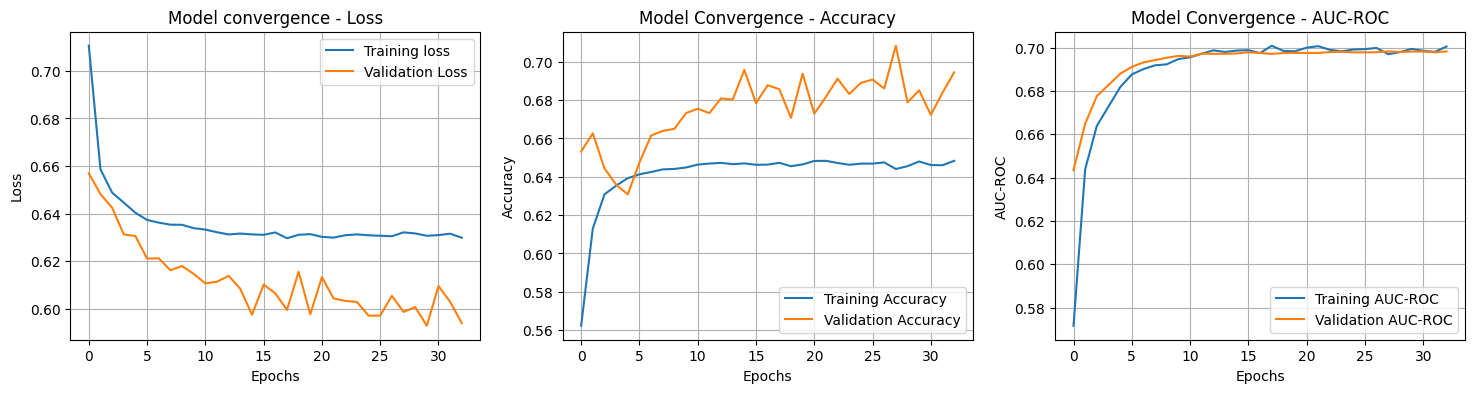

In [0]:
# Parameters and Hyperparamenters
args = {
    'num_workers': 2,
    'batch_size': 256,
    'lr': 0.0006325676320034128,
    'weight_decay':5e-4,
    'num_epochs': 33, 
    
}

# Training
predicted, labels = training_net(model, args = args, f_tuning = 0.8)#


In [0]:
target = labels
preds = predicted
metric_collection = MetricCollection([
    BinaryAUROC(), 
    BinaryAccuracy(),
    BinaryRecall(), 
    BinaryF1Score(),
])

print(metric_collection(preds, target))


{'BinaryAUROC': tensor(0.6982), 'BinaryAccuracy': tensor(0.6945), 'BinaryRecall': tensor(0.5572), 'BinaryF1Score': tensor(0.4015)}


#### Confusion matrix

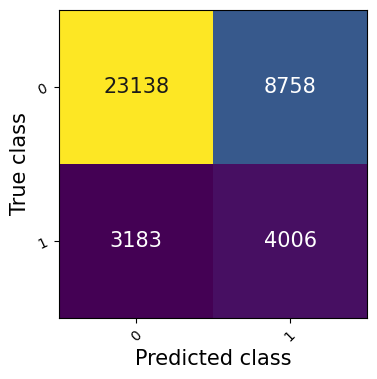

In [0]:
plt.rc('font', size = 10)
fig, ax= plt.subplots(figsize = (8, 4))
ax.grid(False)
metric = BinaryConfusionMatrix()
metric(predicted, labels)
fig_, ax_ = metric.plot(cmap = 'viridis', ax = ax)

### Testing model

#### Processing the test data

* In this step, I will only be transforming the test data based on the training data. Therefore, the **transform** function will be used, since the **fit_transform** function has already been applied to the training data, thus avoiding any data leakage and any bias that could occur in the test data.

In [0]:
X_test_preprocessed = preprocessor.transform(X_test)

In [0]:
X_test_preprocessed[0]

array([0.        , 0.35294118, 0.66666667, 1.        , 1.        ,
       0.42722724, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26376812, 0.39922481, 0.73763933, 0.23076923,
       0.38823529, 0.43298969, 0.0080808 , 0.03918785, 0.04911647,
       0.22652757, 0.60937881, 0.30250991])

#### Adjusting dimensions of training data

In [0]:
# Test

# Transforming labels to a dataset in numpy
y_test_numpy = y_test.to_numpy() 

# Adjusting label dimensions to 2D
y_test_numpy = y_test_numpy[:, np.newaxis]

test_set = Dataset(X_data = X_test_preprocessed, y_data = y_test_numpy)

### Testing ---

In [0]:
def test_net(net, device = 'cpu'):

    # Loading Dataset
    test_set = Dataset(X_data = X_test_preprocessed, y_data = y_test_numpy)

    # DataLoader
    testloader = torch.utils.data.DataLoader(
        test_set, batch_size = 4, shuffle = False, num_workers = 2
    )


    # Test labels and predictions

    all_preds = []
    all_labels = []

    # Net eval
    net.eval()
    for i, data in enumerate(testloader, 0):

        with torch.no_grad():

            inputs, labels = data
            inputs, labels =  inputs.to(device), labels.to(device)

            # Eval net
            outputs = net(inputs)

            # Accumulating Predictions
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    # Calculate AUC-ROC and Accuracy for validation
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return all_preds, all_labels

In [0]:
predicted, labels = test_net(model, device = 'cpu')

In [0]:
target = labels
preds = predicted
metric_collection = MetricCollection([
    BinaryAUROC(), 
    BinaryAccuracy(),
    BinaryRecall(), 
    BinaryF1Score(),
])

print(metric_collection(preds, target))

{'BinaryAUROC': tensor(0.7108), 'BinaryAccuracy': tensor(0.6642), 'BinaryRecall': tensor(0.6387), 'BinaryF1Score': tensor(0.3741)}


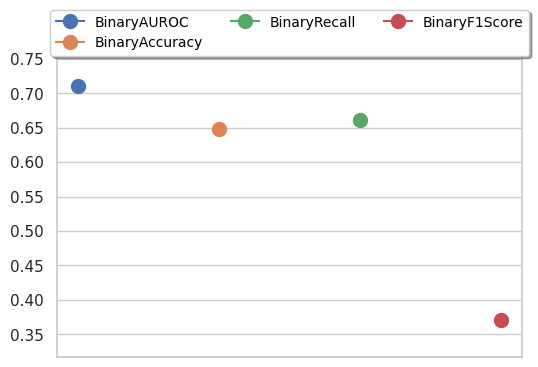

In [0]:
plt.rc('font', size = 10)
fig, ax= plt.subplots(figsize = (6, 4))
fig_ax_ = metric_collection.plot(together=True, ax = ax)

#### Confusion matrix

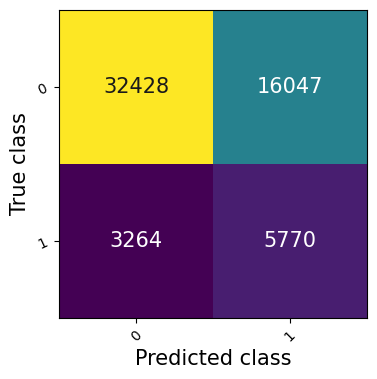

In [0]:
plt.rc('font', size = 10)
fig, ax= plt.subplots(figsize = (8, 4))
ax.grid(False)
metric = BinaryConfusionMatrix()
metric(predicted, labels)
fig_, ax_ = metric.plot(cmap = 'viridis', ax = ax)

### Salving the model and pipeline for data transform

In [0]:
# Salving the model
torch.save(model.state_dict(), '/Workspace/Users/*******@*****.com/Data_Science_Credit_Risk_Analysis-Lending_Club/model.pth')
print('Saved Pytorch Model State to model.pth')


Saved Pytorch Model State to model.pth


In [0]:
!ls

0_EDA  1_Modeling  model.pth  pipeline_preprocessor.pkl


In [0]:
# Salving the pipeline
with open('/Workspace/Users/*******@*****.com/Data_Science_Credit_Risk_Analysis-Lending_Club/pipeline_preprocessor.pkl', 'wb') as fp:
    pickle.dump(preprocessor, fp)

In [0]:
!ls

0_EDA  1_Modeling  model.pth  pipeline_preprocessor.pkl



### Considerations on validating the model on test data:

* At this stage of the project, we finally submitted our model to the test data. We can see that our AUC-ROC and Precision scores were satisfactory compared to the training data scores, and the confusion matrix is ​​balanced. The model presented the following scores:

  * **AUC-ROC**: 71.08%
  * **Accuracy**: 66.42%
  * **F1 Score**: 37.41%
  * **Recall**: 63.87%

#### Why were the classifications more balanced between negative and positive classes in the test data compared to the training data?

* Our training and test data were separated in an orderly manner based on the loan start dates. During Exploratory Data Analysis (EDA), we observed that the test data had less null data, which possibly contributed to some variables having greater relevance with the model's target variable, which is **loan_status**. Another factor that directly contributed to this result was the difference in the proportion of defaulted records between the datasets. The training data has approximately **18.50%** of defaulted records, while the test data has approximately **15.70%**.

* This difference in the training and test data, considering the chronological order of the loans, suggests that, over the years, the institution has improved and reduced the number of defaulted loans. Several factors may have positively contributed to this improvement, such as improved data collection during the loan granting process and better classification of borrowers based on their past experiences.

* Therefore, the model had no difficulty in adapting and generalizing the classifications with the test data, since this data, in addition to presenting better quality in terms of cleanliness and quantity of null data, also presented a lower proportion of defaulting customers compared to the training data.

#### Individual classification of each class:

* **Target 0**: Customers who paid their loans: **66.89% Accuracy** >>> **True Positives**: 32428 X **False Positives**: 16047
* **Target 1**: Customers who did not pay their loans: **63.87% Accuracy** >>> **True Negatives**: 5770 X **False Negatives**: 3264

* The model obtained a considerably higher accuracy in loans that were paid, which leads us to conclude that it has good detection for these loans.

#### Conclusion

* Regarding the accuracy of our model, we can conclude that it is satisfactory, considering the limitations of our dataset. We dealt with a considerable amount of null data in some variables that were crucial to the project. Some variables could not be used due to this problem, and they could have contributed positively to our model. Our numerical data has asymmetric distributions and a significant number of outliers, which, as verified in the EDA, are part of the natural distribution of the data in this set.

* In the next and final phase of this project, we will seek a solution to generate a balance in the classification of our model regarding whether or not to pay the requested loan, with the final decision in the organization based on our analysis and results.


# 6 - Deployment

* Considering that the model has a prediction **Accuracy of 71%** on the test data and the **ACU-ROC of 70%**, during the classification process some limits and parameters will be defined using some variables that were fundamental in our data analysis process.

* In addition to these variables helping us and giving us a broader view of our model's classifications, they will also help us give feedback to our potential client in case of approval or disapproval.

* I will use the training data to define these limits so that there is no leakage with the test data.

* To implement our final model, I will first consider the classification of our model and then consider the following variables to validate these classifications:

* **ability_to_pay**: The loan applicant's ability to pay considering his/her monthly salary x the loan installment.

* **dti**: The borrower's debt ratio.

* **score_cr** : The applicant's loan score based on FICO score criteria.

* **sub_grade** : The risk rating of the loan made by Lending Club.

* **expen_cr_inc** : The rating of the applicant's level of revolving credit utilization.

#### So our classifier will be as follows:

* When the model classifies the loans as **fully paid** and the applicant has the following scores and classifications:

  
  * **ability_to_pay**  < 10%

    * OR

  * **dti** < 15%

    * OR

  * **score_cr** > 700

    * OR

  * **expen_cr_inc** == 'A'

    * AND

  * **sub_grade** in ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5']

* This loan will be classified as:

  * **very low risk of default**. 

  * *Therefore it will be automatically approved*

* And if the model classifies the loans as fully paid and the applicant **does not have the scores and classifications above**:

* This loan will be classified as:
   
  * **Low risk of default**. 

   * *Therefore, it will be forwarded for analysis by the manager to be approved or not*

* When the model classifies the loans as **defaulters** and the applicant has the following scores and classifications:

  * **ability_to_pay**  > 10%

    * OR

  * **dti** > 15%

    * OR

  * **score_cr** <= 700

    * OR

  * **expen_cr_inc** == 'B' or 'C' or 'D'

    * AND

  * **sub_grade** in ['E1', 'E2', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']

* This loan will be classified as:
  
  * **Very high risk of default**. 
  
  * *Therefore, it will be automatically rejected*

* And if the model classifies the loans as as defaulters and the applicant **does not have the scores and classifications above**:

* This loan will be classified as:

  * **Medium risk of default**.   

  * *Therefore, it will be forwarded for analysis by the manager to be approved or not*

In [0]:
# Loading data train
# File location and file type
file_location = 'dbfs:/FileStore/Data_Science_Credit_Risk_Analysis-Lending_Club/Datasets/Gold/train'
train_data = ps.read_parquet(file_location)
train_data = train_data.to_pandas()

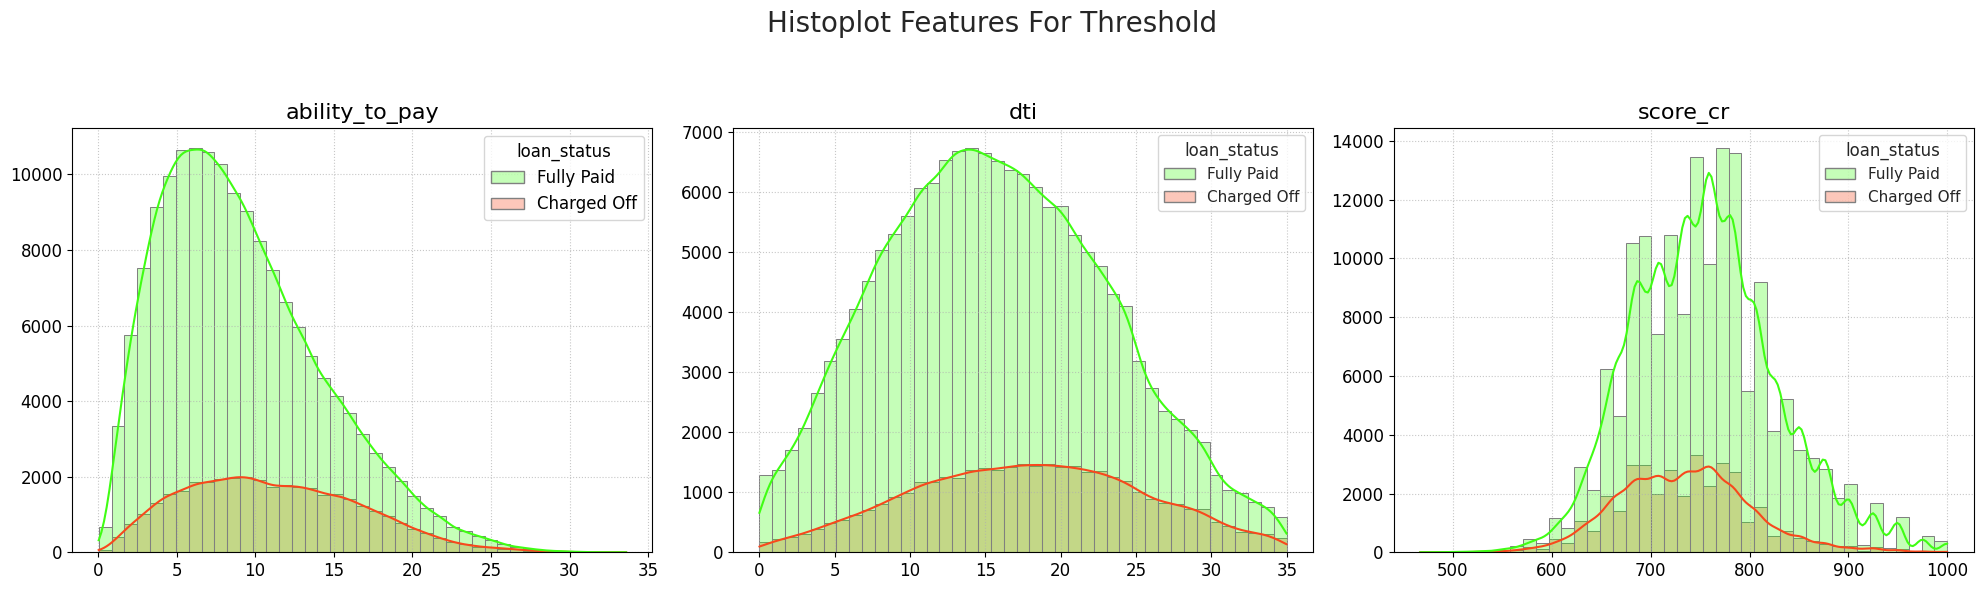

In [0]:
# Determining the number of bins with Sturges' Rule
n = train_data.shape[0]
bins = round(1 + (3.322 * np.log(n)))
bins

# Columns
hist_cols = ['ability_to_pay', 'dti', 'score_cr']

plt.rc('font', size = 12)
fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax = ax.flatten()
grid_style = dict(alpha = 0.7, linestyle = 'dotted')
for i, col_list in enumerate(hist_cols):
    sns.histplot(
        data = train_data,
        x = col_list,
        bins = bins,
        hue = 'loan_status',
        #multiple = 'fill',
        kde = True,
        alpha = 0.3,
        edgecolor = 'grey',
        palette = ['#40fd14', '#f8481c'],
        ax = ax[i]
        
        )
    sns.set(style = 'whitegrid')
    ax[i].grid(axis = 'y', which = 'major', **grid_style)
    ax[i].grid(axis = 'x', which = 'major', **grid_style)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_title(f'\n{col_list}', fontsize = 16)

plt.suptitle('Histoplot Features For Threshold', fontsize = 20)
plt.tight_layout(rect = [0, 0, 1, 0.97])
plt.show()

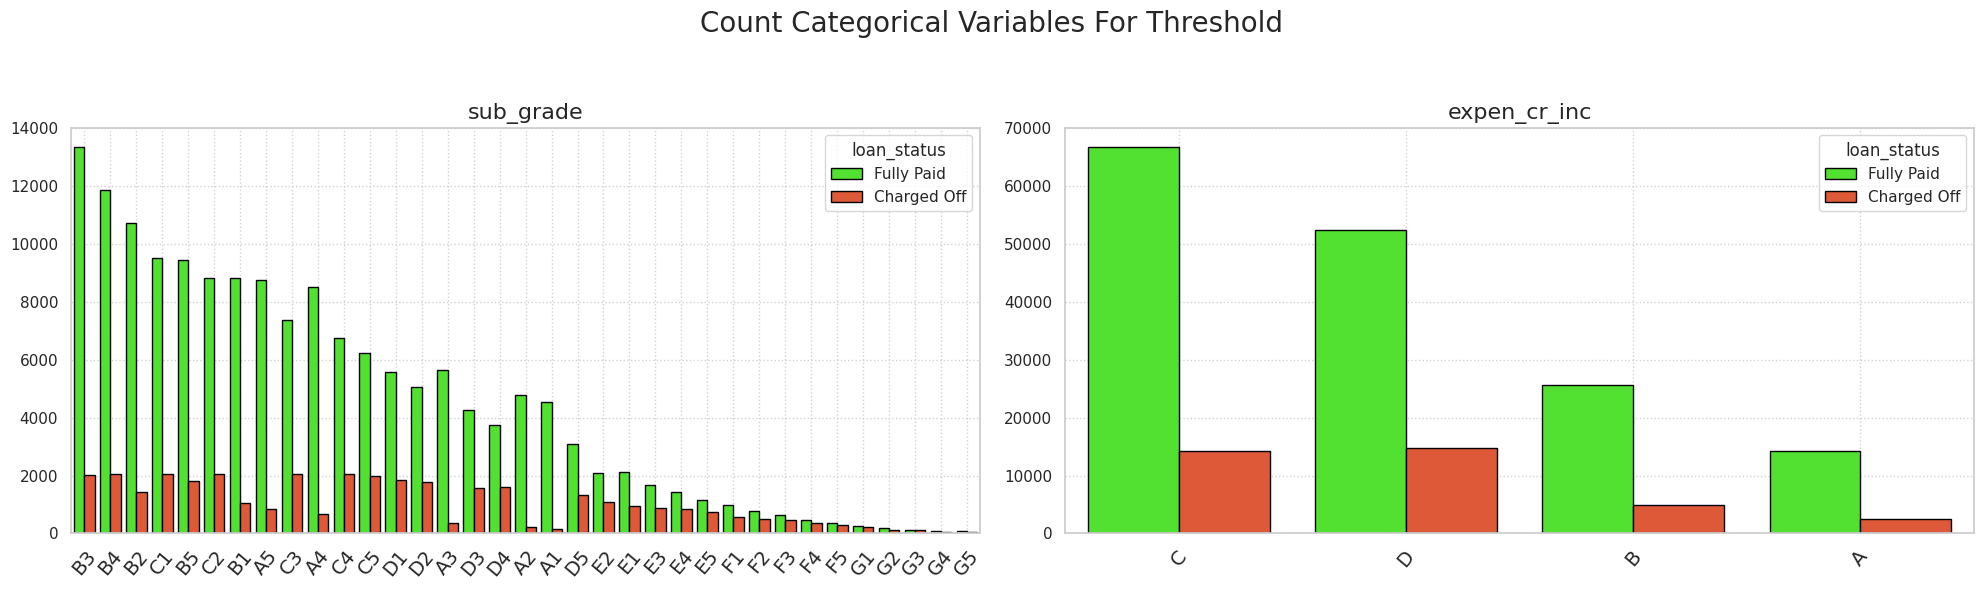

In [0]:
count_cols = [
    'sub_grade', 'expen_cr_inc'
]

plt.rc('font', size = 16)
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

ax = ax.flatten()
grid_style = dict(alpha = 0.9, linestyle = 'dotted')
for i, col_list in enumerate(count_cols):
    sns.countplot(
        data = train_data,
        x = col_list,
        hue = 'loan_status',
        order = train_data[col_list].value_counts(ascending = False).index,
        edgecolor = 'black',
        palette = ['#40fd14', '#f8481c'],
        ax = ax[i]
        
        )
    sns.set(style = 'whitegrid')
    ax[i].grid(axis = 'y', which = 'major', **grid_style)
    ax[i].grid(axis = 'x', which = 'major', **grid_style)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_title(f'\n{col_list}', fontsize = 16)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 50, fontsize = 14)

plt.suptitle('Count Categorical Variables For Threshold', fontsize = 20)
plt.tight_layout(rect = [0, 0, 1, 0.97])
plt.show()

##### Classes of sub_grade

* This variable is the classification made by the LedingClub institution according to the risk of the loans made by its applicants.

* Due to its importance, this variable will be used as the main criterion for the final classifier to evaluate the loan request and the possibility of it being paid or not.

* The classifier will search for the parameters defined above in the other variables, but these parameters will only be validated according to the lists of grades that will be defined next, where two lists of sub_grades will be created, one list for the lowest default rates and another with the highest default rates.

In [0]:
# Counting the frequency of the variable sub_grade x loan_status
frequency = train_data.groupby(['sub_grade', 'loan_status']).size().reset_index(name = 'frequency_grade')

# calculate the frequencies of each 'sub_grade'
sum_for_grade = frequency.groupby('sub_grade')['frequency_grade'].transform('sum')

# Calculate the porcentage
frequency['porcentage'] = round((frequency['frequency_grade'] / sum_for_grade) * 100, 2)
frequency.head(10)

,sub_grade,loan_status,frequency_grade,porcentage
0,A1,Charged Off,165,3.52
1,A1,Fully Paid,4526,96.48
2,A2,Charged Off,238,4.75
3,A2,Fully Paid,4777,95.25
4,A3,Charged Off,362,6.02
5,A3,Fully Paid,5651,93.98
6,A4,Charged Off,681,7.42
7,A4,Fully Paid,8496,92.58
8,A5,Charged Off,851,8.87
9,A5,Fully Paid,8745,91.13


##### The good grades

* These grades have a much lower default rate than others, ranging from **3.52%** to **16.05**%

In [0]:
frequency[frequency['loan_status'] == 'Charged Off'].sort_values(by = 'porcentage', ascending = True).head(10)

,sub_grade,loan_status,frequency_grade,porcentage
0,A1,Charged Off,165,3.52
2,A2,Charged Off,238,4.75
4,A3,Charged Off,362,6.02
6,A4,Charged Off,681,7.42
8,A5,Charged Off,851,8.87
10,B1,Charged Off,1059,10.71
12,B2,Charged Off,1421,11.70
14,B3,Charged Off,2022,13.16
16,B4,Charged Off,2059,14.78
18,B5,Charged Off,1804,16.05


##### The bad grades

* These grades have a much hight default rate than others, ranging from **31.25%** to **47.66**%

In [0]:
frequency[frequency['loan_status'] == 'Charged Off'].sort_values(by = 'porcentage', ascending = False).head(15)

,sub_grade,loan_status,frequency_grade,porcentage
64,G3,Charged Off,102,47.66
58,F5,Charged Off,304,46.41
60,G1,Charged Off,214,46.12
56,F4,Charged Off,369,43.72
54,F3,Charged Off,460,42.09
68,G5,Charged Off,48,41.38
62,G2,Charged Off,131,40.94
52,F2,Charged Off,484,38.54
48,E5,Charged Off,732,38.47
46,E4,Charged Off,849,37.19


#### Loading Net trained and pipeline for preprosseing data

In [0]:
!ls

0_EDA  1_Modeling  model.pth  pipeline_preprocessor.pkl


In [0]:
# Loading model

# Input Layer
input_layer = len(train_set[0][0])

# Output Layer
output_layer = 1
model_loaded = Net(input_layer = input_layer, output_layer = output_layer, l1 = 2, l2 = 64, l3 = 8, drop_p = 0.1).to('cpu')
model_loaded.load_state_dict(torch.load('/Workspace/Users/*******@*****.com/Data_Science_Credit_Risk_Analysis-Lending_Club/model.pth'))
print(model_loaded)

Net(
  (features): Sequential(
    (0): Linear(in_features=23, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=2, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [0]:
# Loading pipeline
with open('/Workspace/Users/*******@*****.com/Data_Science_Credit_Risk_Analysis-Lending_Club/pipeline_preprocessor.pkl', 'rb') as fp:
    preprocessor_loaded = pickle.load(fp)

In [0]:
def loan_checker(loan_for_class, device = 'cpu'):
    
    # Data preprocessing
    data_preprocessed = preprocessor_loaded.transform(loan_for_class)
    
    # Loading Network Trained
    net = model_loaded.to(device)

    # Net to eval
    net.eval()
    # Loading Dataset
    X = torch.from_numpy(data_preprocessed.astype(np.float32))
    X = X.to(device)
    pred = net(X)
    pred = torch.sigmoid(pred).cpu()
    
    probabilities  = pred.item()

    # Convert probabilities to binary values ​​(0 or 1) using a threshold
    thershold = 0.5
    binary_pred = (pred >= thershold).int().item()
    
    print(f'\nThis loan has a: {round((probabilities * 100), 2)}% chance of defaulting')
  
    model_prediction = binary_pred
    # expen_cr_inc
    bad_expen = ['D']
    good_expen = ['A']
    expen_cr_inc = loan_for_class['expen_cr_inc'].item()
    # sub_grade
    bad_grades = ['E1', 'E2', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',]
    good_grades = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',]
    sub_grade = loan_for_class['sub_grade'].item()

    # dti
    dti = loan_for_class['dti'].item()
    # score_cr
    score_cr = loan_for_class['score_cr'].item()
    # ability_to_pay
    ability_to_pay = loan_for_class['ability_to_pay'].item()

    if model_prediction == 1:

        if (ability_to_pay > 10 or score_cr < 700 or dti > 15 or expen_cr_inc in bad_expen) and (sub_grade in bad_grades):
            print(f'Loan denied! ---  High risk of default loan')
            print(f'\nThis loan has been considered high risk because some of the scores below do not meet the criteria required for loan approval.')
            print(f"\nexpen_cr_inc: {expen_cr_inc} >>>> {'Not OK' if expen_cr_inc in bad_expen else 'OK'}")
            print(f"score_cr: {score_cr} >>>> {'Not OK' if score_cr < 700 else 'OK'}")
            print(f"ability_to_pay: {ability_to_pay} >>>> {'Not OK' if ability_to_pay > 10 else 'OK'}")
            print(f"dti: {dti} >>>> {'Not OK' if dti > 15 else 'OK'}")
            print(f"\n### sub_grade ###: {sub_grade} >>>> {'Not OK' if sub_grade in bad_grades else 'OK'}")
        else:
            print(f'Approval subject to manager analysis! --- Medium risk loan of default')
            print(f'\nThis loan has been considered medium risk because some of the scores below meet the criteria required for loan approval.')
            print(f"\nexpen_cr_inc: {expen_cr_inc} >>>> {'Not OK' if expen_cr_inc in bad_expen else 'OK'}")
            print(f"score_cr: {score_cr} >>>> {'Not OK' if score_cr < 700 else 'OK'}")
            print(f"ability_to_pay: {ability_to_pay} >>>> {'Not OK' if ability_to_pay > 10 else 'OK'}")
            print(f"dti: {dti} >>>> {'Not OK' if dti > 15 else 'OK'}")
            print(f"\n### sub_grade ###: {sub_grade} >>>> {'Not OK' if sub_grade in bad_grades else 'OK'}")
    

    if model_prediction == 0:

        if (ability_to_pay < 10 or score_cr >= 700 or dti < 15 or expen_cr_inc in (good_expen)) and (sub_grade in(good_grades)):
            print(f'Loan approved! ---  Very low default risk loan')
            print(f'\nThis loan has been deemed very low risk because some of the scores below meet the criteria required for loan approval.')
            print(f"\nexpen_cr_inc: {expen_cr_inc} >>>> {'OK' if expen_cr_inc in good_expen else 'Not OK'}")
            print(f"score_cr: {score_cr} >>>> {'OK' if score_cr >= 700 else 'Not OK'}")
            print(f"ability_to_pay: {ability_to_pay} >>>> {'OK' if ability_to_pay <= 10 else 'Not OK'}")
            print(f"dti: {dti} >>>> {'OK' if dti <= 15 else 'Not OK'}")
            print(f"\n### sub_grade ###: {sub_grade} >>>> {'OK' if sub_grade in good_grades else 'Not OK'}")
        else:
            print(f'Approval subject to manager analysis! --- Low risk of default loan')
            print(f'\nThis loan has been deemed low risk because some of the scores below do not meet the criteria required for loan approval.')
            print(f"\nexpen_cr_inc: {expen_cr_inc} >>>> {'OK' if expen_cr_inc in good_expen else 'Not OK'}")
            print(f"score_cr: {score_cr} >>>> {'OK' if score_cr >= 700 else 'Not OK'}")
            print(f"ability_to_pay: {ability_to_pay} >>>> {'OK' if ability_to_pay <= 10 else 'Not OK'}")
            print(f"dti: {dti} >>>> {'OK' if dti <= 15 else 'Not OK'}")
            print(f"\n### sub_grade ###: {sub_grade} >>>> {'OK' if sub_grade in good_grades else 'Not OK'}")
  

#### Exemple of loan solicitation:

In [0]:
loan_for_class = train_data[0:1]

In [0]:
loan_for_class

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mo_earliest_cr_line,real_income,ability_to_pay,expen_cr_inc,score_cr
0,5000.0,36 months,10.65,B2,10,RENT,Fully Paid,credit_card,27.65,A,B,3,A,83.7,9,f,A,79803.0,22100.0,323,17364.0,11.26,D,716.67


In [0]:
loan_checker(loan_for_class)


This loan has a: 46.75% chance of defaulting
Loan approved! ---  Very low default risk loan

This loan has been deemed very low risk because some of the scores below meet the criteria required for loan approval.

expen_cr_inc: D >>>> Not OK
score_cr: 716.67 >>>> OK
ability_to_pay: 11.26 >>>> Not OK
dti: 27.65 >>>> Not OK

### sub_grade ###: B2 >>>> OK


####Some more examples of loan requests:

In [0]:
# Loading data test
# File location and file type
file_location = 'dbfs:/FileStore/Data_Science_Credit_Risk_Analysis-Lending_Club/Datasets/Gold/test'
test_data = ps.read_parquet(file_location)
test_data = test_data.to_pandas()

In [0]:
group_test = test_data[0:20]
group_test.head(10)

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mo_earliest_cr_line,real_income,ability_to_pay,expen_cr_inc,score_cr
0,9600.0,36 months,13.66,C3,10,RENT,Fully Paid,debt_consolidation,25.81,A,A,12,A,59.4,44,f,A,38566.0,27600.0,265,51191.10,7.65,C,791.67
1,7650.0,36 months,13.66,C3,0,RENT,Charged Off,debt_consolidation,34.81,A,B,11,A,91.9,20,f,A,64426.0,18300.0,148,32595.00,9.58,D,600.00
2,5250.0,36 months,11.44,B4,2,RENT,Fully Paid,debt_consolidation,14.36,A,A,8,A,20.2,13,f,A,10133.0,22000.0,67,22266.40,9.32,C,758.33
3,2500.0,36 months,11.99,B5,0,MORTGAGE,Fully Paid,home_improvement,13.77,A,B,9,A,94.3,32,f,A,397223.0,24300.0,158,76744.70,1.30,D,775.00
4,2000.0,36 months,14.99,C5,8,RENT,Fully Paid,credit_card,22.14,A,A,10,B,62.4,21,f,A,20539.0,15300.0,219,25070.92,3.32,D,733.33
5,2000.0,36 months,12.99,C2,0,RENT,Fully Paid,medical,5.46,A,B,14,A,1.9,20,w,B,744.0,39600.0,193,20148.36,4.01,A,841.67
6,28000.0,60 months,10.49,B3,2,MORTGAGE,Fully Paid,debt_consolidation,16.13,A,B,15,A,35.2,39,w,A,239362.0,41700.0,244,56192.90,12.85,C,783.33
7,12000.0,60 months,17.86,D5,4,RENT,Fully Paid,debt_consolidation,28.78,A,A,12,A,41.1,15,w,A,47115.0,33700.0,126,42732.00,8.53,C,666.67
8,6825.0,36 months,15.99,D2,1,RENT,Fully Paid,debt_consolidation,26.06,A,A,7,A,26.3,9,f,A,15894.0,21000.0,45,14048.60,20.49,D,733.33
9,2400.0,36 months,14.31,C4,7,OWN,Fully Paid,other,24.45,B,A,8,B,46.1,15,f,B,18342.0,16200.0,91,26442.50,3.74,C,516.67


In [0]:
group_test.shape[0]

20

In [0]:
for i in range (group_test.shape[0]):
    print(f'\nLoan for Analysis: {i+ 1}')
    # Loading data
    loan_for_class = group_test[i : i + 1]
    
    # Function of classifier 
    
    loan_checker(loan_for_class)
    print('\n')
    print(15 * '#########')
    print('\n')

   


Loan for Analysis: 1

This loan has a: 36.74% chance of defaulting
Approval subject to manager analysis! --- Low risk of default loan

This loan has been deemed low risk because some of the scores below do not meet the criteria required for loan approval.

expen_cr_inc: C >>>> Not OK
score_cr: 791.67 >>>> OK
ability_to_pay: 7.65 >>>> OK
dti: 25.81 >>>> Not OK

### sub_grade ###: C3 >>>> Not OK


#######################################################################################################################################



Loan for Analysis: 2

This loan has a: 59.91% chance of defaulting
Approval subject to manager analysis! --- Medium risk loan of default

This loan has been considered medium risk because some of the scores below meet the criteria required for loan approval.

expen_cr_inc: D >>>> Not OK
score_cr: 600.0 >>>> Not OK
ability_to_pay: 9.58 >>>> OK
dti: 34.81 >>>> Not OK

### sub_grade ###: C3 >>>> OK


############################################################

##Final considerations:

###**We can make the following considerations regarding loan classifications**:

###**Very low risk:** 

* These are loans classified as paid. The selected indicators are in accordance with the rules of our classifier, which allows us to offer better interest rates to this borrower and possibly increase the requested loan amount.

###**Low risk:** 

* These are loans classified as paid. However, the selected indicators are not in accordance with the rules of our classifier. Therefore, we must consider the borrower's scores and classifications to verify the possibility of approval. In case of approval or not, we have the indicators to justify to our clients the reason for the decision. In cases of approval, we can reduce the amount requested to prevent possible fraud. In case of denial, we can present the indicators that the potential client needs to improve in order to have their loan approved in the future.

###**Medium risk:** 

* These are loans classified as defaulted. However, the selected indicators are in accordance with the rules of our classifier. Therefore, we must consider the borrower's scores and classifications to verify the possibility of approval. Whether approved or not, we have the indicators to justify the decision to our clients. In cases of approval, we can reduce the amount requested to prevent possible fraud. In cases of denial, we can present the indicators that the potential client needs to improve in order to have their loan approved in the future.

###**Very high risk:** 

* These are loans classified as defaulted, and the indicators indicate that they will probably not be paid. Therefore, these loans will be denied, and we will use our indicators to justify the reasons for non-approval.